In [3]:
!unzip /content/drive/MyDrive/Owen/grddc_whole_images.zip

Streaming output truncated to the last 5000 lines.
  inflating: grddc_train/India/annotations/xmls/India_005125.xml  
  inflating: __MACOSX/grddc_train/India/annotations/xmls/._India_005125.xml  
  inflating: grddc_train/India/annotations/xmls/India_003554.xml  
  inflating: __MACOSX/grddc_train/India/annotations/xmls/._India_003554.xml  
  inflating: grddc_train/India/annotations/xmls/India_002892.xml  
  inflating: __MACOSX/grddc_train/India/annotations/xmls/._India_002892.xml  
  inflating: grddc_train/India/annotations/xmls/India_008401.xml  
  inflating: __MACOSX/grddc_train/India/annotations/xmls/._India_008401.xml  
  inflating: grddc_train/India/annotations/xmls/India_007732.xml  
  inflating: __MACOSX/grddc_train/India/annotations/xmls/._India_007732.xml  
  inflating: grddc_train/India/annotations/xmls/India_008367.xml  
  inflating: __MACOSX/grddc_train/India/annotations/xmls/._India_008367.xml  
  inflating: grddc_train/India/annotations/xmls/India_007054.xml  
  inflating:

In [4]:
!unzip /content/drive/MyDrive/Owen/grddc/GRDDC.zip

Streaming output truncated to the last 5000 lines.
  inflating: GRDDC/Czech_002300.jpg  
  inflating: GRDDC/Japan_012666.jpg  
  inflating: GRDDC/India_006474.jpg  
  inflating: GRDDC/India_009747.jpg  
  inflating: GRDDC/Japan_002475.jpg  
  inflating: GRDDC/India_008459.jpg  
  inflating: GRDDC/India_000005.jpg  
  inflating: GRDDC/Japan_000262.jpg  
  inflating: GRDDC/India_004263.jpg  
  inflating: GRDDC/Japan_009520.jpg  
  inflating: GRDDC/India_002612.jpg  
  inflating: GRDDC/Czech_001609.jpg  
  inflating: GRDDC/Japan_006613.jpg  
  inflating: GRDDC/Japan_009246.jpg  
  inflating: GRDDC/Japan_011409.jpg  
  inflating: GRDDC/India_002174.jpg  
  inflating: GRDDC/Japan_006175.jpg  
  inflating: GRDDC/India_004505.jpg  
  inflating: GRDDC/Japan_010717.jpg  
  inflating: GRDDC/Japan_008158.jpg  
  inflating: GRDDC/Czech_000271.jpg  
  inflating: GRDDC/India_000763.jpg  
  inflating: GRDDC/India_006312.jpg  
  inflating: GRDDC/India_009021.jpg  
  inflating: GRDDC/Japan_002313.jpg  

In [2]:
# importing the libraries
import pandas as pd
import numpy as np

# for reading and displaying images
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline

# for creating validation set
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

from imutils import paths
from tqdm import tqdm

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, BCELoss, Sequential, Conv2d, AvgPool2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, Sigmoid
from torch.optim import Adam, SGD

import os
import joblib
import torch
import random
import albumentations
import matplotlib.pyplot as plt
import argparse
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
from PIL import Image
from tqdm import tqdm
from torchvision import models as models
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

In [6]:
labelled_data = pd.read_csv("/content/GRDDC/labelled_data.csv", header = 0)

In [7]:
labelled_data.columns = ['image','country','oldpath','box','cracking_binary']

In [8]:
labelled_data['tensor_path'] = "/content/drive/MyDrive/Owen/international_prediction_maps/" + labelled_data['image'] + ".pt"

In [9]:
xtrain, xtest, ytrain, ytest = train_test_split(labelled_data['tensor_path'].values, labelled_data['cracking_binary'].values, test_size=0.2, random_state=42)

In [10]:
xtrain, xval, ytrain, yval= train_test_split(xtrain, ytrain, test_size=0.1, random_state=42)

In [9]:
class global_average(nn.Module):
    def __init__(self):
        super(global_average, self).__init__()
        self.layers = nn.Sequential(
            Conv2d(512,1, kernel_size=1),
        )

    def forward(self, x):
        x = self.layers(x)
        return x

In [10]:
class final_layers(nn.Module):
    def __init__(self):
        super(final_layers, self).__init__()
        self.layers = nn.Sigmoid()

    def forward(self, x):
        x = self.layers(x)
        p_none = 1-x
        p_none = torch.prod(p_none, dim=1)
        x = 1-p_none
        return x.squeeze()

In [11]:
device = ('cuda:0' if torch.cuda.is_available() else 'cpu')

In [13]:
resnet = models.resnet34(pretrained=False)
resnet.avgpool = global_average()
resnet.fc = final_layers()
resnet.load_state_dict(torch.load("/content/drive/MyDrive/Owen/resnet2_output/epoch47",map_location=torch.device('cpu')))
for param in resnet.parameters():
    param.requires_grad = False
if torch.cuda.is_available():
    resnet = resnet.cuda()

In [14]:
convolutions = nn.Sequential(*[list(resnet.children())[i] for i in range(9)])

In [19]:
labelled_data.head()

,image,country,oldpath,box,cracking_binary,new_path
0,Czech_003573,Czech,/Users/owenwinter/GRDDC/Czech_003573.jpg,NaN,0,/content/grddc_train/Czech/images/Czech_003573...
1,Czech_003215,Czech,/Users/owenwinter/GRDDC/Czech_003215.jpg,NaN,0,/content/grddc_train/Czech/images/Czech_003215...
2,Czech_000708,Czech,/Users/owenwinter/GRDDC/Czech_000708.jpg,NaN,0,/content/grddc_train/Czech/images/Czech_000708...
3,Czech_003201,Czech,/Users/owenwinter/GRDDC/Czech_003201.jpg,NaN,0,/content/grddc_train/Czech/images/Czech_003201...
4,Czech_002679,Czech,/Users/owenwinter/GRDDC/Czech_002679.jpg,NaN,0,/content/grddc_train/Czech/images/Czech_002679...


In [51]:
# image dataset module
class pano_images(Dataset):
    def __init__(self, path, labels, tfms=None):
        self.X = path
        self.y = labels
        # apply augmentations
        if tfms == 0: # if validating
            self.aug = albumentations.Compose([
                albumentations.Resize(672, 672, always_apply=True),
                albumentations.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225], always_apply=True)
            ])
        else: # if training
            self.aug = albumentations.Compose([
                albumentations.Resize(672, 672, always_apply=True),
                albumentations.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225], always_apply=True)
            ])
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        image = Image.open(self.X[i])
        image = self.aug(image=np.array(image))['image']
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        image = torch.tensor(image, dtype=torch.float).unsqueeze(dim=0).to(device)
        with torch.no_grad():
          image = convolutions(image)
        image = F.interpolate(image,(224,224)).squeeze()
        label = self.y[i]
        return image.unsqueeze(dim=0), torch.tensor(label, dtype=torch.long)

In [54]:
for path in tqdm(labelled_data['new_path'],total=len(labelled_data['new_path'])):
  tensor = pano_images([path],[0])[0][0]
  newpath = "/content/drive/MyDrive/Owen/international_prediction_maps/"+ path[-16:-4] + ".pt"
  torch.save(tensor,newpath)

100%|██████████| 21040/21040 [11:08<00:00, 31.47it/s]


In [12]:
class prediction_maps(Dataset):
    def __init__(self, path, labels, tfms=None):
        self.X = path
        self.y = labels

    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        tensor = torch.load(self.X[i])
        label = self.y[i]
        return tensor, torch.tensor(label, dtype=torch.long)

In [13]:
train_data = prediction_maps(xtrain, ytrain, tfms=1)
test_data = prediction_maps(xval, yval, tfms=0)
 
# dataloaders
trainloader = DataLoader(train_data, batch_size=100, shuffle=True)
testloader = DataLoader(test_data, batch_size=100, shuffle=False)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f907e4efe10>,
 <matplotlib.image.AxesImage at 0x7f907e46a450>)

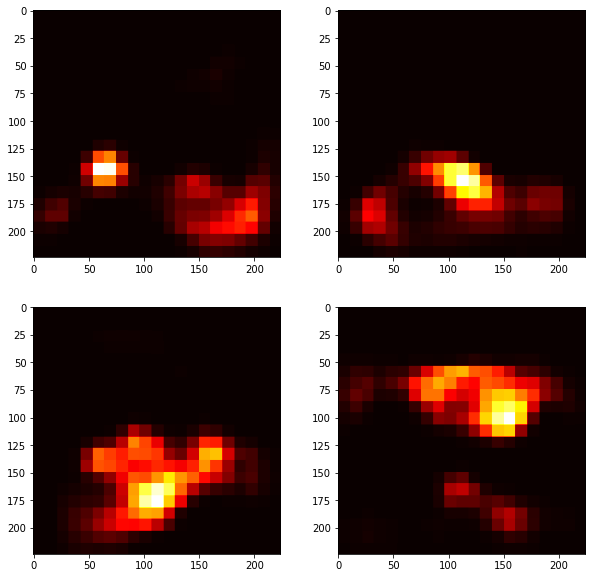

In [16]:
# visualizing images
i = 10000
plt.figure(figsize=(10,10))
plt.subplot(221), plt.imshow(1/(1+np.exp(-train_data[i][0].squeeze().cpu())), cmap='hot')
plt.subplot(222), plt.imshow(1/(1+np.exp(-train_data[i+25][0].squeeze().cpu())), cmap='hot')
plt.subplot(223), plt.imshow(1/(1+np.exp(-train_data[i+50][0].squeeze().cpu())), cmap='hot')
plt.subplot(224), plt.imshow(1/(1+np.exp(-train_data[i+75][0].squeeze().cpu())), cmap='hot')

In [17]:
class final_layers(nn.Module):
    def __init__(self):
        super(final_layers, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.layers(x)
        return x.squeeze()

In [18]:
# defining the model
model = models.resnet34(pretrained=False)
# defining the optimizer
model.fc = final_layers()
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
optimizer = Adam(model.parameters(), lr=0.00003)
# defining the loss function
criterion = BCELoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [19]:
''' SEED Everything '''
def seed_everything(SEED=42):
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True 
SEED=42
seed_everything(SEED=SEED)
''' SEED Everything '''
# set computation device
device = ('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}")

Computation device: cuda:0


In [20]:
#validation function
def validate(model, test_dataloader):
    print('Validating')
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    true_positives = 0
    true_negatives = 0
    false_positives = 0
    false_negatives = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(test_dataloader), total=int(len(test_data)/test_dataloader.batch_size)):
            data, target = data[0].to(device), data[1].to(device)
            outputs = model(data)
            loss = criterion(outputs.float(), target.float())
            val_running_loss += loss.item()
            preds = torch.round(outputs.data)
            val_running_correct += (preds == target).sum().item()
            true_positives += ((preds == 1)&(target == 1)).sum().item()
            true_negatives += ((preds == 0)&(target == 0)).sum().item()
            false_positives += ((preds == 1)&(target == 0)).sum().item()
            false_negatives += ((preds == 0)&(target == 1)).sum().item()
        
        try:
          precision = true_positives/(true_positives+false_positives)
          recall = true_positives/(true_positives+false_negatives)
          f1 = 2 * (precision*recall)/(precision+recall)
        except:
          f1 = 0
          precision = 0
          recall = 0
        val_loss = val_running_loss/int(len(test_data)/test_dataloader.batch_size)
        val_accuracy = 100. * val_running_correct/len(test_dataloader.dataset)
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}')
        print(f"Recall: {recall:.4f}, Precision: {precision:.2f}, F1: {f1:.2f}")
        print("TP:",true_positives,"TN:", true_negatives,"FP:", false_positives,"FN:", false_negatives)
        
        return val_loss, val_accuracy, f1

In [93]:
# training function
def fit(model, train_dataloader):
    print('Training')
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    true_positives = 0
    true_negatives = 0
    false_positives = 0
    false_negatives = 0
    for i, data in tqdm(enumerate(train_dataloader), total=int(len(train_data)/train_dataloader.batch_size)):
        data, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs.float(), target.float())
        train_running_loss += loss.item()
        preds = torch.round(outputs.data)
        train_running_correct += (preds == target).sum().item()
        true_positives += ((preds == 1)&(target == 1)).sum().item()
        true_negatives += ((preds == 0)&(target == 0)).sum().item()
        false_positives += ((preds == 1)&(target == 0)).sum().item()
        false_negatives += ((preds == 0)&(target == 1)).sum().item()
        loss.backward()
        optimizer.step()
    try:
      precision = true_positives/(true_positives+false_positives)
      recall = true_positives/(true_positives+false_negatives)
      f1 = 2 * (precision*recall)/(precision+recall)
    except:
      precision = 0
      recall = 0
      f1 = 0
    train_loss = train_running_loss/int(len(train_data)/train_dataloader.batch_size)
    train_accuracy = 100. * train_running_correct/len(train_dataloader.dataset)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}")
    print(f"Recall: {recall:.4f}, Precision: {precision:.2f}, F1: {f1:.2f}")
    
    return train_loss, train_accuracy, f1

In [94]:
train_loss , train_accuracy , train_f1 = [], [], []
val_loss , val_accuracy, val_f1 = [], [], []
start = time.time()
epochs = 75
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_accuracy, train_epoch_f1 = fit(model, trainloader)
    val_epoch_loss, val_epoch_accuracy, val_epoch_f1 = validate(model, testloader)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    train_f1.append(train_epoch_f1)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
    val_f1.append(val_epoch_f1)
    path = "/content/drive/MyDrive/Owen/international_stacked/epoch" + str(epoch)
    torch.save(model.state_dict(), path)
end = time.time()
print(f"{(end-start)/60:.3f} minutes")

  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 1 of 75
Training


152it [01:00,  2.50it/s]
  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.5918, Train Acc: 70.12
Recall: 0.1191, Precision: 0.56, F1: 0.20
Validating


17it [00:04,  4.24it/s]


Val Loss: 0.6119, Val Acc: 71.08
Recall: 0.2711, Precision: 0.54, F1: 0.36
TP: 138 TN: 1059 FP: 116 FN: 371


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 2 of 75
Training


152it [00:59,  2.54it/s]
  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.5437, Train Acc: 73.20
Recall: 0.3002, Precision: 0.63, F1: 0.41
Validating


17it [00:03,  4.40it/s]


Val Loss: 0.8318, Val Acc: 69.77
Recall: 0.0000, Precision: 0.00, F1: 0.00
TP: 0 TN: 1175 FP: 0 FN: 509


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 3 of 75
Training


152it [00:59,  2.57it/s]
  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.4682, Train Acc: 77.90
Recall: 0.4873, Precision: 0.70, F1: 0.57
Validating


17it [00:03,  4.44it/s]


Val Loss: 0.6751, Val Acc: 68.05
Recall: 0.2672, Precision: 0.45, F1: 0.34
TP: 136 TN: 1010 FP: 165 FN: 373


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 4 of 75
Training


152it [00:59,  2.56it/s]
  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.3039, Train Acc: 87.48
Recall: 0.7610, Precision: 0.82, F1: 0.79
Validating


17it [00:03,  4.37it/s]


Val Loss: 1.1474, Val Acc: 70.07
Recall: 0.0727, Precision: 0.54, F1: 0.13
TP: 37 TN: 1143 FP: 32 FN: 472


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 5 of 75
Training


152it [00:59,  2.56it/s]
  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.1279, Train Acc: 95.47
Recall: 0.9233, Precision: 0.93, F1: 0.93
Validating


17it [00:03,  4.45it/s]


Val Loss: 1.1249, Val Acc: 61.76
Recall: 0.4892, Precision: 0.39, F1: 0.44
TP: 249 TN: 791 FP: 384 FN: 260


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 6 of 75
Training


152it [00:59,  2.57it/s]
  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.0841, Train Acc: 97.00
Recall: 0.9490, Precision: 0.95, F1: 0.95
Validating


17it [00:03,  4.57it/s]


Val Loss: 2.1262, Val Acc: 48.75
Recall: 0.7682, Precision: 0.34, F1: 0.48
TP: 391 TN: 430 FP: 745 FN: 118


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 7 of 75
Training


152it [00:59,  2.57it/s]
  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.0521, Train Acc: 98.32
Recall: 0.9692, Precision: 0.98, F1: 0.97
Validating


17it [00:03,  4.68it/s]


Val Loss: 1.2961, Val Acc: 67.64
Recall: 0.2967, Precision: 0.45, F1: 0.36
TP: 151 TN: 988 FP: 187 FN: 358


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 8 of 75
Training


152it [00:58,  2.60it/s]
  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.0268, Train Acc: 99.24
Recall: 0.9864, Precision: 0.99, F1: 0.99
Validating


17it [00:03,  4.62it/s]


Val Loss: 1.2593, Val Acc: 66.69
Recall: 0.3595, Precision: 0.44, F1: 0.39
TP: 183 TN: 940 FP: 235 FN: 326


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 9 of 75
Training


152it [00:58,  2.60it/s]
  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.0108, Train Acc: 99.87
Recall: 0.9974, Precision: 1.00, F1: 1.00
Validating


17it [00:03,  4.79it/s]


Val Loss: 1.3153, Val Acc: 68.47
Recall: 0.2908, Precision: 0.47, F1: 0.36
TP: 148 TN: 1005 FP: 170 FN: 361


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 10 of 75
Training


152it [00:58,  2.61it/s]
  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.0036, Train Acc: 100.00
Recall: 1.0000, Precision: 1.00, F1: 1.00
Validating


17it [00:03,  4.70it/s]


Val Loss: 1.2560, Val Acc: 67.34
Recall: 0.3163, Precision: 0.44, F1: 0.37
TP: 161 TN: 973 FP: 202 FN: 348


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 11 of 75
Training


152it [00:58,  2.60it/s]
  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.0019, Train Acc: 100.00
Recall: 1.0000, Precision: 1.00, F1: 1.00
Validating


17it [00:03,  4.77it/s]


Val Loss: 1.2605, Val Acc: 67.40
Recall: 0.3163, Precision: 0.44, F1: 0.37
TP: 161 TN: 974 FP: 201 FN: 348


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 12 of 75
Training


152it [00:57,  2.64it/s]
  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.0015, Train Acc: 100.00
Recall: 1.0000, Precision: 1.00, F1: 1.00
Validating


17it [00:03,  4.80it/s]


Val Loss: 1.2738, Val Acc: 67.81
Recall: 0.3320, Precision: 0.46, F1: 0.38
TP: 169 TN: 973 FP: 202 FN: 340


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 13 of 75
Training


152it [00:57,  2.65it/s]
  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.0011, Train Acc: 100.00
Recall: 1.0000, Precision: 1.00, F1: 1.00
Validating


17it [00:03,  4.76it/s]


Val Loss: 1.2867, Val Acc: 66.92
Recall: 0.3360, Precision: 0.44, F1: 0.38
TP: 171 TN: 956 FP: 219 FN: 338


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 14 of 75
Training


152it [00:57,  2.64it/s]
  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.0008, Train Acc: 100.00
Recall: 1.0000, Precision: 1.00, F1: 1.00
Validating


17it [00:03,  4.75it/s]


Val Loss: 1.3212, Val Acc: 67.99
Recall: 0.3104, Precision: 0.46, F1: 0.37
TP: 158 TN: 987 FP: 188 FN: 351


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 15 of 75
Training


152it [00:58,  2.61it/s]
  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.0008, Train Acc: 100.00
Recall: 1.0000, Precision: 1.00, F1: 1.00
Validating


17it [00:03,  4.59it/s]


Val Loss: 1.3323, Val Acc: 67.81
Recall: 0.2986, Precision: 0.45, F1: 0.36
TP: 152 TN: 990 FP: 185 FN: 357


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 16 of 75
Training


152it [00:57,  2.65it/s]
  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.0007, Train Acc: 100.00
Recall: 1.0000, Precision: 1.00, F1: 1.00
Validating


17it [00:03,  4.58it/s]


Val Loss: 1.3403, Val Acc: 67.81
Recall: 0.3006, Precision: 0.45, F1: 0.36
TP: 153 TN: 989 FP: 186 FN: 356


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 17 of 75
Training


152it [00:57,  2.65it/s]
  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.0006, Train Acc: 100.00
Recall: 1.0000, Precision: 1.00, F1: 1.00
Validating


17it [00:03,  4.66it/s]


Val Loss: 1.3396, Val Acc: 67.87
Recall: 0.3143, Precision: 0.45, F1: 0.37
TP: 160 TN: 983 FP: 192 FN: 349


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 18 of 75
Training


152it [00:57,  2.64it/s]
  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.0005, Train Acc: 100.00
Recall: 1.0000, Precision: 1.00, F1: 1.00
Validating


17it [00:03,  4.75it/s]


Val Loss: 1.3440, Val Acc: 66.81
Recall: 0.3281, Precision: 0.43, F1: 0.37
TP: 167 TN: 958 FP: 217 FN: 342


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 19 of 75
Training


152it [00:57,  2.64it/s]
  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.0005, Train Acc: 100.00
Recall: 1.0000, Precision: 1.00, F1: 1.00
Validating


17it [00:03,  4.66it/s]


Val Loss: 1.3515, Val Acc: 67.64
Recall: 0.3104, Precision: 0.45, F1: 0.37
TP: 158 TN: 981 FP: 194 FN: 351


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 20 of 75
Training


152it [00:58,  2.62it/s]
  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.0004, Train Acc: 100.00
Recall: 1.0000, Precision: 1.00, F1: 1.00
Validating


17it [00:03,  4.72it/s]


Val Loss: 1.3883, Val Acc: 68.82
Recall: 0.2908, Precision: 0.47, F1: 0.36
TP: 148 TN: 1011 FP: 164 FN: 361


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 21 of 75
Training


152it [00:57,  2.63it/s]
  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.0004, Train Acc: 100.00
Recall: 1.0000, Precision: 1.00, F1: 1.00
Validating


17it [00:03,  4.60it/s]


Val Loss: 1.4131, Val Acc: 68.47
Recall: 0.2613, Precision: 0.46, F1: 0.33
TP: 133 TN: 1020 FP: 155 FN: 376


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 22 of 75
Training


152it [00:57,  2.66it/s]
  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.0004, Train Acc: 100.00
Recall: 1.0000, Precision: 1.00, F1: 1.00
Validating


17it [00:03,  4.59it/s]


Val Loss: 1.3830, Val Acc: 67.81
Recall: 0.3202, Precision: 0.45, F1: 0.38
TP: 163 TN: 979 FP: 196 FN: 346


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 23 of 75
Training


152it [00:57,  2.66it/s]
  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.0003, Train Acc: 100.00
Recall: 1.0000, Precision: 1.00, F1: 1.00
Validating


17it [00:03,  4.58it/s]


Val Loss: 1.4443, Val Acc: 68.47
Recall: 0.2436, Precision: 0.46, F1: 0.32
TP: 124 TN: 1029 FP: 146 FN: 385


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 24 of 75
Training


152it [00:57,  2.65it/s]
  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.0003, Train Acc: 100.00
Recall: 1.0000, Precision: 1.00, F1: 1.00
Validating


17it [00:03,  4.58it/s]


Val Loss: 1.4097, Val Acc: 67.81
Recall: 0.2927, Precision: 0.45, F1: 0.35
TP: 149 TN: 993 FP: 182 FN: 360


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 25 of 75
Training


152it [00:58,  2.62it/s]
  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.0003, Train Acc: 100.00
Recall: 1.0000, Precision: 1.00, F1: 1.00
Validating


17it [00:03,  4.52it/s]


Val Loss: 1.4229, Val Acc: 67.52
Recall: 0.2986, Precision: 0.44, F1: 0.36
TP: 152 TN: 985 FP: 190 FN: 357


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 26 of 75
Training


152it [00:58,  2.61it/s]
  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.0003, Train Acc: 100.00
Recall: 1.0000, Precision: 1.00, F1: 1.00
Validating


17it [00:03,  4.76it/s]


Val Loss: 1.4695, Val Acc: 68.53
Recall: 0.2593, Precision: 0.46, F1: 0.33
TP: 132 TN: 1022 FP: 153 FN: 377


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 27 of 75
Training


152it [00:57,  2.66it/s]
  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.0002, Train Acc: 100.00
Recall: 1.0000, Precision: 1.00, F1: 1.00
Validating


17it [00:03,  4.64it/s]


Val Loss: 1.4328, Val Acc: 67.34
Recall: 0.3183, Precision: 0.44, F1: 0.37
TP: 162 TN: 972 FP: 203 FN: 347


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 28 of 75
Training


152it [00:57,  2.66it/s]
  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.0002, Train Acc: 100.00
Recall: 1.0000, Precision: 1.00, F1: 1.00
Validating


17it [00:03,  4.56it/s]


Val Loss: 1.4609, Val Acc: 68.11
Recall: 0.2927, Precision: 0.46, F1: 0.36
TP: 149 TN: 998 FP: 177 FN: 360


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 29 of 75
Training


152it [00:56,  2.67it/s]
  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.0002, Train Acc: 100.00
Recall: 1.0000, Precision: 1.00, F1: 1.00
Validating


17it [00:03,  4.53it/s]


Val Loss: 1.5275, Val Acc: 68.88
Recall: 0.2318, Precision: 0.47, F1: 0.31
TP: 118 TN: 1042 FP: 133 FN: 391


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 30 of 75
Training


152it [00:57,  2.64it/s]
  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.0002, Train Acc: 100.00
Recall: 1.0000, Precision: 1.00, F1: 1.00
Validating


17it [00:03,  4.59it/s]


Val Loss: 1.4898, Val Acc: 67.81
Recall: 0.2947, Precision: 0.45, F1: 0.36
TP: 150 TN: 992 FP: 183 FN: 359


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 31 of 75
Training


152it [00:57,  2.65it/s]
  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.0002, Train Acc: 100.00
Recall: 1.0000, Precision: 1.00, F1: 1.00
Validating


17it [00:03,  4.66it/s]


Val Loss: 1.5107, Val Acc: 68.41
Recall: 0.2692, Precision: 0.46, F1: 0.34
TP: 137 TN: 1015 FP: 160 FN: 372


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 32 of 75
Training


152it [00:57,  2.63it/s]
  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.0001, Train Acc: 100.00
Recall: 1.0000, Precision: 1.00, F1: 1.00
Validating


17it [00:03,  4.84it/s]


Val Loss: 1.5220, Val Acc: 68.11
Recall: 0.2633, Precision: 0.45, F1: 0.33
TP: 134 TN: 1013 FP: 162 FN: 375


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 33 of 75
Training


152it [00:57,  2.65it/s]
  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.0002, Train Acc: 100.00
Recall: 1.0000, Precision: 1.00, F1: 1.00
Validating


17it [00:03,  4.73it/s]


Val Loss: 1.5272, Val Acc: 67.87
Recall: 0.2849, Precision: 0.45, F1: 0.35
TP: 145 TN: 998 FP: 177 FN: 364


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 34 of 75
Training


152it [00:57,  2.66it/s]
  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.0001, Train Acc: 100.00
Recall: 1.0000, Precision: 1.00, F1: 1.00
Validating


17it [00:03,  4.65it/s]


Val Loss: 1.5953, Val Acc: 68.82
Recall: 0.2377, Precision: 0.47, F1: 0.32
TP: 121 TN: 1038 FP: 137 FN: 388


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 35 of 75
Training


152it [00:57,  2.64it/s]
  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.0001, Train Acc: 100.00
Recall: 1.0000, Precision: 1.00, F1: 1.00
Validating


17it [00:03,  4.65it/s]


Val Loss: 1.5241, Val Acc: 67.81
Recall: 0.2731, Precision: 0.45, F1: 0.34
TP: 139 TN: 1003 FP: 172 FN: 370


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 36 of 75
Training


152it [00:57,  2.66it/s]
  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.0001, Train Acc: 100.00
Recall: 1.0000, Precision: 1.00, F1: 1.00
Validating


17it [00:03,  4.55it/s]


Val Loss: 1.5509, Val Acc: 68.23
Recall: 0.2652, Precision: 0.46, F1: 0.34
TP: 135 TN: 1014 FP: 161 FN: 374


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 37 of 75
Training


152it [00:57,  2.63it/s]
  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.0001, Train Acc: 100.00
Recall: 1.0000, Precision: 1.00, F1: 1.00
Validating


17it [00:03,  4.76it/s]


Val Loss: 1.5865, Val Acc: 68.53
Recall: 0.2633, Precision: 0.46, F1: 0.34
TP: 134 TN: 1020 FP: 155 FN: 375


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 38 of 75
Training


152it [00:57,  2.66it/s]
  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.0001, Train Acc: 100.00
Recall: 1.0000, Precision: 1.00, F1: 1.00
Validating


17it [00:03,  4.70it/s]


Val Loss: 1.5652, Val Acc: 68.11
Recall: 0.2888, Precision: 0.46, F1: 0.35
TP: 147 TN: 1000 FP: 175 FN: 362


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 39 of 75
Training


152it [00:57,  2.65it/s]
  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.0001, Train Acc: 100.00
Recall: 1.0000, Precision: 1.00, F1: 1.00
Validating


17it [00:03,  4.65it/s]


Val Loss: 1.5663, Val Acc: 67.99
Recall: 0.2790, Precision: 0.45, F1: 0.35
TP: 142 TN: 1003 FP: 172 FN: 367


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 40 of 75
Training


152it [00:57,  2.62it/s]
  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.0001, Train Acc: 100.00
Recall: 1.0000, Precision: 1.00, F1: 1.00
Validating


17it [00:03,  4.70it/s]


Val Loss: 1.6015, Val Acc: 68.23
Recall: 0.2692, Precision: 0.46, F1: 0.34
TP: 137 TN: 1012 FP: 163 FN: 372


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 41 of 75
Training


152it [00:57,  2.66it/s]
  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.0001, Train Acc: 100.00
Recall: 1.0000, Precision: 1.00, F1: 1.00
Validating


17it [00:03,  4.62it/s]


Val Loss: 1.6335, Val Acc: 68.71
Recall: 0.2593, Precision: 0.47, F1: 0.33
TP: 132 TN: 1025 FP: 150 FN: 377


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 42 of 75
Training


152it [00:57,  2.66it/s]
  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.0001, Train Acc: 100.00
Recall: 1.0000, Precision: 1.00, F1: 1.00
Validating


17it [00:03,  4.60it/s]


Val Loss: 1.5922, Val Acc: 68.05
Recall: 0.2947, Precision: 0.46, F1: 0.36
TP: 150 TN: 996 FP: 179 FN: 359


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 43 of 75
Training


152it [00:57,  2.65it/s]
  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.0001, Train Acc: 100.00
Recall: 1.0000, Precision: 1.00, F1: 1.00
Validating


17it [00:03,  4.79it/s]


Val Loss: 1.6381, Val Acc: 68.71
Recall: 0.2574, Precision: 0.47, F1: 0.33
TP: 131 TN: 1026 FP: 149 FN: 378


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 44 of 75
Training


152it [00:57,  2.65it/s]
  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.0001, Train Acc: 100.00
Recall: 1.0000, Precision: 1.00, F1: 1.00
Validating


17it [00:03,  4.75it/s]


Val Loss: 1.6508, Val Acc: 68.23
Recall: 0.2593, Precision: 0.46, F1: 0.33
TP: 132 TN: 1017 FP: 158 FN: 377


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 45 of 75
Training


152it [00:58,  2.62it/s]
  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.0001, Train Acc: 100.00
Recall: 1.0000, Precision: 1.00, F1: 1.00
Validating


17it [00:03,  4.78it/s]


Val Loss: 1.6840, Val Acc: 68.88
Recall: 0.2534, Precision: 0.47, F1: 0.33
TP: 129 TN: 1031 FP: 144 FN: 380


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 46 of 75
Training


152it [00:57,  2.64it/s]
  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.0001, Train Acc: 100.00
Recall: 1.0000, Precision: 1.00, F1: 1.00
Validating


17it [00:03,  4.85it/s]


Val Loss: 1.6919, Val Acc: 68.65
Recall: 0.2593, Precision: 0.47, F1: 0.33
TP: 132 TN: 1024 FP: 151 FN: 377


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 47 of 75
Training


152it [00:57,  2.65it/s]
  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.0000, Train Acc: 100.00
Recall: 1.0000, Precision: 1.00, F1: 1.00
Validating


17it [00:03,  4.81it/s]


Val Loss: 1.6873, Val Acc: 68.76
Recall: 0.2672, Precision: 0.47, F1: 0.34
TP: 136 TN: 1022 FP: 153 FN: 373


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 48 of 75
Training


152it [00:57,  2.65it/s]
  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.0000, Train Acc: 100.00
Recall: 1.0000, Precision: 1.00, F1: 1.00
Validating


17it [00:03,  4.84it/s]


Val Loss: 1.6969, Val Acc: 68.71
Recall: 0.2574, Precision: 0.47, F1: 0.33
TP: 131 TN: 1026 FP: 149 FN: 378


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 49 of 75
Training


152it [00:57,  2.64it/s]
  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.0000, Train Acc: 100.00
Recall: 1.0000, Precision: 1.00, F1: 1.00
Validating


17it [00:03,  4.68it/s]


Val Loss: 1.7497, Val Acc: 69.00
Recall: 0.2436, Precision: 0.48, F1: 0.32
TP: 124 TN: 1038 FP: 137 FN: 385


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 50 of 75
Training


152it [00:58,  2.61it/s]
  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.0000, Train Acc: 100.00
Recall: 1.0000, Precision: 1.00, F1: 1.00
Validating


17it [00:03,  4.78it/s]


Val Loss: 1.7197, Val Acc: 68.82
Recall: 0.2554, Precision: 0.47, F1: 0.33
TP: 130 TN: 1029 FP: 146 FN: 379


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 51 of 75
Training


152it [00:57,  2.63it/s]
  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.0000, Train Acc: 100.00
Recall: 1.0000, Precision: 1.00, F1: 1.00
Validating


17it [00:03,  4.62it/s]


Val Loss: 1.6953, Val Acc: 68.41
Recall: 0.2888, Precision: 0.46, F1: 0.36
TP: 147 TN: 1005 FP: 170 FN: 362


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 52 of 75
Training


152it [00:57,  2.64it/s]
  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.0000, Train Acc: 100.00
Recall: 1.0000, Precision: 1.00, F1: 1.00
Validating


17it [00:03,  4.72it/s]


Val Loss: 1.7405, Val Acc: 68.88
Recall: 0.2593, Precision: 0.47, F1: 0.34
TP: 132 TN: 1028 FP: 147 FN: 377


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 53 of 75
Training


152it [00:57,  2.65it/s]
  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.0000, Train Acc: 100.00
Recall: 1.0000, Precision: 1.00, F1: 1.00
Validating


17it [00:03,  4.75it/s]


Val Loss: 1.7692, Val Acc: 69.18
Recall: 0.2593, Precision: 0.48, F1: 0.34
TP: 132 TN: 1033 FP: 142 FN: 377


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 54 of 75
Training


152it [00:57,  2.64it/s]
  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.0000, Train Acc: 100.00
Recall: 1.0000, Precision: 1.00, F1: 1.00
Validating


17it [00:03,  4.80it/s]


Val Loss: 1.7726, Val Acc: 68.71
Recall: 0.2574, Precision: 0.47, F1: 0.33
TP: 131 TN: 1026 FP: 149 FN: 378


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 55 of 75
Training


152it [00:58,  2.62it/s]
  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.0000, Train Acc: 100.00
Recall: 1.0000, Precision: 1.00, F1: 1.00
Validating


17it [00:03,  4.75it/s]


Val Loss: 1.7651, Val Acc: 68.59
Recall: 0.2574, Precision: 0.46, F1: 0.33
TP: 131 TN: 1024 FP: 151 FN: 378


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 56 of 75
Training


152it [00:57,  2.65it/s]
  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.0000, Train Acc: 100.00
Recall: 1.0000, Precision: 1.00, F1: 1.00
Validating


17it [00:03,  4.80it/s]


Val Loss: 1.7973, Val Acc: 68.82
Recall: 0.2475, Precision: 0.47, F1: 0.32
TP: 126 TN: 1033 FP: 142 FN: 383


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 57 of 75
Training


152it [00:57,  2.64it/s]
  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.0000, Train Acc: 100.00
Recall: 1.0000, Precision: 1.00, F1: 1.00
Validating


17it [00:03,  4.73it/s]


Val Loss: 1.7863, Val Acc: 67.93
Recall: 0.2633, Precision: 0.45, F1: 0.33
TP: 134 TN: 1010 FP: 165 FN: 375


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 58 of 75
Training


152it [00:57,  2.64it/s]
  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.0000, Train Acc: 100.00
Recall: 1.0000, Precision: 1.00, F1: 1.00
Validating


17it [00:03,  4.60it/s]


Val Loss: 1.8042, Val Acc: 68.94
Recall: 0.2672, Precision: 0.48, F1: 0.34
TP: 136 TN: 1025 FP: 150 FN: 373


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 59 of 75
Training


152it [00:57,  2.64it/s]
  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.0000, Train Acc: 100.00
Recall: 1.0000, Precision: 1.00, F1: 1.00
Validating


17it [00:03,  4.60it/s]


Val Loss: 1.7766, Val Acc: 68.35
Recall: 0.2790, Precision: 0.46, F1: 0.35
TP: 142 TN: 1009 FP: 166 FN: 367


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 60 of 75
Training


152it [00:57,  2.62it/s]
  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.0000, Train Acc: 100.00
Recall: 1.0000, Precision: 1.00, F1: 1.00
Validating


17it [00:03,  4.69it/s]


Val Loss: 1.8193, Val Acc: 68.65
Recall: 0.2652, Precision: 0.47, F1: 0.34
TP: 135 TN: 1021 FP: 154 FN: 374


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 61 of 75
Training


152it [00:57,  2.65it/s]
  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.0000, Train Acc: 100.00
Recall: 1.0000, Precision: 1.00, F1: 1.00
Validating


17it [00:03,  4.79it/s]


Val Loss: 1.8346, Val Acc: 68.65
Recall: 0.2692, Precision: 0.47, F1: 0.34
TP: 137 TN: 1019 FP: 156 FN: 372


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 62 of 75
Training


152it [00:57,  2.65it/s]
  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.0000, Train Acc: 100.00
Recall: 1.0000, Precision: 1.00, F1: 1.00
Validating


17it [00:03,  4.80it/s]


Val Loss: 1.8413, Val Acc: 68.53
Recall: 0.2711, Precision: 0.46, F1: 0.34
TP: 138 TN: 1016 FP: 159 FN: 371


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 63 of 75
Training


152it [00:57,  2.64it/s]
  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.0000, Train Acc: 100.00
Recall: 1.0000, Precision: 1.00, F1: 1.00
Validating


17it [00:03,  4.80it/s]


Val Loss: 1.8515, Val Acc: 67.76
Recall: 0.2731, Precision: 0.45, F1: 0.34
TP: 139 TN: 1002 FP: 173 FN: 370


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 64 of 75
Training


152it [00:57,  2.63it/s]
  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.0000, Train Acc: 100.00
Recall: 1.0000, Precision: 1.00, F1: 1.00
Validating


17it [00:03,  4.60it/s]


Val Loss: 1.9491, Val Acc: 69.30
Recall: 0.2318, Precision: 0.48, F1: 0.31
TP: 118 TN: 1049 FP: 126 FN: 391


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 65 of 75
Training


152it [00:57,  2.63it/s]
  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.0000, Train Acc: 100.00
Recall: 1.0000, Precision: 1.00, F1: 1.00
Validating


17it [00:03,  4.65it/s]


Val Loss: 1.8691, Val Acc: 67.70
Recall: 0.2750, Precision: 0.44, F1: 0.34
TP: 140 TN: 1000 FP: 175 FN: 369


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 66 of 75
Training


152it [00:57,  2.66it/s]
  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.0000, Train Acc: 100.00
Recall: 1.0000, Precision: 1.00, F1: 1.00
Validating


17it [00:03,  4.65it/s]


Val Loss: 1.8617, Val Acc: 67.40
Recall: 0.2986, Precision: 0.44, F1: 0.36
TP: 152 TN: 983 FP: 192 FN: 357


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 67 of 75
Training


152it [00:57,  2.65it/s]
  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.0000, Train Acc: 100.00
Recall: 1.0000, Precision: 1.00, F1: 1.00
Validating


17it [00:03,  4.68it/s]


Val Loss: 1.9546, Val Acc: 68.53
Recall: 0.2358, Precision: 0.46, F1: 0.31
TP: 120 TN: 1034 FP: 141 FN: 389


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 68 of 75
Training


152it [00:57,  2.64it/s]
  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.0000, Train Acc: 100.00
Recall: 1.0000, Precision: 1.00, F1: 1.00
Validating


17it [00:03,  4.72it/s]


Val Loss: 1.9012, Val Acc: 67.76
Recall: 0.2829, Precision: 0.45, F1: 0.35
TP: 144 TN: 997 FP: 178 FN: 365


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 69 of 75
Training


152it [00:58,  2.62it/s]
  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.0000, Train Acc: 100.00
Recall: 1.0000, Precision: 1.00, F1: 1.00
Validating


17it [00:03,  4.58it/s]


Val Loss: 1.9619, Val Acc: 68.29
Recall: 0.2574, Precision: 0.46, F1: 0.33
TP: 131 TN: 1019 FP: 156 FN: 378


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 70 of 75
Training


152it [00:57,  2.64it/s]
  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.0000, Train Acc: 100.00
Recall: 1.0000, Precision: 1.00, F1: 1.00
Validating


17it [00:03,  4.57it/s]


Val Loss: 1.9127, Val Acc: 67.40
Recall: 0.2868, Precision: 0.44, F1: 0.35
TP: 146 TN: 989 FP: 186 FN: 363


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 71 of 75
Training


152it [00:57,  2.66it/s]
  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.0000, Train Acc: 100.00
Recall: 1.0000, Precision: 1.00, F1: 1.00
Validating


17it [00:03,  4.55it/s]


Val Loss: 1.9634, Val Acc: 68.17
Recall: 0.2633, Precision: 0.45, F1: 0.33
TP: 134 TN: 1014 FP: 161 FN: 375


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 72 of 75
Training


152it [00:57,  2.64it/s]
  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.0000, Train Acc: 100.00
Recall: 1.0000, Precision: 1.00, F1: 1.00
Validating


17it [00:03,  4.58it/s]


Val Loss: 1.9866, Val Acc: 68.53
Recall: 0.2672, Precision: 0.46, F1: 0.34
TP: 136 TN: 1018 FP: 157 FN: 373


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 73 of 75
Training


152it [00:57,  2.63it/s]
  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.0000, Train Acc: 100.00
Recall: 1.0000, Precision: 1.00, F1: 1.00
Validating


17it [00:03,  4.51it/s]


Val Loss: 2.1425, Val Acc: 68.05
Recall: 0.2122, Precision: 0.44, F1: 0.29
TP: 108 TN: 1038 FP: 137 FN: 401


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 74 of 75
Training


152it [00:58,  2.61it/s]
  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.2159, Train Acc: 90.18
Recall: 0.7506, Precision: 0.91, F1: 0.82
Validating


17it [00:03,  4.54it/s]


Val Loss: 0.6685, Val Acc: 66.51
Recall: 0.4912, Precision: 0.45, F1: 0.47
TP: 250 TN: 870 FP: 305 FN: 259


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 75 of 75
Training


152it [00:58,  2.62it/s]
  0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.4858, Train Acc: 76.91
Recall: 0.4709, Precision: 0.68, F1: 0.56
Validating


17it [00:03,  4.66it/s]


Val Loss: 0.7315, Val Acc: 68.94
Recall: 0.1866, Precision: 0.47, F1: 0.27
TP: 95 TN: 1066 FP: 109 FN: 414
77.143 minutes


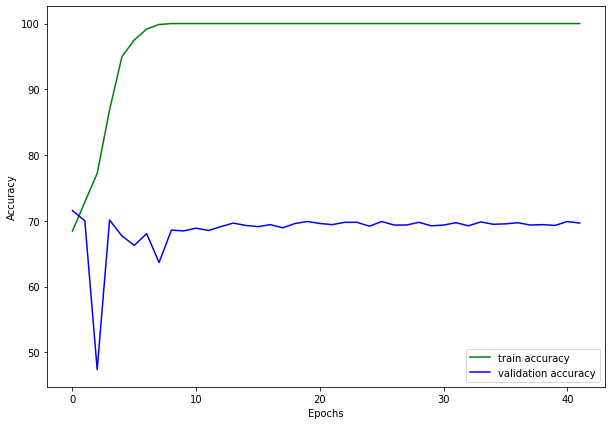

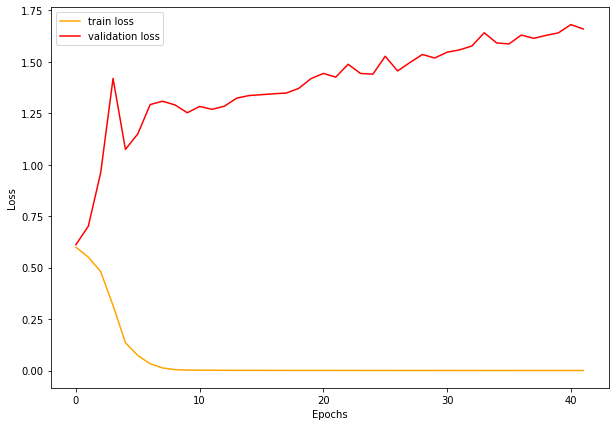

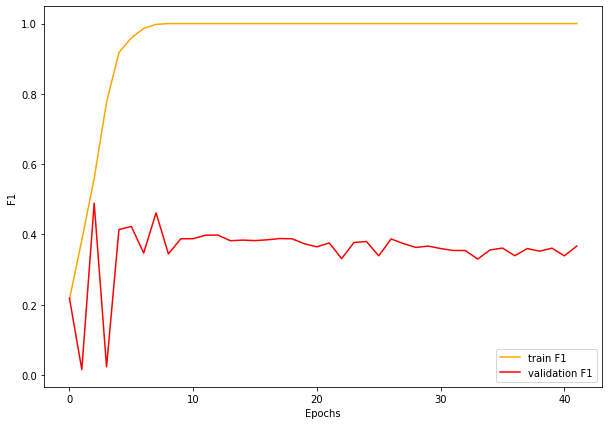

In [50]:
# accuracy plots
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
#plt.savefig('/content/drive/MyDrive/Owen/accuracy (2).png')
plt.show()
# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#plt.savefig('/content/drive/MyDrive/Owen/loss (2).png')
plt.show()
# F1 plots
plt.figure(figsize=(10, 7))
plt.plot(train_f1, color='orange', label='train F1')
plt.plot(val_f1, color='red', label='validation F1')
plt.xlabel('Epochs')
plt.ylabel('F1')
plt.legend()
#plt.savefig('/content/drive/MyDrive/Owen/F1 (2).png')
plt.show()

In [138]:
results = pd.DataFrame({'Train Accuracy':train_accuracy,
                        'Validation Accuracy':val_accuracy,
                        'Train Loss':train_loss, 
                        'Validation Loss':val_loss,
                        'Train F1':train_f1,
                        'Validation F1':val_f1}, 
                         columns=['Train Accuracy','Validation Accuracy', 'Train Loss', 'Validation Loss',
                                  'Train F1', "Validation F1"])

In [139]:
results.to_csv("/content/drive/MyDrive/Owen/final_results/second_cnn_international.csv")

In [22]:
blind_test_data = prediction_maps(xtest, ytest, tfms=0)
blindtestloader = DataLoader(blind_test_data, batch_size=200, shuffle=False)
model.load_state_dict(torch.load("/content/drive/MyDrive/Owen/international_stacked/epoch5"))
validate(model, blindtestloader)


  0%|          | 0/8 [00:00<?, ?it/s]

Validating



100%|██████████| 8/8 [00:03<00:00,  2.41it/s]
9it [00:03,  2.43it/s]                       
10it [00:04,  2.43it/s]
11it [00:04,  2.44it/s]
12it [00:04,  2.45it/s]
13it [00:05,  2.47it/s]
14it [00:05,  2.47it/s]
15it [00:06,  2.45it/s]
16it [00:06,  2.44it/s]
17it [00:06,  2.44it/s]
18it [00:07,  2.47it/s]
19it [00:07,  2.42it/s]
20it [00:08,  2.42it/s]
21it [00:23,  4.76s/it]
22it [00:26,  1.22s/it]

Val Loss: 5.1606, Val Acc: 48.60
Recall: 0.7720, Precision: 0.33, F1: 0.46
TP: 921 TN: 1124 FP: 1891 FN: 272


(5.160557329654694, 48.597908745247146, 0.4599250936329588)

# Stacked CNN after Segmentation


In [11]:
labelled_data = pd.read_csv("/content/GRDDC/labelled_data.csv", header = 0)

In [12]:
labelled_data.columns = ['image','country','oldpath','box','cracking_binary']

In [13]:
labelled_data['segmented_image_path'] = "/content/drive/MyDrive/Owen/international_images_segmented/" + labelled_data['country'].astype('str') + "/images/" + labelled_data['image'].astype('str') + ".jpg"

In [15]:
xtrain, xtest, ytrain, ytest = train_test_split(labelled_data['segmented_image_path'].values, labelled_data['cracking_binary'].values, test_size=0.2, random_state=42)

In [16]:
xtrain, xval, ytrain, yval= train_test_split(xtrain, ytrain, test_size=0.1, random_state=42)

In [17]:
class global_average(nn.Module):
    def __init__(self):
        super(global_average, self).__init__()
        self.layers = nn.Sequential(
            Conv2d(512,1, kernel_size=1),
        )

    def forward(self, x):
        x = self.layers(x)
        return x

In [18]:
class final_layers(nn.Module):
    def __init__(self):
        super(final_layers, self).__init__()
        self.layers = nn.Sigmoid()

    def forward(self, x):
        x = self.layers(x)
        p_none = 1-x
        p_none = torch.prod(p_none, dim=1)
        x = 1-p_none
        return x.squeeze()

In [19]:
device = ('cuda:0' if torch.cuda.is_available() else 'cpu')

In [20]:
resnet = models.resnet34(pretrained=False)
resnet.avgpool = global_average()
resnet.fc = final_layers()
resnet.load_state_dict(torch.load("/content/drive/MyDrive/Owen/resnet2_output_segmented/epoch38",map_location=torch.device('cpu')))
for param in resnet.parameters():
    param.requires_grad = False
if torch.cuda.is_available():
    resnet = resnet.cuda()

In [21]:
convolutions = nn.Sequential(*[list(resnet.children())[i] for i in range(9)])

In [22]:
# image dataset module
class pano_images(Dataset):
    def __init__(self, path, labels, tfms=None):
        self.X = path
        self.y = labels
        # apply augmentations
        if tfms == 0: # if validating
            self.aug = albumentations.Compose([
                albumentations.Resize(672, 672, always_apply=True),
                albumentations.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225], always_apply=True)
            ])
        else: # if training
            self.aug = albumentations.Compose([
                albumentations.Resize(672, 672, always_apply=True),
                albumentations.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225], always_apply=True)
            ])
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        image = Image.open(self.X[i])
        image = self.aug(image=np.array(image))['image']
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        image = torch.tensor(image, dtype=torch.float).unsqueeze(dim=0).to(device)
        with torch.no_grad():
          image = convolutions(image)
        image = F.interpolate(image,(224,224)).squeeze()
        label = self.y[i]
        return image.unsqueeze(dim=0), torch.tensor(label, dtype=torch.long)

In [36]:
for path in tqdm(labelled_data['segmented_image_path'],total=len(labelled_data['segmented_image_path'])):
  tensor = pano_images([path],[0])[0][0]
  newpath = "/content/drive/MyDrive/Owen/international_segmented_prediction_maps/"+ path[-16:-4] + ".pt"
  torch.save(tensor,newpath)

Streaming output truncated to the last 5000 lines.

 88%|████████▊ | 18484/21040 [1:55:20<16:42,  2.55it/s]

 88%|████████▊ | 18485/21040 [1:55:20<16:19,  2.61it/s]

 88%|████████▊ | 18486/21040 [1:55:21<16:40,  2.55it/s]

 88%|████████▊ | 18487/21040 [1:55:21<16:45,  2.54it/s]

 88%|████████▊ | 18488/21040 [1:55:21<16:36,  2.56it/s]

 88%|████████▊ | 18489/21040 [1:55:22<17:03,  2.49it/s]

 88%|████████▊ | 18490/21040 [1:55:22<16:59,  2.50it/s]

 88%|████████▊ | 18491/21040 [1:55:23<17:16,  2.46it/s]

 88%|████████▊ | 18492/21040 [1:55:23<17:36,  2.41it/s]

 88%|████████▊ | 18493/21040 [1:55:23<17:15,  2.46it/s]

 88%|████████▊ | 18494/21040 [1:55:24<16:46,  2.53it/s]

 88%|████████▊ | 18495/21040 [1:55:24<17:46,  2.39it/s]

 88%|████████▊ | 18496/21040 [1:55:25<17:57,  2.36it/s]

 88%|████████▊ | 18497/21040 [1:55:25<17:33,  2.41it/s]

 88%|████████▊ | 18498/21040 [1:55:25<16:39,  2.54it/s]

 88%|████████▊ | 18499/21040 [1:55:26<16:04,  2.63it/s]

 88%|████████▊ | 18500/21040 [1:55:2

In [37]:
class prediction_maps(Dataset):
    def __init__(self, path, labels, tfms=None):
        self.X = path
        self.y = labels

    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        tensor = torch.load(self.X[i])
        label = self.y[i]
        return tensor, torch.tensor(label, dtype=torch.long)

In [38]:
labelled_data['segmented_prediction_map'] = "/content/drive/MyDrive/Owen/international_segmented_prediction_maps/"+ labelled_data['image'].astype("str") + ".pt"

In [39]:
xtrain, xtest, ytrain, ytest = train_test_split(labelled_data['segmented_prediction_map'].values, labelled_data['cracking_binary'].values, test_size=0.2, random_state=42)

In [40]:
xtrain, xval, ytrain, yval= train_test_split(xtrain, ytrain, test_size=0.1, random_state=42)

In [42]:
train_data = prediction_maps(xtrain, ytrain, tfms=1)
test_data = prediction_maps(xval, yval, tfms=0)
 
# dataloaders
trainloader = DataLoader(train_data, batch_size=100, shuffle=True)
testloader = DataLoader(test_data, batch_size=100, shuffle=False)

(<matplotlib.axes._subplots.AxesSubplot at 0x7fbae05b15d0>,
 <matplotlib.image.AxesImage at 0x7fbae0566d10>)

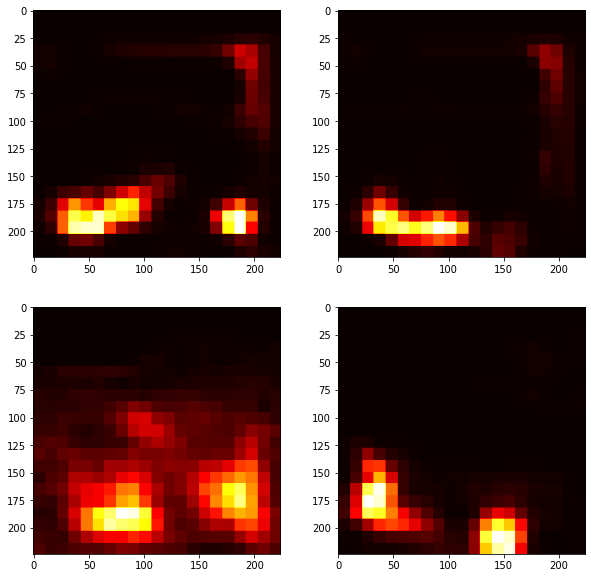

In [44]:
# visualizing images
i = 1000
plt.figure(figsize=(10,10))
plt.subplot(221), plt.imshow(1/(1+np.exp(-train_data[i][0].squeeze().cpu())), cmap='hot')
plt.subplot(222), plt.imshow(1/(1+np.exp(-train_data[i+25][0].squeeze().cpu())), cmap='hot')
plt.subplot(223), plt.imshow(1/(1+np.exp(-train_data[i+50][0].squeeze().cpu())), cmap='hot')
plt.subplot(224), plt.imshow(1/(1+np.exp(-train_data[i+75][0].squeeze().cpu())), cmap='hot')

In [45]:
class final_layers(nn.Module):
    def __init__(self):
        super(final_layers, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.layers(x)
        return x.squeeze()

In [48]:
# defining the model
model = models.resnet34(pretrained=False)
# defining the optimizer
model.fc = final_layers()
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
optimizer = Adam(model.parameters(), lr=0.00003)
# defining the loss function
criterion = BCELoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [49]:
''' SEED Everything '''
def seed_everything(SEED=42):
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True 
SEED=42
seed_everything(SEED=SEED)
''' SEED Everything '''
# set computation device
device = ('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}")

Computation device: cuda:0


In [50]:
#validation function
def validate(model, test_dataloader):
    print('Validating')
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    true_positives = 0
    true_negatives = 0
    false_positives = 0
    false_negatives = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(test_dataloader), total=int(len(test_data)/test_dataloader.batch_size)):
            data, target = data[0].to(device), data[1].to(device)
            outputs = model(data)
            loss = criterion(outputs.float(), target.float())
            val_running_loss += loss.item()
            preds = torch.round(outputs.data)
            val_running_correct += (preds == target).sum().item()
            true_positives += ((preds == 1)&(target == 1)).sum().item()
            true_negatives += ((preds == 0)&(target == 0)).sum().item()
            false_positives += ((preds == 1)&(target == 0)).sum().item()
            false_negatives += ((preds == 0)&(target == 1)).sum().item()
        
        try:
          precision = true_positives/(true_positives+false_positives)
          recall = true_positives/(true_positives+false_negatives)
          f1 = 2 * (precision*recall)/(precision+recall)
        except:
          f1 = 0
          precision = 0
          recall = 0
        val_loss = val_running_loss/int(len(test_data)/test_dataloader.batch_size)
        val_accuracy = 100. * val_running_correct/len(test_dataloader.dataset)
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}')
        print(f"Recall: {recall:.4f}, Precision: {precision:.2f}, F1: {f1:.2f}")
        print("TP:",true_positives,"TN:", true_negatives,"FP:", false_positives,"FN:", false_negatives)
        
        return val_loss, val_accuracy, f1

In [51]:
# training function
def fit(model, train_dataloader):
    print('Training')
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    true_positives = 0
    true_negatives = 0
    false_positives = 0
    false_negatives = 0
    for i, data in tqdm(enumerate(train_dataloader), total=int(len(train_data)/train_dataloader.batch_size)):
        data, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs.float(), target.float())
        train_running_loss += loss.item()
        preds = torch.round(outputs.data)
        train_running_correct += (preds == target).sum().item()
        true_positives += ((preds == 1)&(target == 1)).sum().item()
        true_negatives += ((preds == 0)&(target == 0)).sum().item()
        false_positives += ((preds == 1)&(target == 0)).sum().item()
        false_negatives += ((preds == 0)&(target == 1)).sum().item()
        loss.backward()
        optimizer.step()
    try:
      precision = true_positives/(true_positives+false_positives)
      recall = true_positives/(true_positives+false_negatives)
      f1 = 2 * (precision*recall)/(precision+recall)
    except:
      precision = 0
      recall = 0
      f1 = 0
    train_loss = train_running_loss/int(len(train_data)/train_dataloader.batch_size)
    train_accuracy = 100. * train_running_correct/len(train_dataloader.dataset)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}")
    print(f"Recall: {recall:.4f}, Precision: {precision:.2f}, F1: {f1:.2f}")
    
    return train_loss, train_accuracy, f1

In [52]:
train_loss , train_accuracy , train_f1 = [], [], []
val_loss , val_accuracy, val_f1 = [], [], []
start = time.time()
epochs = 75
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_accuracy, train_epoch_f1 = fit(model, trainloader)
    val_epoch_loss, val_epoch_accuracy, val_epoch_f1 = validate(model, testloader)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    train_f1.append(train_epoch_f1)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
    val_f1.append(val_epoch_f1)
    path = "/content/drive/MyDrive/Owen/international_stacked_segmented_output/epoch" + str(epoch)
    torch.save(model.state_dict(), path)
end = time.time()
print(f"{(end-start)/60:.3f} minutes")



  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 1 of 75
Training




  1%|          | 1/151 [00:00<01:00,  2.47it/s]

  1%|▏         | 2/151 [00:00<00:55,  2.66it/s]

  2%|▏         | 3/151 [00:01<00:56,  2.63it/s]

  3%|▎         | 4/151 [00:01<00:56,  2.62it/s]

  3%|▎         | 5/151 [00:01<00:55,  2.64it/s]

  4%|▍         | 6/151 [00:02<00:54,  2.66it/s]

  5%|▍         | 7/151 [00:02<00:54,  2.66it/s]

  5%|▌         | 8/151 [00:02<00:53,  2.66it/s]

  6%|▌         | 9/151 [00:03<00:53,  2.66it/s]

  7%|▋         | 10/151 [00:03<00:52,  2.68it/s]

  7%|▋         | 11/151 [00:04<00:52,  2.69it/s]

  8%|▊         | 12/151 [00:04<00:51,  2.67it/s]

  9%|▊         | 13/151 [00:04<00:52,  2.65it/s]

  9%|▉         | 14/151 [00:05<00:51,  2.65it/s]

 10%|▉         | 15/151 [00:05<00:51,  2.65it/s]

 11%|█         | 16/151 [00:05<00:50,  2.65it/s]

 11%|█▏        | 17/151 [00:06<00:50,  2.65it/s]

 12%|█▏        | 18/151 [00:06<00:50,  2.64it/s]

 13%|█▎        | 19/151 [00:07<00:50,  2.63it/s]

 13%|█▎        | 20/151 [00:07<00:49,  2.66it/s]

 14%|█▍

Train Loss: 0.6033, Train Acc: 69.07
Recall: 0.1075, Precision: 0.48, F1: 0.18
Validating




  6%|▋         | 1/16 [00:00<00:03,  4.53it/s]

 12%|█▎        | 2/16 [00:00<00:03,  4.50it/s]

 19%|█▉        | 3/16 [00:00<00:02,  4.52it/s]

 25%|██▌       | 4/16 [00:00<00:02,  4.54it/s]

 31%|███▏      | 5/16 [00:01<00:02,  4.52it/s]

 38%|███▊      | 6/16 [00:01<00:02,  4.55it/s]

 44%|████▍     | 7/16 [00:01<00:01,  4.55it/s]

 50%|█████     | 8/16 [00:01<00:01,  4.62it/s]

 56%|█████▋    | 9/16 [00:01<00:01,  4.50it/s]

 62%|██████▎   | 10/16 [00:02<00:01,  4.48it/s]

 69%|██████▉   | 11/16 [00:02<00:01,  4.52it/s]

 75%|███████▌  | 12/16 [00:02<00:00,  4.49it/s]

 81%|████████▏ | 13/16 [00:02<00:00,  4.49it/s]

 88%|████████▊ | 14/16 [00:03<00:00,  4.45it/s]

 94%|█████████▍| 15/16 [00:03<00:00,  4.50it/s]

100%|██████████| 16/16 [00:03<00:00,  4.53it/s]

17it [00:03,  4.30it/s]


Val Loss: 0.6269, Val Acc: 70.19
Recall: 0.0688, Precision: 0.56, F1: 0.12
TP: 35 TN: 1147 FP: 28 FN: 474




  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 2 of 75
Training




  1%|          | 1/151 [00:00<00:46,  3.25it/s]

  1%|▏         | 2/151 [00:00<00:48,  3.06it/s]

  2%|▏         | 3/151 [00:01<00:51,  2.88it/s]

  3%|▎         | 4/151 [00:01<00:52,  2.81it/s]

  3%|▎         | 5/151 [00:01<00:53,  2.75it/s]

  4%|▍         | 6/151 [00:02<00:53,  2.71it/s]

  5%|▍         | 7/151 [00:02<00:53,  2.69it/s]

  5%|▌         | 8/151 [00:02<00:53,  2.67it/s]

  6%|▌         | 9/151 [00:03<00:53,  2.66it/s]

  7%|▋         | 10/151 [00:03<00:53,  2.65it/s]

  7%|▋         | 11/151 [00:04<00:52,  2.65it/s]

  8%|▊         | 12/151 [00:04<00:52,  2.66it/s]

  9%|▊         | 13/151 [00:04<00:52,  2.65it/s]

  9%|▉         | 14/151 [00:05<00:51,  2.66it/s]

 10%|▉         | 15/151 [00:05<00:50,  2.67it/s]

 11%|█         | 16/151 [00:05<00:50,  2.66it/s]

 11%|█▏        | 17/151 [00:06<00:49,  2.69it/s]

 12%|█▏        | 18/151 [00:06<00:49,  2.68it/s]

 13%|█▎        | 19/151 [00:07<00:49,  2.68it/s]

 13%|█▎        | 20/151 [00:07<00:48,  2.70it/s]

 14%|█▍

Train Loss: 0.5666, Train Acc: 71.26
Recall: 0.2173, Precision: 0.58, F1: 0.32
Validating




  6%|▋         | 1/16 [00:00<00:03,  4.10it/s]

 12%|█▎        | 2/16 [00:00<00:03,  4.21it/s]

 19%|█▉        | 3/16 [00:00<00:03,  4.23it/s]

 25%|██▌       | 4/16 [00:00<00:02,  4.37it/s]

 31%|███▏      | 5/16 [00:01<00:02,  4.45it/s]

 38%|███▊      | 6/16 [00:01<00:02,  4.45it/s]

 44%|████▍     | 7/16 [00:01<00:02,  4.49it/s]

 50%|█████     | 8/16 [00:01<00:01,  4.52it/s]

 56%|█████▋    | 9/16 [00:02<00:01,  4.49it/s]

 62%|██████▎   | 10/16 [00:02<00:01,  4.47it/s]

 69%|██████▉   | 11/16 [00:02<00:01,  4.49it/s]

 75%|███████▌  | 12/16 [00:02<00:00,  4.53it/s]

 81%|████████▏ | 13/16 [00:02<00:00,  4.54it/s]

 88%|████████▊ | 14/16 [00:03<00:00,  4.56it/s]

 94%|█████████▍| 15/16 [00:03<00:00,  4.60it/s]

100%|██████████| 16/16 [00:03<00:00,  4.60it/s]

17it [00:03,  4.55it/s]


Val Loss: 0.6294, Val Acc: 68.88
Recall: 0.2574, Precision: 0.47, F1: 0.33
TP: 131 TN: 1029 FP: 146 FN: 378




  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 3 of 75
Training




  1%|          | 1/151 [00:00<00:46,  3.25it/s]

  1%|▏         | 2/151 [00:00<00:49,  3.03it/s]

  2%|▏         | 3/151 [00:01<00:51,  2.89it/s]

  3%|▎         | 4/151 [00:01<00:52,  2.78it/s]

  3%|▎         | 5/151 [00:01<00:53,  2.71it/s]

  4%|▍         | 6/151 [00:02<00:54,  2.66it/s]

  5%|▍         | 7/151 [00:02<00:54,  2.63it/s]

  5%|▌         | 8/151 [00:03<00:54,  2.63it/s]

  6%|▌         | 9/151 [00:03<00:53,  2.64it/s]

  7%|▋         | 10/151 [00:03<00:53,  2.63it/s]

  7%|▋         | 11/151 [00:04<00:53,  2.62it/s]

  8%|▊         | 12/151 [00:04<00:53,  2.60it/s]

  9%|▊         | 13/151 [00:04<00:52,  2.61it/s]

  9%|▉         | 14/151 [00:05<00:52,  2.60it/s]

 10%|▉         | 15/151 [00:05<00:52,  2.60it/s]

 11%|█         | 16/151 [00:06<00:51,  2.62it/s]

 11%|█▏        | 17/151 [00:06<00:51,  2.59it/s]

 12%|█▏        | 18/151 [00:06<00:51,  2.60it/s]

 13%|█▎        | 19/151 [00:07<00:50,  2.61it/s]

 13%|█▎        | 20/151 [00:07<00:50,  2.57it/s]

 14%|█▍

Train Loss: 0.5179, Train Acc: 75.04
Recall: 0.3863, Precision: 0.66, F1: 0.49
Validating




  6%|▋         | 1/16 [00:00<00:03,  4.12it/s]

 12%|█▎        | 2/16 [00:00<00:03,  4.25it/s]

 19%|█▉        | 3/16 [00:00<00:03,  4.31it/s]

 25%|██▌       | 4/16 [00:00<00:02,  4.28it/s]

 31%|███▏      | 5/16 [00:01<00:02,  4.35it/s]

 38%|███▊      | 6/16 [00:01<00:02,  4.41it/s]

 44%|████▍     | 7/16 [00:01<00:02,  4.44it/s]

 50%|█████     | 8/16 [00:01<00:01,  4.46it/s]

 56%|█████▋    | 9/16 [00:02<00:01,  4.42it/s]

 62%|██████▎   | 10/16 [00:02<00:01,  4.44it/s]

 69%|██████▉   | 11/16 [00:02<00:01,  4.40it/s]

 75%|███████▌  | 12/16 [00:02<00:00,  4.45it/s]

 81%|████████▏ | 13/16 [00:02<00:00,  4.40it/s]

 88%|████████▊ | 14/16 [00:03<00:00,  4.47it/s]

 94%|█████████▍| 15/16 [00:03<00:00,  4.47it/s]

100%|██████████| 16/16 [00:03<00:00,  4.50it/s]

17it [00:03,  4.48it/s]


Val Loss: 0.6428, Val Acc: 68.76
Recall: 0.3261, Precision: 0.48, F1: 0.39
TP: 166 TN: 992 FP: 183 FN: 343




  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 4 of 75
Training




  1%|          | 1/151 [00:00<00:46,  3.24it/s]

  1%|▏         | 2/151 [00:00<00:54,  2.72it/s]

  2%|▏         | 3/151 [00:01<00:55,  2.68it/s]

  3%|▎         | 4/151 [00:01<00:55,  2.65it/s]

  3%|▎         | 5/151 [00:01<00:55,  2.61it/s]

  4%|▍         | 6/151 [00:02<00:55,  2.62it/s]

  5%|▍         | 7/151 [00:02<00:55,  2.60it/s]

  5%|▌         | 8/151 [00:03<00:54,  2.60it/s]

  6%|▌         | 9/151 [00:03<00:54,  2.60it/s]

  7%|▋         | 10/151 [00:03<00:53,  2.62it/s]

  7%|▋         | 11/151 [00:04<00:53,  2.61it/s]

  8%|▊         | 12/151 [00:04<00:52,  2.63it/s]

  9%|▊         | 13/151 [00:05<00:52,  2.61it/s]

  9%|▉         | 14/151 [00:05<00:52,  2.61it/s]

 10%|▉         | 15/151 [00:05<00:52,  2.61it/s]

 11%|█         | 16/151 [00:06<00:52,  2.60it/s]

 11%|█▏        | 17/151 [00:06<00:51,  2.61it/s]

 12%|█▏        | 18/151 [00:06<00:51,  2.57it/s]

 13%|█▎        | 19/151 [00:07<00:51,  2.59it/s]

 13%|█▎        | 20/151 [00:07<00:50,  2.60it/s]

 14%|█▍

Train Loss: 0.4106, Train Acc: 82.12
Recall: 0.6255, Precision: 0.75, F1: 0.68
Validating




  6%|▋         | 1/16 [00:00<00:03,  4.09it/s]

 12%|█▎        | 2/16 [00:00<00:03,  4.18it/s]

 19%|█▉        | 3/16 [00:00<00:03,  4.24it/s]

 25%|██▌       | 4/16 [00:00<00:02,  4.32it/s]

 31%|███▏      | 5/16 [00:01<00:02,  4.40it/s]

 38%|███▊      | 6/16 [00:01<00:02,  4.42it/s]

 44%|████▍     | 7/16 [00:01<00:02,  4.43it/s]

 50%|█████     | 8/16 [00:01<00:01,  4.47it/s]

 56%|█████▋    | 9/16 [00:02<00:01,  4.48it/s]

 62%|██████▎   | 10/16 [00:02<00:01,  4.49it/s]

 69%|██████▉   | 11/16 [00:02<00:01,  4.60it/s]

 75%|███████▌  | 12/16 [00:02<00:00,  4.53it/s]

 81%|████████▏ | 13/16 [00:02<00:00,  4.52it/s]

 88%|████████▊ | 14/16 [00:03<00:00,  4.46it/s]

 94%|█████████▍| 15/16 [00:03<00:00,  4.47it/s]

100%|██████████| 16/16 [00:03<00:00,  4.51it/s]

17it [00:03,  4.51it/s]


Val Loss: 0.8003, Val Acc: 61.76
Recall: 0.5678, Precision: 0.41, F1: 0.47
TP: 289 TN: 751 FP: 424 FN: 220




  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 5 of 75
Training




  1%|          | 1/151 [00:00<00:46,  3.26it/s]

  1%|▏         | 2/151 [00:00<00:49,  3.02it/s]

  2%|▏         | 3/151 [00:01<00:50,  2.90it/s]

  3%|▎         | 4/151 [00:01<00:52,  2.78it/s]

  3%|▎         | 5/151 [00:01<00:53,  2.73it/s]

  4%|▍         | 6/151 [00:02<00:54,  2.68it/s]

  5%|▍         | 7/151 [00:02<00:54,  2.66it/s]

  5%|▌         | 8/151 [00:03<00:54,  2.64it/s]

  6%|▌         | 9/151 [00:03<00:54,  2.62it/s]

  7%|▋         | 10/151 [00:03<00:54,  2.61it/s]

  7%|▋         | 11/151 [00:04<00:53,  2.62it/s]

  8%|▊         | 12/151 [00:04<00:53,  2.62it/s]

  9%|▊         | 13/151 [00:04<00:52,  2.61it/s]

  9%|▉         | 14/151 [00:05<00:52,  2.61it/s]

 10%|▉         | 15/151 [00:05<00:52,  2.60it/s]

 11%|█         | 16/151 [00:06<00:51,  2.60it/s]

 11%|█▏        | 17/151 [00:06<00:51,  2.59it/s]

 12%|█▏        | 18/151 [00:06<00:51,  2.57it/s]

 13%|█▎        | 19/151 [00:07<00:51,  2.58it/s]

 13%|█▎        | 20/151 [00:07<00:50,  2.59it/s]

 14%|█▍

Train Loss: 0.2447, Train Acc: 90.09
Recall: 0.8064, Precision: 0.86, F1: 0.83
Validating




  6%|▋         | 1/16 [00:00<00:03,  4.27it/s]

 12%|█▎        | 2/16 [00:00<00:03,  4.39it/s]

 19%|█▉        | 3/16 [00:00<00:02,  4.49it/s]

 25%|██▌       | 4/16 [00:00<00:02,  4.51it/s]

 31%|███▏      | 5/16 [00:01<00:02,  4.50it/s]

 38%|███▊      | 6/16 [00:01<00:02,  4.58it/s]

 44%|████▍     | 7/16 [00:01<00:01,  4.64it/s]

 50%|█████     | 8/16 [00:01<00:01,  4.64it/s]

 56%|█████▋    | 9/16 [00:01<00:01,  4.62it/s]

 62%|██████▎   | 10/16 [00:02<00:01,  4.65it/s]

 69%|██████▉   | 11/16 [00:02<00:01,  4.70it/s]

 75%|███████▌  | 12/16 [00:02<00:00,  4.65it/s]

 81%|████████▏ | 13/16 [00:02<00:00,  4.70it/s]

 88%|████████▊ | 14/16 [00:03<00:00,  4.71it/s]

 94%|█████████▍| 15/16 [00:03<00:00,  4.74it/s]

100%|██████████| 16/16 [00:03<00:00,  4.80it/s]

17it [00:03,  4.71it/s]


Val Loss: 1.0551, Val Acc: 66.57
Recall: 0.2613, Precision: 0.42, F1: 0.32
TP: 133 TN: 988 FP: 187 FN: 376




  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 6 of 75
Training




  1%|          | 1/151 [00:00<00:44,  3.36it/s]

  1%|▏         | 2/151 [00:00<00:47,  3.11it/s]

  2%|▏         | 3/151 [00:01<00:50,  2.92it/s]

  3%|▎         | 4/151 [00:01<00:51,  2.84it/s]

  3%|▎         | 5/151 [00:01<00:51,  2.81it/s]

  4%|▍         | 6/151 [00:02<00:52,  2.78it/s]

  5%|▍         | 7/151 [00:02<00:52,  2.73it/s]

  5%|▌         | 8/151 [00:02<00:52,  2.71it/s]

  6%|▌         | 9/151 [00:03<00:53,  2.67it/s]

  7%|▋         | 10/151 [00:03<00:52,  2.68it/s]

  7%|▋         | 11/151 [00:04<00:52,  2.68it/s]

  8%|▊         | 12/151 [00:04<00:51,  2.69it/s]

  9%|▊         | 13/151 [00:04<00:51,  2.70it/s]

  9%|▉         | 14/151 [00:05<00:50,  2.69it/s]

 10%|▉         | 15/151 [00:05<00:50,  2.69it/s]

 11%|█         | 16/151 [00:05<00:50,  2.68it/s]

 11%|█▏        | 17/151 [00:06<00:50,  2.67it/s]

 12%|█▏        | 18/151 [00:06<00:50,  2.66it/s]

 13%|█▎        | 19/151 [00:07<00:49,  2.67it/s]

 13%|█▎        | 20/151 [00:07<00:48,  2.69it/s]

 14%|█▍

Train Loss: 0.1259, Train Acc: 95.52
Recall: 0.9205, Precision: 0.93, F1: 0.93
Validating




  6%|▋         | 1/16 [00:00<00:03,  4.28it/s]

 12%|█▎        | 2/16 [00:00<00:03,  4.31it/s]

 19%|█▉        | 3/16 [00:00<00:02,  4.39it/s]

 25%|██▌       | 4/16 [00:00<00:02,  4.49it/s]

 31%|███▏      | 5/16 [00:01<00:02,  4.62it/s]

 38%|███▊      | 6/16 [00:01<00:02,  4.69it/s]

 44%|████▍     | 7/16 [00:01<00:01,  4.73it/s]

 50%|█████     | 8/16 [00:01<00:01,  4.71it/s]

 56%|█████▋    | 9/16 [00:01<00:01,  4.78it/s]

 62%|██████▎   | 10/16 [00:02<00:01,  4.80it/s]

 69%|██████▉   | 11/16 [00:02<00:01,  4.72it/s]

 75%|███████▌  | 12/16 [00:02<00:00,  4.65it/s]

 81%|████████▏ | 13/16 [00:02<00:00,  4.55it/s]

 88%|████████▊ | 14/16 [00:03<00:00,  4.52it/s]

 94%|█████████▍| 15/16 [00:03<00:00,  4.56it/s]

100%|██████████| 16/16 [00:03<00:00,  4.55it/s]

17it [00:03,  4.65it/s]


Val Loss: 1.1480, Val Acc: 64.43
Recall: 0.4361, Precision: 0.42, F1: 0.43
TP: 222 TN: 863 FP: 312 FN: 287




  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 7 of 75
Training




  1%|          | 1/151 [00:00<00:44,  3.35it/s]

  1%|▏         | 2/151 [00:00<00:48,  3.08it/s]

  2%|▏         | 3/151 [00:01<00:50,  2.93it/s]

  3%|▎         | 4/151 [00:01<00:52,  2.83it/s]

  3%|▎         | 5/151 [00:01<00:52,  2.76it/s]

  4%|▍         | 6/151 [00:02<00:53,  2.74it/s]

  5%|▍         | 7/151 [00:02<00:53,  2.69it/s]

  5%|▌         | 8/151 [00:02<00:53,  2.68it/s]

  6%|▌         | 9/151 [00:03<00:52,  2.69it/s]

  7%|▋         | 10/151 [00:03<00:52,  2.67it/s]

  7%|▋         | 11/151 [00:04<00:52,  2.67it/s]

  8%|▊         | 12/151 [00:04<00:51,  2.68it/s]

  9%|▊         | 13/151 [00:04<00:51,  2.68it/s]

  9%|▉         | 14/151 [00:05<00:50,  2.70it/s]

 10%|▉         | 15/151 [00:05<00:51,  2.67it/s]

 11%|█         | 16/151 [00:05<00:51,  2.65it/s]

 11%|█▏        | 17/151 [00:06<00:50,  2.65it/s]

 12%|█▏        | 18/151 [00:06<00:50,  2.64it/s]

 13%|█▎        | 19/151 [00:07<00:50,  2.63it/s]

 13%|█▎        | 20/151 [00:07<00:49,  2.63it/s]

 14%|█▍

Train Loss: 0.0980, Train Acc: 96.35
Recall: 0.9298, Precision: 0.95, F1: 0.94
Validating




  6%|▋         | 1/16 [00:00<00:03,  4.11it/s]

 12%|█▎        | 2/16 [00:00<00:03,  4.21it/s]

 19%|█▉        | 3/16 [00:00<00:03,  4.30it/s]

 25%|██▌       | 4/16 [00:00<00:02,  4.37it/s]

 31%|███▏      | 5/16 [00:01<00:02,  4.40it/s]

 38%|███▊      | 6/16 [00:01<00:02,  4.41it/s]

 44%|████▍     | 7/16 [00:01<00:02,  4.41it/s]

 50%|█████     | 8/16 [00:01<00:01,  4.44it/s]

 56%|█████▋    | 9/16 [00:02<00:01,  4.45it/s]

 62%|██████▎   | 10/16 [00:02<00:01,  4.56it/s]

 69%|██████▉   | 11/16 [00:02<00:01,  4.60it/s]

 75%|███████▌  | 12/16 [00:02<00:00,  4.61it/s]

 81%|████████▏ | 13/16 [00:02<00:00,  4.61it/s]

 88%|████████▊ | 14/16 [00:03<00:00,  4.62it/s]

 94%|█████████▍| 15/16 [00:03<00:00,  4.66it/s]

100%|██████████| 16/16 [00:03<00:00,  4.68it/s]

17it [00:03,  4.59it/s]


Val Loss: 1.6867, Val Acc: 55.52
Recall: 0.6582, Precision: 0.37, F1: 0.47
TP: 335 TN: 600 FP: 575 FN: 174




  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 8 of 75
Training




  1%|          | 1/151 [00:00<00:43,  3.43it/s]

  1%|▏         | 2/151 [00:00<00:46,  3.18it/s]

  2%|▏         | 3/151 [00:01<00:49,  2.99it/s]

  3%|▎         | 4/151 [00:01<00:51,  2.87it/s]

  3%|▎         | 5/151 [00:01<00:52,  2.79it/s]

  4%|▍         | 6/151 [00:02<00:52,  2.75it/s]

  5%|▍         | 7/151 [00:02<00:53,  2.71it/s]

  5%|▌         | 8/151 [00:02<00:52,  2.71it/s]

  6%|▌         | 9/151 [00:03<00:52,  2.70it/s]

  7%|▋         | 10/151 [00:03<00:52,  2.70it/s]

  7%|▋         | 11/151 [00:04<00:52,  2.66it/s]

  8%|▊         | 12/151 [00:04<00:52,  2.64it/s]

  9%|▊         | 13/151 [00:04<00:51,  2.67it/s]

  9%|▉         | 14/151 [00:05<00:50,  2.69it/s]

 10%|▉         | 15/151 [00:05<00:50,  2.70it/s]

 11%|█         | 16/151 [00:05<00:50,  2.68it/s]

 11%|█▏        | 17/151 [00:06<00:50,  2.66it/s]

 12%|█▏        | 18/151 [00:06<00:50,  2.61it/s]

 13%|█▎        | 19/151 [00:07<00:51,  2.56it/s]

 13%|█▎        | 20/151 [00:07<00:51,  2.55it/s]

 14%|█▍

Train Loss: 0.0569, Train Acc: 98.03
Recall: 0.9595, Precision: 0.98, F1: 0.97
Validating




  6%|▋         | 1/16 [00:00<00:03,  4.27it/s]

 12%|█▎        | 2/16 [00:00<00:03,  4.34it/s]

 19%|█▉        | 3/16 [00:00<00:02,  4.38it/s]

 25%|██▌       | 4/16 [00:00<00:02,  4.41it/s]

 31%|███▏      | 5/16 [00:01<00:02,  4.44it/s]

 38%|███▊      | 6/16 [00:01<00:02,  4.49it/s]

 44%|████▍     | 7/16 [00:01<00:02,  4.48it/s]

 50%|█████     | 8/16 [00:01<00:01,  4.52it/s]

 56%|█████▋    | 9/16 [00:02<00:01,  4.43it/s]

 62%|██████▎   | 10/16 [00:02<00:01,  4.37it/s]

 69%|██████▉   | 11/16 [00:02<00:01,  4.37it/s]

 75%|███████▌  | 12/16 [00:02<00:00,  4.46it/s]

 81%|████████▏ | 13/16 [00:02<00:00,  4.47it/s]

 88%|████████▊ | 14/16 [00:03<00:00,  4.44it/s]

 94%|█████████▍| 15/16 [00:03<00:00,  4.46it/s]

100%|██████████| 16/16 [00:03<00:00,  4.50it/s]

17it [00:03,  4.51it/s]


Val Loss: 1.3204, Val Acc: 67.52
Recall: 0.3281, Precision: 0.45, F1: 0.38
TP: 167 TN: 970 FP: 205 FN: 342




  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 9 of 75
Training




  1%|          | 1/151 [00:00<00:45,  3.27it/s]

  1%|▏         | 2/151 [00:00<00:48,  3.05it/s]

  2%|▏         | 3/151 [00:01<00:51,  2.90it/s]

  3%|▎         | 4/151 [00:01<00:52,  2.81it/s]

  3%|▎         | 5/151 [00:01<00:53,  2.74it/s]

  4%|▍         | 6/151 [00:02<00:53,  2.69it/s]

  5%|▍         | 7/151 [00:02<00:54,  2.66it/s]

  5%|▌         | 8/151 [00:02<00:53,  2.65it/s]

  6%|▌         | 9/151 [00:03<00:53,  2.66it/s]

  7%|▋         | 10/151 [00:03<00:52,  2.69it/s]

  7%|▋         | 11/151 [00:04<00:52,  2.66it/s]

  8%|▊         | 12/151 [00:04<00:52,  2.65it/s]

  9%|▊         | 13/151 [00:04<00:51,  2.68it/s]

  9%|▉         | 14/151 [00:05<00:51,  2.68it/s]

 10%|▉         | 15/151 [00:05<00:51,  2.65it/s]

 11%|█         | 16/151 [00:05<00:50,  2.66it/s]

 11%|█▏        | 17/151 [00:06<00:50,  2.65it/s]

 12%|█▏        | 18/151 [00:06<00:50,  2.63it/s]

 13%|█▎        | 19/151 [00:07<00:50,  2.64it/s]

 13%|█▎        | 20/151 [00:07<00:49,  2.64it/s]

 14%|█▍

Train Loss: 0.0421, Train Acc: 98.68
Recall: 0.9699, Precision: 0.99, F1: 0.98
Validating




  6%|▋         | 1/16 [00:00<00:03,  3.83it/s]

 12%|█▎        | 2/16 [00:00<00:03,  4.05it/s]

 19%|█▉        | 3/16 [00:00<00:03,  4.17it/s]

 25%|██▌       | 4/16 [00:00<00:02,  4.28it/s]

 31%|███▏      | 5/16 [00:01<00:02,  4.39it/s]

 38%|███▊      | 6/16 [00:01<00:02,  4.44it/s]

 44%|████▍     | 7/16 [00:01<00:02,  4.43it/s]

 50%|█████     | 8/16 [00:01<00:01,  4.50it/s]

 56%|█████▋    | 9/16 [00:02<00:01,  4.51it/s]

 62%|██████▎   | 10/16 [00:02<00:01,  4.57it/s]

 69%|██████▉   | 11/16 [00:02<00:01,  4.50it/s]

 75%|███████▌  | 12/16 [00:02<00:00,  4.51it/s]

 81%|████████▏ | 13/16 [00:02<00:00,  4.48it/s]

 88%|████████▊ | 14/16 [00:03<00:00,  4.51it/s]

 94%|█████████▍| 15/16 [00:03<00:00,  4.44it/s]

100%|██████████| 16/16 [00:03<00:00,  4.44it/s]

17it [00:03,  4.50it/s]


Val Loss: 1.3857, Val Acc: 68.76
Recall: 0.3124, Precision: 0.47, F1: 0.38
TP: 159 TN: 999 FP: 176 FN: 350




  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 10 of 75
Training




  1%|          | 1/151 [00:00<00:48,  3.10it/s]

  1%|▏         | 2/151 [00:00<00:50,  2.94it/s]

  2%|▏         | 3/151 [00:01<00:52,  2.83it/s]

  3%|▎         | 4/151 [00:01<00:53,  2.76it/s]

  3%|▎         | 5/151 [00:01<00:53,  2.71it/s]

  4%|▍         | 6/151 [00:02<00:54,  2.68it/s]

  5%|▍         | 7/151 [00:02<00:54,  2.65it/s]

  5%|▌         | 8/151 [00:03<00:54,  2.63it/s]

  6%|▌         | 9/151 [00:03<00:54,  2.62it/s]

  7%|▋         | 10/151 [00:03<00:53,  2.62it/s]

  7%|▋         | 11/151 [00:04<00:53,  2.61it/s]

  8%|▊         | 12/151 [00:04<00:53,  2.59it/s]

  9%|▊         | 13/151 [00:04<00:53,  2.59it/s]

  9%|▉         | 14/151 [00:05<00:53,  2.58it/s]

 10%|▉         | 15/151 [00:05<00:52,  2.58it/s]

 11%|█         | 16/151 [00:06<00:52,  2.59it/s]

 11%|█▏        | 17/151 [00:06<00:51,  2.60it/s]

 12%|█▏        | 18/151 [00:06<00:50,  2.62it/s]

 13%|█▎        | 19/151 [00:07<00:49,  2.65it/s]

 13%|█▎        | 20/151 [00:07<00:49,  2.66it/s]

 14%|█▍

Train Loss: 0.0339, Train Acc: 98.82
Recall: 0.9731, Precision: 0.99, F1: 0.98
Validating




  6%|▋         | 1/16 [00:00<00:03,  4.23it/s]

 12%|█▎        | 2/16 [00:00<00:03,  4.31it/s]

 19%|█▉        | 3/16 [00:00<00:02,  4.43it/s]

 25%|██▌       | 4/16 [00:00<00:02,  4.48it/s]

 31%|███▏      | 5/16 [00:01<00:02,  4.55it/s]

 38%|███▊      | 6/16 [00:01<00:02,  4.58it/s]

 44%|████▍     | 7/16 [00:01<00:01,  4.60it/s]

 50%|█████     | 8/16 [00:01<00:01,  4.58it/s]

 56%|█████▋    | 9/16 [00:01<00:01,  4.63it/s]

 62%|██████▎   | 10/16 [00:02<00:01,  4.65it/s]

 69%|██████▉   | 11/16 [00:02<00:01,  4.53it/s]

 75%|███████▌  | 12/16 [00:02<00:00,  4.59it/s]

 81%|████████▏ | 13/16 [00:02<00:00,  4.61it/s]

 88%|████████▊ | 14/16 [00:03<00:00,  4.59it/s]

 94%|█████████▍| 15/16 [00:03<00:00,  4.64it/s]

100%|██████████| 16/16 [00:03<00:00,  4.71it/s]

17it [00:03,  4.65it/s]


Val Loss: 1.4720, Val Acc: 69.36
Recall: 0.2888, Precision: 0.49, F1: 0.36
TP: 147 TN: 1021 FP: 154 FN: 362




  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 11 of 75
Training




  1%|          | 1/151 [00:00<00:44,  3.37it/s]

  1%|▏         | 2/151 [00:00<00:47,  3.14it/s]

  2%|▏         | 3/151 [00:01<00:49,  2.97it/s]

  3%|▎         | 4/151 [00:01<00:51,  2.85it/s]

  3%|▎         | 5/151 [00:01<00:52,  2.77it/s]

  4%|▍         | 6/151 [00:02<00:53,  2.70it/s]

  5%|▍         | 7/151 [00:02<00:53,  2.68it/s]

  5%|▌         | 8/151 [00:02<00:53,  2.68it/s]

  6%|▌         | 9/151 [00:03<00:52,  2.69it/s]

  7%|▋         | 10/151 [00:03<00:53,  2.66it/s]

  7%|▋         | 11/151 [00:04<00:52,  2.67it/s]

  8%|▊         | 12/151 [00:04<00:52,  2.65it/s]

  9%|▊         | 13/151 [00:04<00:52,  2.64it/s]

  9%|▉         | 14/151 [00:05<00:51,  2.64it/s]

 10%|▉         | 15/151 [00:05<00:51,  2.65it/s]

 11%|█         | 16/151 [00:05<00:50,  2.66it/s]

 11%|█▏        | 17/151 [00:06<00:50,  2.67it/s]

 12%|█▏        | 18/151 [00:06<00:49,  2.68it/s]

 13%|█▎        | 19/151 [00:07<00:49,  2.67it/s]

 13%|█▎        | 20/151 [00:07<00:48,  2.67it/s]

 14%|█▍

Train Loss: 0.0363, Train Acc: 98.83
Recall: 0.9733, Precision: 0.99, F1: 0.98
Validating




  6%|▋         | 1/16 [00:00<00:03,  4.30it/s]

 12%|█▎        | 2/16 [00:00<00:03,  4.38it/s]

 19%|█▉        | 3/16 [00:00<00:03,  4.25it/s]

 25%|██▌       | 4/16 [00:00<00:02,  4.28it/s]

 31%|███▏      | 5/16 [00:01<00:02,  4.25it/s]

 38%|███▊      | 6/16 [00:01<00:02,  4.31it/s]

 44%|████▍     | 7/16 [00:01<00:02,  4.38it/s]

 50%|█████     | 8/16 [00:01<00:01,  4.43it/s]

 56%|█████▋    | 9/16 [00:02<00:01,  4.44it/s]

 62%|██████▎   | 10/16 [00:02<00:01,  4.51it/s]

 69%|██████▉   | 11/16 [00:02<00:01,  4.56it/s]

 75%|███████▌  | 12/16 [00:02<00:00,  4.53it/s]

 81%|████████▏ | 13/16 [00:02<00:00,  4.52it/s]

 88%|████████▊ | 14/16 [00:03<00:00,  4.57it/s]

 94%|█████████▍| 15/16 [00:03<00:00,  4.61it/s]

100%|██████████| 16/16 [00:03<00:00,  4.64it/s]

17it [00:03,  4.52it/s]


Val Loss: 1.6172, Val Acc: 67.76
Recall: 0.2043, Precision: 0.43, F1: 0.28
TP: 104 TN: 1037 FP: 138 FN: 405




  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 12 of 75
Training




  1%|          | 1/151 [00:00<00:45,  3.26it/s]

  1%|▏         | 2/151 [00:00<00:48,  3.07it/s]

  2%|▏         | 3/151 [00:01<00:50,  2.92it/s]

  3%|▎         | 4/151 [00:01<00:51,  2.83it/s]

  3%|▎         | 5/151 [00:01<00:52,  2.76it/s]

  4%|▍         | 6/151 [00:02<00:52,  2.74it/s]

  5%|▍         | 7/151 [00:02<00:53,  2.69it/s]

  5%|▌         | 8/151 [00:02<00:53,  2.67it/s]

  6%|▌         | 9/151 [00:03<00:53,  2.66it/s]

  7%|▋         | 10/151 [00:03<00:53,  2.66it/s]

  7%|▋         | 11/151 [00:04<00:52,  2.67it/s]

  8%|▊         | 12/151 [00:04<00:52,  2.67it/s]

  9%|▊         | 13/151 [00:04<00:51,  2.66it/s]

  9%|▉         | 14/151 [00:05<00:51,  2.67it/s]

 10%|▉         | 15/151 [00:05<00:50,  2.67it/s]

 11%|█         | 16/151 [00:05<00:50,  2.65it/s]

 11%|█▏        | 17/151 [00:06<00:50,  2.65it/s]

 12%|█▏        | 18/151 [00:06<00:50,  2.63it/s]

 13%|█▎        | 19/151 [00:07<00:49,  2.66it/s]

 13%|█▎        | 20/151 [00:07<00:49,  2.63it/s]

 14%|█▍

Train Loss: 0.0487, Train Acc: 98.41
Recall: 0.9688, Precision: 0.98, F1: 0.97
Validating




  6%|▋         | 1/16 [00:00<00:03,  4.25it/s]

 12%|█▎        | 2/16 [00:00<00:03,  4.39it/s]

 19%|█▉        | 3/16 [00:00<00:02,  4.50it/s]

 25%|██▌       | 4/16 [00:00<00:02,  4.48it/s]

 31%|███▏      | 5/16 [00:01<00:02,  4.51it/s]

 38%|███▊      | 6/16 [00:01<00:02,  4.55it/s]

 44%|████▍     | 7/16 [00:01<00:01,  4.58it/s]

 50%|█████     | 8/16 [00:01<00:01,  4.65it/s]

 56%|█████▋    | 9/16 [00:01<00:01,  4.67it/s]

 62%|██████▎   | 10/16 [00:02<00:01,  4.72it/s]

 69%|██████▉   | 11/16 [00:02<00:01,  4.57it/s]

 75%|███████▌  | 12/16 [00:02<00:00,  4.49it/s]

 81%|████████▏ | 13/16 [00:02<00:00,  4.43it/s]

 88%|████████▊ | 14/16 [00:03<00:00,  4.40it/s]

 94%|█████████▍| 15/16 [00:03<00:00,  4.46it/s]

100%|██████████| 16/16 [00:03<00:00,  4.48it/s]

17it [00:03,  4.58it/s]


Val Loss: 1.8196, Val Acc: 58.79
Recall: 0.5285, Precision: 0.37, F1: 0.44
TP: 269 TN: 721 FP: 454 FN: 240




  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 13 of 75
Training




  1%|          | 1/151 [00:00<00:44,  3.37it/s]

  1%|▏         | 2/151 [00:00<00:47,  3.12it/s]

  2%|▏         | 3/151 [00:01<00:50,  2.94it/s]

  3%|▎         | 4/151 [00:01<00:52,  2.82it/s]

  3%|▎         | 5/151 [00:01<00:52,  2.76it/s]

  4%|▍         | 6/151 [00:02<00:52,  2.74it/s]

  5%|▍         | 7/151 [00:02<00:53,  2.70it/s]

  5%|▌         | 8/151 [00:02<00:53,  2.70it/s]

  6%|▌         | 9/151 [00:03<00:53,  2.67it/s]

  7%|▋         | 10/151 [00:03<00:52,  2.68it/s]

  7%|▋         | 11/151 [00:04<00:52,  2.68it/s]

  8%|▊         | 12/151 [00:04<00:53,  2.62it/s]

  9%|▊         | 13/151 [00:04<00:52,  2.61it/s]

  9%|▉         | 14/151 [00:05<00:52,  2.59it/s]

 10%|▉         | 15/151 [00:05<00:51,  2.63it/s]

 11%|█         | 16/151 [00:06<00:51,  2.62it/s]

 11%|█▏        | 17/151 [00:06<00:51,  2.63it/s]

 12%|█▏        | 18/151 [00:06<00:50,  2.62it/s]

 13%|█▎        | 19/151 [00:07<00:49,  2.64it/s]

 13%|█▎        | 20/151 [00:07<00:49,  2.62it/s]

 14%|█▍

Train Loss: 0.0677, Train Acc: 97.64
Recall: 0.9550, Precision: 0.97, F1: 0.96
Validating




  6%|▋         | 1/16 [00:00<00:03,  4.31it/s]

 12%|█▎        | 2/16 [00:00<00:03,  4.39it/s]

 19%|█▉        | 3/16 [00:00<00:03,  4.24it/s]

 25%|██▌       | 4/16 [00:00<00:02,  4.35it/s]

 31%|███▏      | 5/16 [00:01<00:02,  4.41it/s]

 38%|███▊      | 6/16 [00:01<00:02,  4.47it/s]

 44%|████▍     | 7/16 [00:01<00:02,  4.47it/s]

 50%|█████     | 8/16 [00:01<00:01,  4.55it/s]

 56%|█████▋    | 9/16 [00:02<00:01,  4.61it/s]

 62%|██████▎   | 10/16 [00:02<00:01,  4.62it/s]

 69%|██████▉   | 11/16 [00:02<00:01,  4.61it/s]

 75%|███████▌  | 12/16 [00:02<00:00,  4.59it/s]

 81%|████████▏ | 13/16 [00:02<00:00,  4.52it/s]

 88%|████████▊ | 14/16 [00:03<00:00,  4.40it/s]

 94%|█████████▍| 15/16 [00:03<00:00,  4.33it/s]

100%|██████████| 16/16 [00:03<00:00,  4.31it/s]

17it [00:03,  4.48it/s]


Val Loss: 1.8275, Val Acc: 58.55
Recall: 0.5422, Precision: 0.37, F1: 0.44
TP: 276 TN: 710 FP: 465 FN: 233




  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 14 of 75
Training




  1%|          | 1/151 [00:00<00:46,  3.24it/s]

  1%|▏         | 2/151 [00:00<00:49,  3.04it/s]

  2%|▏         | 3/151 [00:01<00:51,  2.87it/s]

  3%|▎         | 4/151 [00:01<00:52,  2.83it/s]

  3%|▎         | 5/151 [00:01<00:52,  2.79it/s]

  4%|▍         | 6/151 [00:02<00:52,  2.76it/s]

  5%|▍         | 7/151 [00:02<00:53,  2.71it/s]

  5%|▌         | 8/151 [00:02<00:53,  2.69it/s]

  6%|▌         | 9/151 [00:03<00:52,  2.69it/s]

  7%|▋         | 10/151 [00:03<00:52,  2.68it/s]

  7%|▋         | 11/151 [00:04<00:52,  2.66it/s]

  8%|▊         | 12/151 [00:04<00:52,  2.63it/s]

  9%|▊         | 13/151 [00:04<00:52,  2.62it/s]

  9%|▉         | 14/151 [00:05<00:52,  2.61it/s]

 10%|▉         | 15/151 [00:05<00:52,  2.61it/s]

 11%|█         | 16/151 [00:06<00:51,  2.62it/s]

 11%|█▏        | 17/151 [00:06<00:50,  2.63it/s]

 12%|█▏        | 18/151 [00:06<00:50,  2.63it/s]

 13%|█▎        | 19/151 [00:07<00:50,  2.61it/s]

 13%|█▎        | 20/151 [00:07<00:49,  2.63it/s]

 14%|█▍

Train Loss: 0.0745, Train Acc: 97.23
Recall: 0.9466, Precision: 0.96, F1: 0.95
Validating




  6%|▋         | 1/16 [00:00<00:03,  4.25it/s]

 12%|█▎        | 2/16 [00:00<00:03,  4.39it/s]

 19%|█▉        | 3/16 [00:00<00:02,  4.41it/s]

 25%|██▌       | 4/16 [00:00<00:02,  4.52it/s]

 31%|███▏      | 5/16 [00:01<00:02,  4.50it/s]

 38%|███▊      | 6/16 [00:01<00:02,  4.52it/s]

 44%|████▍     | 7/16 [00:01<00:01,  4.55it/s]

 50%|█████     | 8/16 [00:01<00:01,  4.58it/s]

 56%|█████▋    | 9/16 [00:01<00:01,  4.61it/s]

 62%|██████▎   | 10/16 [00:02<00:01,  4.65it/s]

 69%|██████▉   | 11/16 [00:02<00:01,  4.63it/s]

 75%|███████▌  | 12/16 [00:02<00:00,  4.64it/s]

 81%|████████▏ | 13/16 [00:02<00:00,  4.68it/s]

 88%|████████▊ | 14/16 [00:03<00:00,  4.66it/s]

 94%|█████████▍| 15/16 [00:03<00:00,  4.64it/s]

100%|██████████| 16/16 [00:03<00:00,  4.66it/s]

17it [00:03,  4.66it/s]


Val Loss: 1.6250, Val Acc: 67.76
Recall: 0.1729, Precision: 0.42, F1: 0.24
TP: 88 TN: 1053 FP: 122 FN: 421




  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 15 of 75
Training




  1%|          | 1/151 [00:00<00:46,  3.26it/s]

  1%|▏         | 2/151 [00:00<00:48,  3.05it/s]

  2%|▏         | 3/151 [00:01<00:51,  2.88it/s]

  3%|▎         | 4/151 [00:01<00:52,  2.79it/s]

  3%|▎         | 5/151 [00:01<00:53,  2.74it/s]

  4%|▍         | 6/151 [00:02<00:53,  2.72it/s]

  5%|▍         | 7/151 [00:02<00:53,  2.70it/s]

  5%|▌         | 8/151 [00:02<00:53,  2.69it/s]

  6%|▌         | 9/151 [00:03<00:52,  2.68it/s]

  7%|▋         | 10/151 [00:03<00:52,  2.68it/s]

  7%|▋         | 11/151 [00:04<00:52,  2.68it/s]

  8%|▊         | 12/151 [00:04<00:51,  2.68it/s]

  9%|▊         | 13/151 [00:04<00:51,  2.67it/s]

  9%|▉         | 14/151 [00:05<00:51,  2.65it/s]

 10%|▉         | 15/151 [00:05<00:51,  2.65it/s]

 11%|█         | 16/151 [00:05<00:50,  2.67it/s]

 11%|█▏        | 17/151 [00:06<00:49,  2.68it/s]

 12%|█▏        | 18/151 [00:06<00:49,  2.69it/s]

 13%|█▎        | 19/151 [00:07<00:49,  2.67it/s]

 13%|█▎        | 20/151 [00:07<00:48,  2.68it/s]

 14%|█▍

Train Loss: 0.0517, Train Acc: 98.03
Recall: 0.9591, Precision: 0.98, F1: 0.97
Validating




  6%|▋         | 1/16 [00:00<00:03,  4.20it/s]

 12%|█▎        | 2/16 [00:00<00:03,  4.29it/s]

 19%|█▉        | 3/16 [00:00<00:03,  4.21it/s]

 25%|██▌       | 4/16 [00:00<00:02,  4.25it/s]

 31%|███▏      | 5/16 [00:01<00:02,  4.35it/s]

 38%|███▊      | 6/16 [00:01<00:02,  4.41it/s]

 44%|████▍     | 7/16 [00:01<00:02,  4.44it/s]

 50%|█████     | 8/16 [00:01<00:01,  4.47it/s]

 56%|█████▋    | 9/16 [00:02<00:01,  4.50it/s]

 62%|██████▎   | 10/16 [00:02<00:01,  4.51it/s]

 69%|██████▉   | 11/16 [00:02<00:01,  4.49it/s]

 75%|███████▌  | 12/16 [00:02<00:00,  4.46it/s]

 81%|████████▏ | 13/16 [00:02<00:00,  4.30it/s]

 88%|████████▊ | 14/16 [00:03<00:00,  4.26it/s]

 94%|█████████▍| 15/16 [00:03<00:00,  4.28it/s]

100%|██████████| 16/16 [00:03<00:00,  4.25it/s]

17it [00:03,  4.39it/s]


Val Loss: 1.4820, Val Acc: 66.21
Recall: 0.3045, Precision: 0.42, F1: 0.35
TP: 155 TN: 960 FP: 215 FN: 354




  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 16 of 75
Training




  1%|          | 1/151 [00:00<00:47,  3.18it/s]

  1%|▏         | 2/151 [00:00<00:49,  2.98it/s]

  2%|▏         | 3/151 [00:01<00:51,  2.88it/s]

  3%|▎         | 4/151 [00:01<00:52,  2.82it/s]

  3%|▎         | 5/151 [00:01<00:52,  2.76it/s]

  4%|▍         | 6/151 [00:02<00:52,  2.74it/s]

  5%|▍         | 7/151 [00:02<00:53,  2.69it/s]

  5%|▌         | 8/151 [00:02<00:53,  2.67it/s]

  6%|▌         | 9/151 [00:03<00:53,  2.66it/s]

  7%|▋         | 10/151 [00:03<00:52,  2.67it/s]

  7%|▋         | 11/151 [00:04<00:52,  2.66it/s]

  8%|▊         | 12/151 [00:04<00:52,  2.67it/s]

  9%|▊         | 13/151 [00:04<00:51,  2.66it/s]

  9%|▉         | 14/151 [00:05<00:51,  2.67it/s]

 10%|▉         | 15/151 [00:05<00:51,  2.66it/s]

 11%|█         | 16/151 [00:05<00:51,  2.65it/s]

 11%|█▏        | 17/151 [00:06<00:50,  2.64it/s]

 12%|█▏        | 18/151 [00:06<00:50,  2.63it/s]

 13%|█▎        | 19/151 [00:07<00:50,  2.62it/s]

 13%|█▎        | 20/151 [00:07<00:50,  2.61it/s]

 14%|█▍

Train Loss: 0.0411, Train Acc: 98.52
Recall: 0.9688, Precision: 0.98, F1: 0.98
Validating




  6%|▋         | 1/16 [00:00<00:03,  4.14it/s]

 12%|█▎        | 2/16 [00:00<00:03,  4.31it/s]

 19%|█▉        | 3/16 [00:00<00:03,  4.10it/s]

 25%|██▌       | 4/16 [00:00<00:02,  4.27it/s]

 31%|███▏      | 5/16 [00:01<00:02,  4.38it/s]

 38%|███▊      | 6/16 [00:01<00:02,  4.48it/s]

 44%|████▍     | 7/16 [00:01<00:01,  4.53it/s]

 50%|█████     | 8/16 [00:01<00:01,  4.55it/s]

 56%|█████▋    | 9/16 [00:02<00:01,  4.63it/s]

 62%|██████▎   | 10/16 [00:02<00:01,  4.68it/s]

 69%|██████▉   | 11/16 [00:02<00:01,  4.63it/s]

 75%|███████▌  | 12/16 [00:02<00:00,  4.61it/s]

 81%|████████▏ | 13/16 [00:02<00:00,  4.62it/s]

 88%|████████▊ | 14/16 [00:03<00:00,  4.60it/s]

 94%|█████████▍| 15/16 [00:03<00:00,  4.63it/s]

100%|██████████| 16/16 [00:03<00:00,  4.63it/s]

17it [00:03,  4.59it/s]


Val Loss: 1.6177, Val Acc: 64.73
Recall: 0.4303, Precision: 0.42, F1: 0.42
TP: 219 TN: 871 FP: 304 FN: 290




  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 17 of 75
Training




  1%|          | 1/151 [00:00<00:44,  3.35it/s]

  1%|▏         | 2/151 [00:00<00:47,  3.13it/s]

  2%|▏         | 3/151 [00:01<00:49,  2.98it/s]

  3%|▎         | 4/151 [00:01<00:51,  2.86it/s]

  3%|▎         | 5/151 [00:01<00:52,  2.79it/s]

  4%|▍         | 6/151 [00:02<00:52,  2.74it/s]

  5%|▍         | 7/151 [00:02<00:53,  2.71it/s]

  5%|▌         | 8/151 [00:02<00:53,  2.69it/s]

  6%|▌         | 9/151 [00:03<00:53,  2.66it/s]

  7%|▋         | 10/151 [00:03<00:53,  2.66it/s]

  7%|▋         | 11/151 [00:04<00:52,  2.66it/s]

  8%|▊         | 12/151 [00:04<00:52,  2.67it/s]

  9%|▊         | 13/151 [00:04<00:51,  2.66it/s]

  9%|▉         | 14/151 [00:05<00:51,  2.68it/s]

 10%|▉         | 15/151 [00:05<00:50,  2.67it/s]

 11%|█         | 16/151 [00:05<00:50,  2.67it/s]

 11%|█▏        | 17/151 [00:06<00:50,  2.65it/s]

 12%|█▏        | 18/151 [00:06<00:50,  2.65it/s]

 13%|█▎        | 19/151 [00:07<00:50,  2.64it/s]

 13%|█▎        | 20/151 [00:07<00:49,  2.65it/s]

 14%|█▍

Train Loss: 0.0304, Train Acc: 98.90
Recall: 0.9757, Precision: 0.99, F1: 0.98
Validating




  6%|▋         | 1/16 [00:00<00:03,  4.17it/s]

 12%|█▎        | 2/16 [00:00<00:03,  4.28it/s]

 19%|█▉        | 3/16 [00:00<00:02,  4.35it/s]

 25%|██▌       | 4/16 [00:00<00:02,  4.38it/s]

 31%|███▏      | 5/16 [00:01<00:02,  4.40it/s]

 38%|███▊      | 6/16 [00:01<00:02,  4.43it/s]

 44%|████▍     | 7/16 [00:01<00:01,  4.50it/s]

 50%|█████     | 8/16 [00:01<00:01,  4.53it/s]

 56%|█████▋    | 9/16 [00:01<00:01,  4.57it/s]

 62%|██████▎   | 10/16 [00:02<00:01,  4.57it/s]

 69%|██████▉   | 11/16 [00:02<00:01,  4.53it/s]

 75%|███████▌  | 12/16 [00:02<00:00,  4.58it/s]

 81%|████████▏ | 13/16 [00:02<00:00,  4.59it/s]

 88%|████████▊ | 14/16 [00:03<00:00,  4.59it/s]

 94%|█████████▍| 15/16 [00:03<00:00,  4.61it/s]

100%|██████████| 16/16 [00:03<00:00,  4.58it/s]

17it [00:03,  4.57it/s]


Val Loss: 1.5607, Val Acc: 68.29
Recall: 0.2711, Precision: 0.46, F1: 0.34
TP: 138 TN: 1012 FP: 163 FN: 371




  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 18 of 75
Training




  1%|          | 1/151 [00:00<00:44,  3.34it/s]

  1%|▏         | 2/151 [00:00<00:47,  3.11it/s]

  2%|▏         | 3/151 [00:01<00:50,  2.92it/s]

  3%|▎         | 4/151 [00:01<00:52,  2.81it/s]

  3%|▎         | 5/151 [00:01<00:53,  2.75it/s]

  4%|▍         | 6/151 [00:02<00:53,  2.72it/s]

  5%|▍         | 7/151 [00:02<00:53,  2.69it/s]

  5%|▌         | 8/151 [00:02<00:53,  2.68it/s]

  6%|▌         | 9/151 [00:03<00:52,  2.68it/s]

  7%|▋         | 10/151 [00:03<00:52,  2.69it/s]

  7%|▋         | 11/151 [00:04<00:52,  2.68it/s]

  8%|▊         | 12/151 [00:04<00:51,  2.70it/s]

  9%|▊         | 13/151 [00:04<00:51,  2.68it/s]

  9%|▉         | 14/151 [00:05<00:51,  2.68it/s]

 10%|▉         | 15/151 [00:05<00:51,  2.66it/s]

 11%|█         | 16/151 [00:05<00:50,  2.67it/s]

 11%|█▏        | 17/151 [00:06<00:50,  2.67it/s]

 12%|█▏        | 18/151 [00:06<00:49,  2.68it/s]

 13%|█▎        | 19/151 [00:07<00:49,  2.69it/s]

 13%|█▎        | 20/151 [00:07<00:49,  2.67it/s]

 14%|█▍

Train Loss: 0.0180, Train Acc: 99.42
Recall: 0.9847, Precision: 1.00, F1: 0.99
Validating




  6%|▋         | 1/16 [00:00<00:03,  4.31it/s]

 12%|█▎        | 2/16 [00:00<00:03,  4.39it/s]

 19%|█▉        | 3/16 [00:00<00:02,  4.45it/s]

 25%|██▌       | 4/16 [00:00<00:02,  4.46it/s]

 31%|███▏      | 5/16 [00:01<00:02,  4.48it/s]

 38%|███▊      | 6/16 [00:01<00:02,  4.53it/s]

 44%|████▍     | 7/16 [00:01<00:01,  4.58it/s]

 50%|█████     | 8/16 [00:01<00:01,  4.65it/s]

 56%|█████▋    | 9/16 [00:01<00:01,  4.67it/s]

 62%|██████▎   | 10/16 [00:02<00:01,  4.66it/s]

 69%|██████▉   | 11/16 [00:02<00:01,  4.70it/s]

 75%|███████▌  | 12/16 [00:02<00:00,  4.72it/s]

 81%|████████▏ | 13/16 [00:02<00:00,  4.66it/s]

 88%|████████▊ | 14/16 [00:03<00:00,  4.69it/s]

 94%|█████████▍| 15/16 [00:03<00:00,  4.62it/s]

100%|██████████| 16/16 [00:03<00:00,  4.62it/s]

17it [00:03,  4.65it/s]


Val Loss: 1.4539, Val Acc: 67.81
Recall: 0.3163, Precision: 0.45, F1: 0.37
TP: 161 TN: 981 FP: 194 FN: 348




  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 19 of 75
Training




  1%|          | 1/151 [00:00<00:45,  3.30it/s]

  1%|▏         | 2/151 [00:00<00:48,  3.07it/s]

  2%|▏         | 3/151 [00:01<00:50,  2.91it/s]

  3%|▎         | 4/151 [00:01<00:51,  2.85it/s]

  3%|▎         | 5/151 [00:01<00:52,  2.80it/s]

  4%|▍         | 6/151 [00:02<00:52,  2.77it/s]

  5%|▍         | 7/151 [00:02<00:52,  2.74it/s]

  5%|▌         | 8/151 [00:02<00:52,  2.72it/s]

  6%|▌         | 9/151 [00:03<00:52,  2.69it/s]

  7%|▋         | 10/151 [00:03<00:52,  2.67it/s]

  7%|▋         | 11/151 [00:04<00:52,  2.68it/s]

  8%|▊         | 12/151 [00:04<00:52,  2.67it/s]

  9%|▊         | 13/151 [00:04<00:51,  2.66it/s]

  9%|▉         | 14/151 [00:05<00:52,  2.63it/s]

 10%|▉         | 15/151 [00:05<00:51,  2.64it/s]

 11%|█         | 16/151 [00:05<00:51,  2.65it/s]

 11%|█▏        | 17/151 [00:06<00:50,  2.63it/s]

 12%|█▏        | 18/151 [00:06<00:50,  2.64it/s]

 13%|█▎        | 19/151 [00:07<00:49,  2.65it/s]

 13%|█▎        | 20/151 [00:07<00:49,  2.64it/s]

 14%|█▍

Train Loss: 0.0144, Train Acc: 99.51
Recall: 0.9856, Precision: 1.00, F1: 0.99
Validating




  6%|▋         | 1/16 [00:00<00:03,  4.18it/s]

 12%|█▎        | 2/16 [00:00<00:03,  4.29it/s]

 19%|█▉        | 3/16 [00:00<00:02,  4.39it/s]

 25%|██▌       | 4/16 [00:00<00:02,  4.47it/s]

 31%|███▏      | 5/16 [00:01<00:02,  4.38it/s]

 38%|███▊      | 6/16 [00:01<00:02,  4.34it/s]

 44%|████▍     | 7/16 [00:01<00:02,  4.32it/s]

 50%|█████     | 8/16 [00:01<00:01,  4.35it/s]

 56%|█████▋    | 9/16 [00:02<00:01,  4.36it/s]

 62%|██████▎   | 10/16 [00:02<00:01,  4.40it/s]

 69%|██████▉   | 11/16 [00:02<00:01,  4.45it/s]

 75%|███████▌  | 12/16 [00:02<00:00,  4.47it/s]

 81%|████████▏ | 13/16 [00:02<00:00,  4.61it/s]

 88%|████████▊ | 14/16 [00:03<00:00,  4.62it/s]

 94%|█████████▍| 15/16 [00:03<00:00,  4.59it/s]

100%|██████████| 16/16 [00:03<00:00,  4.63it/s]

17it [00:03,  4.54it/s]


Val Loss: 1.6671, Val Acc: 68.88
Recall: 0.2475, Precision: 0.47, F1: 0.32
TP: 126 TN: 1034 FP: 141 FN: 383




  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 20 of 75
Training




  1%|          | 1/151 [00:00<00:45,  3.29it/s]

  1%|▏         | 2/151 [00:00<00:48,  3.07it/s]

  2%|▏         | 3/151 [00:01<00:50,  2.93it/s]

  3%|▎         | 4/151 [00:01<00:51,  2.85it/s]

  3%|▎         | 5/151 [00:01<00:52,  2.78it/s]

  4%|▍         | 6/151 [00:02<00:53,  2.73it/s]

  5%|▍         | 7/151 [00:02<00:53,  2.70it/s]

  5%|▌         | 8/151 [00:02<00:53,  2.68it/s]

  6%|▌         | 9/151 [00:03<00:52,  2.68it/s]

  7%|▋         | 10/151 [00:03<00:53,  2.66it/s]

  7%|▋         | 11/151 [00:04<00:52,  2.66it/s]

  8%|▊         | 12/151 [00:04<00:52,  2.64it/s]

  9%|▊         | 13/151 [00:04<00:52,  2.65it/s]

  9%|▉         | 14/151 [00:05<00:51,  2.66it/s]

 10%|▉         | 15/151 [00:05<00:50,  2.69it/s]

 11%|█         | 16/151 [00:05<00:50,  2.68it/s]

 11%|█▏        | 17/151 [00:06<00:50,  2.68it/s]

 12%|█▏        | 18/151 [00:06<00:49,  2.66it/s]

 13%|█▎        | 19/151 [00:07<00:49,  2.65it/s]

 13%|█▎        | 20/151 [00:07<00:49,  2.64it/s]

 14%|█▍

Train Loss: 0.0122, Train Acc: 99.59
Recall: 0.9869, Precision: 1.00, F1: 0.99
Validating




  6%|▋         | 1/16 [00:00<00:03,  4.07it/s]

 12%|█▎        | 2/16 [00:00<00:03,  4.15it/s]

 19%|█▉        | 3/16 [00:00<00:03,  4.31it/s]

 25%|██▌       | 4/16 [00:00<00:02,  4.37it/s]

 31%|███▏      | 5/16 [00:01<00:02,  4.39it/s]

 38%|███▊      | 6/16 [00:01<00:02,  4.48it/s]

 44%|████▍     | 7/16 [00:01<00:01,  4.53it/s]

 50%|█████     | 8/16 [00:01<00:01,  4.51it/s]

 56%|█████▋    | 9/16 [00:02<00:01,  4.47it/s]

 62%|██████▎   | 10/16 [00:02<00:01,  4.48it/s]

 69%|██████▉   | 11/16 [00:02<00:01,  4.43it/s]

 75%|███████▌  | 12/16 [00:02<00:00,  4.39it/s]

 81%|████████▏ | 13/16 [00:02<00:00,  4.45it/s]

 88%|████████▊ | 14/16 [00:03<00:00,  4.45it/s]

 94%|█████████▍| 15/16 [00:03<00:00,  4.50it/s]

100%|██████████| 16/16 [00:03<00:00,  4.48it/s]

17it [00:03,  4.50it/s]


Val Loss: 1.6478, Val Acc: 67.64
Recall: 0.2633, Precision: 0.44, F1: 0.33
TP: 134 TN: 1005 FP: 170 FN: 375




  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 21 of 75
Training




  1%|          | 1/151 [00:00<00:47,  3.16it/s]

  1%|▏         | 2/151 [00:00<00:49,  2.98it/s]

  2%|▏         | 3/151 [00:01<00:52,  2.84it/s]

  3%|▎         | 4/151 [00:01<00:53,  2.76it/s]

  3%|▎         | 5/151 [00:01<00:54,  2.67it/s]

  4%|▍         | 6/151 [00:02<00:54,  2.64it/s]

  5%|▍         | 7/151 [00:02<00:54,  2.62it/s]

  5%|▌         | 8/151 [00:03<00:54,  2.61it/s]

  6%|▌         | 9/151 [00:03<00:54,  2.60it/s]

  7%|▋         | 10/151 [00:03<00:54,  2.60it/s]

  7%|▋         | 11/151 [00:04<00:53,  2.59it/s]

  8%|▊         | 12/151 [00:04<00:53,  2.58it/s]

  9%|▊         | 13/151 [00:04<00:53,  2.59it/s]

  9%|▉         | 14/151 [00:05<00:53,  2.57it/s]

 10%|▉         | 15/151 [00:05<00:53,  2.56it/s]

 11%|█         | 16/151 [00:06<00:52,  2.58it/s]

 11%|█▏        | 17/151 [00:06<00:51,  2.59it/s]

 12%|█▏        | 18/151 [00:06<00:51,  2.58it/s]

 13%|█▎        | 19/151 [00:07<00:51,  2.56it/s]

 13%|█▎        | 20/151 [00:07<00:51,  2.57it/s]

 14%|█▍

Train Loss: 0.0156, Train Acc: 99.50
Recall: 0.9858, Precision: 1.00, F1: 0.99
Validating




  6%|▋         | 1/16 [00:00<00:03,  4.45it/s]

 12%|█▎        | 2/16 [00:00<00:03,  4.46it/s]

 19%|█▉        | 3/16 [00:00<00:02,  4.53it/s]

 25%|██▌       | 4/16 [00:00<00:02,  4.51it/s]

 31%|███▏      | 5/16 [00:01<00:02,  4.40it/s]

 38%|███▊      | 6/16 [00:01<00:02,  4.45it/s]

 44%|████▍     | 7/16 [00:01<00:02,  4.50it/s]

 50%|█████     | 8/16 [00:01<00:01,  4.51it/s]

 56%|█████▋    | 9/16 [00:01<00:01,  4.56it/s]

 62%|██████▎   | 10/16 [00:02<00:01,  4.58it/s]

 69%|██████▉   | 11/16 [00:02<00:01,  4.61it/s]

 75%|███████▌  | 12/16 [00:02<00:00,  4.60it/s]

 81%|████████▏ | 13/16 [00:02<00:00,  4.50it/s]

 88%|████████▊ | 14/16 [00:03<00:00,  4.38it/s]

 94%|█████████▍| 15/16 [00:03<00:00,  4.39it/s]

100%|██████████| 16/16 [00:03<00:00,  4.41it/s]

17it [00:03,  4.51it/s]


Val Loss: 1.5880, Val Acc: 66.45
Recall: 0.3438, Precision: 0.43, F1: 0.38
TP: 175 TN: 944 FP: 231 FN: 334




  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 22 of 75
Training




  1%|          | 1/151 [00:00<00:45,  3.27it/s]

  1%|▏         | 2/151 [00:00<00:49,  3.02it/s]

  2%|▏         | 3/151 [00:01<00:51,  2.87it/s]

  3%|▎         | 4/151 [00:01<00:53,  2.77it/s]

  3%|▎         | 5/151 [00:01<00:53,  2.72it/s]

  4%|▍         | 6/151 [00:02<00:54,  2.68it/s]

  5%|▍         | 7/151 [00:02<00:54,  2.65it/s]

  5%|▌         | 8/151 [00:03<00:54,  2.64it/s]

  6%|▌         | 9/151 [00:03<00:53,  2.63it/s]

  7%|▋         | 10/151 [00:03<00:53,  2.62it/s]

  7%|▋         | 11/151 [00:04<00:54,  2.58it/s]

  8%|▊         | 12/151 [00:04<00:53,  2.59it/s]

  9%|▊         | 13/151 [00:04<00:53,  2.59it/s]

  9%|▉         | 14/151 [00:05<00:52,  2.61it/s]

 10%|▉         | 15/151 [00:05<00:52,  2.61it/s]

 11%|█         | 16/151 [00:06<00:51,  2.60it/s]

 11%|█▏        | 17/151 [00:06<00:51,  2.61it/s]

 12%|█▏        | 18/151 [00:06<00:50,  2.61it/s]

 13%|█▎        | 19/151 [00:07<00:51,  2.59it/s]

 13%|█▎        | 20/151 [00:07<00:50,  2.58it/s]

 14%|█▍

Train Loss: 0.0206, Train Acc: 99.36
Recall: 0.9843, Precision: 0.99, F1: 0.99
Validating




  6%|▋         | 1/16 [00:00<00:03,  4.19it/s]

 12%|█▎        | 2/16 [00:00<00:03,  4.32it/s]

 19%|█▉        | 3/16 [00:00<00:02,  4.37it/s]

 25%|██▌       | 4/16 [00:00<00:02,  4.42it/s]

 31%|███▏      | 5/16 [00:01<00:02,  4.49it/s]

 38%|███▊      | 6/16 [00:01<00:02,  4.40it/s]

 44%|████▍     | 7/16 [00:01<00:02,  4.49it/s]

 50%|█████     | 8/16 [00:01<00:01,  4.56it/s]

 56%|█████▋    | 9/16 [00:01<00:01,  4.60it/s]

 62%|██████▎   | 10/16 [00:02<00:01,  4.62it/s]

 69%|██████▉   | 11/16 [00:02<00:01,  4.68it/s]

 75%|███████▌  | 12/16 [00:02<00:00,  4.74it/s]

 81%|████████▏ | 13/16 [00:02<00:00,  4.67it/s]

 88%|████████▊ | 14/16 [00:03<00:00,  4.62it/s]

 94%|█████████▍| 15/16 [00:03<00:00,  4.69it/s]

100%|██████████| 16/16 [00:03<00:00,  4.69it/s]

17it [00:03,  4.63it/s]


Val Loss: 1.7198, Val Acc: 68.76
Recall: 0.2672, Precision: 0.47, F1: 0.34
TP: 136 TN: 1022 FP: 153 FN: 373




  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 23 of 75
Training




  1%|          | 1/151 [00:00<00:45,  3.31it/s]

  1%|▏         | 2/151 [00:00<00:48,  3.07it/s]

  2%|▏         | 3/151 [00:01<00:50,  2.91it/s]

  3%|▎         | 4/151 [00:01<00:51,  2.84it/s]

  3%|▎         | 5/151 [00:01<00:52,  2.79it/s]

  4%|▍         | 6/151 [00:02<00:53,  2.72it/s]

  5%|▍         | 7/151 [00:02<00:53,  2.67it/s]

  5%|▌         | 8/151 [00:02<00:54,  2.64it/s]

  6%|▌         | 9/151 [00:03<00:54,  2.62it/s]

  7%|▋         | 10/151 [00:03<00:53,  2.64it/s]

  7%|▋         | 11/151 [00:04<00:53,  2.63it/s]

  8%|▊         | 12/151 [00:04<00:52,  2.64it/s]

  9%|▊         | 13/151 [00:04<00:52,  2.61it/s]

  9%|▉         | 14/151 [00:05<00:52,  2.63it/s]

 10%|▉         | 15/151 [00:05<00:52,  2.60it/s]

 11%|█         | 16/151 [00:06<00:52,  2.58it/s]

 11%|█▏        | 17/151 [00:06<00:52,  2.56it/s]

 12%|█▏        | 18/151 [00:06<00:52,  2.54it/s]

 13%|█▎        | 19/151 [00:07<00:51,  2.55it/s]

 13%|█▎        | 20/151 [00:07<00:51,  2.57it/s]

 14%|█▍

Train Loss: 0.0809, Train Acc: 97.04
Recall: 0.9412, Precision: 0.96, F1: 0.95
Validating




  6%|▋         | 1/16 [00:00<00:03,  4.28it/s]

 12%|█▎        | 2/16 [00:00<00:03,  4.34it/s]

 19%|█▉        | 3/16 [00:00<00:02,  4.39it/s]

 25%|██▌       | 4/16 [00:00<00:02,  4.35it/s]

 31%|███▏      | 5/16 [00:01<00:02,  4.37it/s]

 38%|███▊      | 6/16 [00:01<00:02,  4.42it/s]

 44%|████▍     | 7/16 [00:01<00:02,  4.18it/s]

 50%|█████     | 8/16 [00:01<00:01,  4.28it/s]

 56%|█████▋    | 9/16 [00:02<00:01,  4.37it/s]

 62%|██████▎   | 10/16 [00:02<00:01,  4.42it/s]

 69%|██████▉   | 11/16 [00:02<00:01,  4.46it/s]

 75%|███████▌  | 12/16 [00:02<00:00,  4.49it/s]

 81%|████████▏ | 13/16 [00:02<00:00,  4.49it/s]

 88%|████████▊ | 14/16 [00:03<00:00,  4.52it/s]

 94%|█████████▍| 15/16 [00:03<00:00,  4.53it/s]

100%|██████████| 16/16 [00:03<00:00,  4.59it/s]

17it [00:03,  4.50it/s]


Val Loss: 1.5974, Val Acc: 60.33
Recall: 0.5265, Precision: 0.39, F1: 0.45
TP: 268 TN: 748 FP: 427 FN: 241




  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 24 of 75
Training




  1%|          | 1/151 [00:00<00:45,  3.31it/s]

  1%|▏         | 2/151 [00:00<00:48,  3.08it/s]

  2%|▏         | 3/151 [00:01<00:50,  2.95it/s]

  3%|▎         | 4/151 [00:01<00:51,  2.83it/s]

  3%|▎         | 5/151 [00:01<00:52,  2.76it/s]

  4%|▍         | 6/151 [00:02<00:52,  2.74it/s]

  5%|▍         | 7/151 [00:02<00:53,  2.72it/s]

  5%|▌         | 8/151 [00:02<00:52,  2.70it/s]

  6%|▌         | 9/151 [00:03<00:52,  2.69it/s]

  7%|▋         | 10/151 [00:03<00:52,  2.67it/s]

  7%|▋         | 11/151 [00:04<00:52,  2.66it/s]

  8%|▊         | 12/151 [00:04<00:52,  2.67it/s]

  9%|▊         | 13/151 [00:04<00:51,  2.66it/s]

  9%|▉         | 14/151 [00:05<00:51,  2.66it/s]

 10%|▉         | 15/151 [00:05<00:51,  2.65it/s]

 11%|█         | 16/151 [00:05<00:51,  2.65it/s]

 11%|█▏        | 17/151 [00:06<00:51,  2.61it/s]

 12%|█▏        | 18/151 [00:06<00:51,  2.60it/s]

 13%|█▎        | 19/151 [00:07<00:50,  2.61it/s]

 13%|█▎        | 20/151 [00:07<00:50,  2.60it/s]

 14%|█▍

Train Loss: 0.0818, Train Acc: 96.92
Recall: 0.9408, Precision: 0.96, F1: 0.95
Validating




  6%|▋         | 1/16 [00:00<00:03,  4.18it/s]

 12%|█▎        | 2/16 [00:00<00:03,  4.32it/s]

 19%|█▉        | 3/16 [00:00<00:02,  4.43it/s]

 25%|██▌       | 4/16 [00:00<00:02,  4.46it/s]

 31%|███▏      | 5/16 [00:01<00:02,  4.52it/s]

 38%|███▊      | 6/16 [00:01<00:02,  4.52it/s]

 44%|████▍     | 7/16 [00:01<00:02,  4.47it/s]

 50%|█████     | 8/16 [00:01<00:01,  4.53it/s]

 56%|█████▋    | 9/16 [00:01<00:01,  4.59it/s]

 62%|██████▎   | 10/16 [00:02<00:01,  4.58it/s]

 69%|██████▉   | 11/16 [00:02<00:01,  4.55it/s]

 75%|███████▌  | 12/16 [00:02<00:00,  4.56it/s]

 81%|████████▏ | 13/16 [00:02<00:00,  4.55it/s]

 88%|████████▊ | 14/16 [00:03<00:00,  4.53it/s]

 94%|█████████▍| 15/16 [00:03<00:00,  4.58it/s]

100%|██████████| 16/16 [00:03<00:00,  4.65it/s]

17it [00:03,  4.60it/s]


Val Loss: 1.6135, Val Acc: 66.45
Recall: 0.2927, Precision: 0.42, F1: 0.35
TP: 149 TN: 970 FP: 205 FN: 360




  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 25 of 75
Training




  1%|          | 1/151 [00:00<00:45,  3.31it/s]

  1%|▏         | 2/151 [00:00<00:48,  3.09it/s]

  2%|▏         | 3/151 [00:01<00:50,  2.93it/s]

  3%|▎         | 4/151 [00:01<00:51,  2.86it/s]

  3%|▎         | 5/151 [00:01<00:52,  2.78it/s]

  4%|▍         | 6/151 [00:02<00:53,  2.72it/s]

  5%|▍         | 7/151 [00:02<00:52,  2.73it/s]

  5%|▌         | 8/151 [00:02<00:52,  2.72it/s]

  6%|▌         | 9/151 [00:03<00:52,  2.70it/s]

  7%|▋         | 10/151 [00:03<00:52,  2.70it/s]

  7%|▋         | 11/151 [00:04<00:51,  2.71it/s]

  8%|▊         | 12/151 [00:04<00:51,  2.68it/s]

  9%|▊         | 13/151 [00:04<00:51,  2.67it/s]

  9%|▉         | 14/151 [00:05<00:51,  2.66it/s]

 10%|▉         | 15/151 [00:05<00:51,  2.66it/s]

 11%|█         | 16/151 [00:05<00:50,  2.66it/s]

 11%|█▏        | 17/151 [00:06<00:50,  2.67it/s]

 12%|█▏        | 18/151 [00:06<00:49,  2.66it/s]

 13%|█▎        | 19/151 [00:07<00:49,  2.65it/s]

 13%|█▎        | 20/151 [00:07<00:49,  2.65it/s]

 14%|█▍

Train Loss: 0.0486, Train Acc: 98.30
Recall: 0.9636, Precision: 0.98, F1: 0.97
Validating




  6%|▋         | 1/16 [00:00<00:03,  4.08it/s]

 12%|█▎        | 2/16 [00:00<00:03,  4.13it/s]

 19%|█▉        | 3/16 [00:00<00:03,  4.24it/s]

 25%|██▌       | 4/16 [00:00<00:02,  4.33it/s]

 31%|███▏      | 5/16 [00:01<00:02,  4.35it/s]

 38%|███▊      | 6/16 [00:01<00:02,  4.23it/s]

 44%|████▍     | 7/16 [00:01<00:02,  4.28it/s]

 50%|█████     | 8/16 [00:01<00:01,  4.31it/s]

 56%|█████▋    | 9/16 [00:02<00:01,  4.34it/s]

 62%|██████▎   | 10/16 [00:02<00:01,  4.33it/s]

 69%|██████▉   | 11/16 [00:02<00:01,  4.34it/s]

 75%|███████▌  | 12/16 [00:02<00:00,  4.37it/s]

 81%|████████▏ | 13/16 [00:03<00:00,  4.34it/s]

 88%|████████▊ | 14/16 [00:03<00:00,  4.37it/s]

 94%|█████████▍| 15/16 [00:03<00:00,  4.40it/s]

100%|██████████| 16/16 [00:03<00:00,  4.41it/s]

17it [00:03,  4.38it/s]


Val Loss: 1.6478, Val Acc: 67.16
Recall: 0.2986, Precision: 0.44, F1: 0.35
TP: 152 TN: 979 FP: 196 FN: 357




  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 26 of 75
Training




  1%|          | 1/151 [00:00<00:47,  3.16it/s]

  1%|▏         | 2/151 [00:00<00:50,  2.97it/s]

  2%|▏         | 3/151 [00:01<00:52,  2.82it/s]

  3%|▎         | 4/151 [00:01<00:53,  2.74it/s]

  3%|▎         | 5/151 [00:01<00:54,  2.70it/s]

  4%|▍         | 6/151 [00:02<00:54,  2.67it/s]

  5%|▍         | 7/151 [00:02<00:54,  2.65it/s]

  5%|▌         | 8/151 [00:03<00:54,  2.64it/s]

  6%|▌         | 9/151 [00:03<00:54,  2.62it/s]

  7%|▋         | 10/151 [00:03<00:53,  2.63it/s]

  7%|▋         | 11/151 [00:04<00:53,  2.62it/s]

  8%|▊         | 12/151 [00:04<00:52,  2.63it/s]

  9%|▊         | 13/151 [00:04<00:52,  2.61it/s]

  9%|▉         | 14/151 [00:05<00:52,  2.60it/s]

 10%|▉         | 15/151 [00:05<00:52,  2.59it/s]

 11%|█         | 16/151 [00:06<00:52,  2.56it/s]

 11%|█▏        | 17/151 [00:06<00:51,  2.58it/s]

 12%|█▏        | 18/151 [00:06<00:50,  2.63it/s]

 13%|█▎        | 19/151 [00:07<00:50,  2.62it/s]

 13%|█▎        | 20/151 [00:07<00:49,  2.63it/s]

 14%|█▍

Train Loss: 0.0341, Train Acc: 98.85
Recall: 0.9722, Precision: 0.99, F1: 0.98
Validating




  6%|▋         | 1/16 [00:00<00:03,  4.16it/s]

 12%|█▎        | 2/16 [00:00<00:03,  4.25it/s]

 19%|█▉        | 3/16 [00:00<00:03,  4.28it/s]

 25%|██▌       | 4/16 [00:00<00:02,  4.30it/s]

 31%|███▏      | 5/16 [00:01<00:02,  4.34it/s]

 38%|███▊      | 6/16 [00:01<00:02,  4.31it/s]

 44%|████▍     | 7/16 [00:01<00:02,  4.33it/s]

 50%|█████     | 8/16 [00:01<00:01,  4.38it/s]

 56%|█████▋    | 9/16 [00:02<00:01,  4.39it/s]

 62%|██████▎   | 10/16 [00:02<00:01,  4.39it/s]

 69%|██████▉   | 11/16 [00:02<00:01,  4.39it/s]

 75%|███████▌  | 12/16 [00:02<00:00,  4.40it/s]

 81%|████████▏ | 13/16 [00:02<00:00,  4.43it/s]

 88%|████████▊ | 14/16 [00:03<00:00,  4.43it/s]

 94%|█████████▍| 15/16 [00:03<00:00,  4.34it/s]

100%|██████████| 16/16 [00:03<00:00,  4.38it/s]

17it [00:03,  4.42it/s]


Val Loss: 1.7530, Val Acc: 65.97
Recall: 0.3006, Precision: 0.41, F1: 0.35
TP: 153 TN: 958 FP: 217 FN: 356




  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 27 of 75
Training




  1%|          | 1/151 [00:00<00:47,  3.18it/s]

  1%|▏         | 2/151 [00:00<00:49,  2.98it/s]

  2%|▏         | 3/151 [00:01<00:51,  2.85it/s]

  3%|▎         | 4/151 [00:01<00:52,  2.78it/s]

  3%|▎         | 5/151 [00:01<00:53,  2.74it/s]

  4%|▍         | 6/151 [00:02<00:53,  2.70it/s]

  5%|▍         | 7/151 [00:02<00:54,  2.65it/s]

  5%|▌         | 8/151 [00:03<00:54,  2.63it/s]

  6%|▌         | 9/151 [00:03<00:54,  2.61it/s]

  7%|▋         | 10/151 [00:03<00:54,  2.61it/s]

  7%|▋         | 11/151 [00:04<00:53,  2.63it/s]

  8%|▊         | 12/151 [00:04<00:52,  2.63it/s]

  9%|▊         | 13/151 [00:04<00:53,  2.59it/s]

  9%|▉         | 14/151 [00:05<00:52,  2.59it/s]

 10%|▉         | 15/151 [00:05<00:52,  2.58it/s]

 11%|█         | 16/151 [00:06<00:52,  2.59it/s]

 11%|█▏        | 17/151 [00:06<00:51,  2.59it/s]

 12%|█▏        | 18/151 [00:06<00:51,  2.60it/s]

 13%|█▎        | 19/151 [00:07<00:51,  2.58it/s]

 13%|█▎        | 20/151 [00:07<00:50,  2.59it/s]

 14%|█▍

Train Loss: 0.0309, Train Acc: 98.93
Recall: 0.9759, Precision: 0.99, F1: 0.98
Validating




  6%|▋         | 1/16 [00:00<00:03,  3.97it/s]

 12%|█▎        | 2/16 [00:00<00:03,  4.05it/s]

 19%|█▉        | 3/16 [00:00<00:03,  4.13it/s]

 25%|██▌       | 4/16 [00:00<00:02,  4.19it/s]

 31%|███▏      | 5/16 [00:01<00:02,  4.24it/s]

 38%|███▊      | 6/16 [00:01<00:02,  4.28it/s]

 44%|████▍     | 7/16 [00:01<00:02,  4.18it/s]

 50%|█████     | 8/16 [00:01<00:01,  4.23it/s]

 56%|█████▋    | 9/16 [00:02<00:01,  4.28it/s]

 62%|██████▎   | 10/16 [00:02<00:01,  4.33it/s]

 69%|██████▉   | 11/16 [00:02<00:01,  4.35it/s]

 75%|███████▌  | 12/16 [00:02<00:00,  4.38it/s]

 81%|████████▏ | 13/16 [00:03<00:00,  4.40it/s]

 88%|████████▊ | 14/16 [00:03<00:00,  4.41it/s]

 94%|█████████▍| 15/16 [00:03<00:00,  4.38it/s]

100%|██████████| 16/16 [00:03<00:00,  4.40it/s]

17it [00:03,  4.35it/s]


Val Loss: 1.8275, Val Acc: 62.59
Recall: 0.4401, Precision: 0.39, F1: 0.42
TP: 224 TN: 830 FP: 345 FN: 285




  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 28 of 75
Training




  1%|          | 1/151 [00:00<00:47,  3.15it/s]

  1%|▏         | 2/151 [00:00<00:50,  2.98it/s]

  2%|▏         | 3/151 [00:01<00:51,  2.86it/s]

  3%|▎         | 4/151 [00:01<00:53,  2.75it/s]

  3%|▎         | 5/151 [00:01<00:54,  2.68it/s]

  4%|▍         | 6/151 [00:02<00:54,  2.64it/s]

  5%|▍         | 7/151 [00:02<00:54,  2.63it/s]

  5%|▌         | 8/151 [00:03<00:54,  2.63it/s]

  6%|▌         | 9/151 [00:03<00:54,  2.61it/s]

  7%|▋         | 10/151 [00:03<00:54,  2.59it/s]

  7%|▋         | 11/151 [00:04<00:53,  2.60it/s]

  8%|▊         | 12/151 [00:04<00:53,  2.60it/s]

  9%|▊         | 13/151 [00:04<00:53,  2.59it/s]

  9%|▉         | 14/151 [00:05<00:52,  2.60it/s]

 10%|▉         | 15/151 [00:05<00:52,  2.59it/s]

 11%|█         | 16/151 [00:06<00:51,  2.61it/s]

 11%|█▏        | 17/151 [00:06<00:51,  2.60it/s]

 12%|█▏        | 18/151 [00:06<00:51,  2.60it/s]

 13%|█▎        | 19/151 [00:07<00:50,  2.60it/s]

 13%|█▎        | 20/151 [00:07<00:50,  2.60it/s]

 14%|█▍

Train Loss: 0.0361, Train Acc: 98.68
Recall: 0.9705, Precision: 0.99, F1: 0.98
Validating




  6%|▋         | 1/16 [00:00<00:03,  3.98it/s]

 12%|█▎        | 2/16 [00:00<00:03,  4.11it/s]

 19%|█▉        | 3/16 [00:00<00:03,  4.23it/s]

 25%|██▌       | 4/16 [00:00<00:02,  4.25it/s]

 31%|███▏      | 5/16 [00:01<00:02,  4.29it/s]

 38%|███▊      | 6/16 [00:01<00:02,  4.32it/s]

 44%|████▍     | 7/16 [00:01<00:02,  4.32it/s]

 50%|█████     | 8/16 [00:01<00:01,  4.23it/s]

 56%|█████▋    | 9/16 [00:02<00:01,  4.22it/s]

 62%|██████▎   | 10/16 [00:02<00:01,  4.25it/s]

 69%|██████▉   | 11/16 [00:02<00:01,  4.33it/s]

 75%|███████▌  | 12/16 [00:02<00:00,  4.34it/s]

 81%|████████▏ | 13/16 [00:03<00:00,  4.34it/s]

 88%|████████▊ | 14/16 [00:03<00:00,  4.32it/s]

 94%|█████████▍| 15/16 [00:03<00:00,  4.33it/s]

100%|██████████| 16/16 [00:03<00:00,  4.33it/s]

17it [00:03,  4.35it/s]


Val Loss: 1.7426, Val Acc: 69.06
Recall: 0.3320, Precision: 0.48, F1: 0.39
TP: 169 TN: 994 FP: 181 FN: 340




  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 29 of 75
Training




  1%|          | 1/151 [00:00<00:47,  3.17it/s]

  1%|▏         | 2/151 [00:00<00:50,  2.93it/s]

  2%|▏         | 3/151 [00:01<00:52,  2.83it/s]

  3%|▎         | 4/151 [00:01<00:53,  2.75it/s]

  3%|▎         | 5/151 [00:01<00:54,  2.68it/s]

  4%|▍         | 6/151 [00:02<00:55,  2.62it/s]

  5%|▍         | 7/151 [00:02<00:54,  2.62it/s]

  5%|▌         | 8/151 [00:03<00:54,  2.63it/s]

  6%|▌         | 9/151 [00:03<00:54,  2.61it/s]

  7%|▋         | 10/151 [00:03<00:54,  2.60it/s]

  7%|▋         | 11/151 [00:04<00:54,  2.59it/s]

  8%|▊         | 12/151 [00:04<00:53,  2.58it/s]

  9%|▊         | 13/151 [00:04<00:53,  2.59it/s]

  9%|▉         | 14/151 [00:05<00:53,  2.57it/s]

 10%|▉         | 15/151 [00:05<00:52,  2.58it/s]

 11%|█         | 16/151 [00:06<00:52,  2.58it/s]

 11%|█▏        | 17/151 [00:06<00:52,  2.57it/s]

 12%|█▏        | 18/151 [00:06<00:51,  2.57it/s]

 13%|█▎        | 19/151 [00:07<00:51,  2.56it/s]

 13%|█▎        | 20/151 [00:07<00:50,  2.57it/s]

 14%|█▍

Train Loss: 0.0312, Train Acc: 98.85
Recall: 0.9744, Precision: 0.99, F1: 0.98
Validating




  6%|▋         | 1/16 [00:00<00:03,  4.24it/s]

 12%|█▎        | 2/16 [00:00<00:03,  4.34it/s]

 19%|█▉        | 3/16 [00:00<00:02,  4.40it/s]

 25%|██▌       | 4/16 [00:00<00:02,  4.43it/s]

 31%|███▏      | 5/16 [00:01<00:02,  4.48it/s]

 38%|███▊      | 6/16 [00:01<00:02,  4.45it/s]

 44%|████▍     | 7/16 [00:01<00:02,  4.44it/s]

 50%|█████     | 8/16 [00:01<00:01,  4.44it/s]

 56%|█████▋    | 9/16 [00:02<00:01,  4.41it/s]

 62%|██████▎   | 10/16 [00:02<00:01,  4.48it/s]

 69%|██████▉   | 11/16 [00:02<00:01,  4.45it/s]

 75%|███████▌  | 12/16 [00:02<00:00,  4.42it/s]

 81%|████████▏ | 13/16 [00:02<00:00,  4.31it/s]

 88%|████████▊ | 14/16 [00:03<00:00,  4.35it/s]

 94%|█████████▍| 15/16 [00:03<00:00,  4.43it/s]

100%|██████████| 16/16 [00:03<00:00,  4.43it/s]

17it [00:03,  4.46it/s]


Val Loss: 1.7225, Val Acc: 65.86
Recall: 0.3124, Precision: 0.41, F1: 0.36
TP: 159 TN: 950 FP: 225 FN: 350




  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 30 of 75
Training




  1%|          | 1/151 [00:00<00:45,  3.28it/s]

  1%|▏         | 2/151 [00:00<00:49,  3.03it/s]

  2%|▏         | 3/151 [00:01<00:51,  2.89it/s]

  3%|▎         | 4/151 [00:01<00:52,  2.80it/s]

  3%|▎         | 5/151 [00:01<00:53,  2.75it/s]

  4%|▍         | 6/151 [00:02<00:53,  2.71it/s]

  5%|▍         | 7/151 [00:02<00:53,  2.67it/s]

  5%|▌         | 8/151 [00:02<00:54,  2.65it/s]

  6%|▌         | 9/151 [00:03<00:54,  2.61it/s]

  7%|▋         | 10/151 [00:03<00:54,  2.61it/s]

  7%|▋         | 11/151 [00:04<00:53,  2.60it/s]

  8%|▊         | 12/151 [00:04<00:54,  2.57it/s]

  9%|▊         | 13/151 [00:04<00:54,  2.55it/s]

  9%|▉         | 14/151 [00:05<00:53,  2.55it/s]

 10%|▉         | 15/151 [00:05<00:53,  2.56it/s]

 11%|█         | 16/151 [00:06<00:52,  2.57it/s]

 11%|█▏        | 17/151 [00:06<00:51,  2.58it/s]

 12%|█▏        | 18/151 [00:06<00:51,  2.60it/s]

 13%|█▎        | 19/151 [00:07<00:50,  2.60it/s]

 13%|█▎        | 20/151 [00:07<00:50,  2.59it/s]

 14%|█▍

Train Loss: 0.0398, Train Acc: 98.53
Recall: 0.9699, Precision: 0.98, F1: 0.98
Validating




  6%|▋         | 1/16 [00:00<00:03,  4.15it/s]

 12%|█▎        | 2/16 [00:00<00:03,  4.30it/s]

 19%|█▉        | 3/16 [00:00<00:02,  4.35it/s]

 25%|██▌       | 4/16 [00:00<00:02,  4.40it/s]

 31%|███▏      | 5/16 [00:01<00:02,  4.45it/s]

 38%|███▊      | 6/16 [00:01<00:02,  4.45it/s]

 44%|████▍     | 7/16 [00:01<00:02,  4.43it/s]

 50%|█████     | 8/16 [00:01<00:01,  4.40it/s]

 56%|█████▋    | 9/16 [00:02<00:01,  4.39it/s]

 62%|██████▎   | 10/16 [00:02<00:01,  4.40it/s]

 69%|██████▉   | 11/16 [00:02<00:01,  4.49it/s]

 75%|███████▌  | 12/16 [00:02<00:00,  4.51it/s]

 81%|████████▏ | 13/16 [00:02<00:00,  4.48it/s]

 88%|████████▊ | 14/16 [00:03<00:00,  4.60it/s]

 94%|█████████▍| 15/16 [00:03<00:00,  4.61it/s]

100%|██████████| 16/16 [00:03<00:00,  4.57it/s]

17it [00:03,  4.53it/s]


Val Loss: 1.7367, Val Acc: 66.69
Recall: 0.4028, Precision: 0.44, F1: 0.42
TP: 205 TN: 918 FP: 257 FN: 304




  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 31 of 75
Training




  1%|          | 1/151 [00:00<00:48,  3.08it/s]

  1%|▏         | 2/151 [00:00<00:51,  2.90it/s]

  2%|▏         | 3/151 [00:01<00:52,  2.81it/s]

  3%|▎         | 4/151 [00:01<00:53,  2.75it/s]

  3%|▎         | 5/151 [00:01<00:53,  2.74it/s]

  4%|▍         | 6/151 [00:02<00:53,  2.69it/s]

  5%|▍         | 7/151 [00:02<00:53,  2.67it/s]

  5%|▌         | 8/151 [00:03<00:54,  2.64it/s]

  6%|▌         | 9/151 [00:03<00:53,  2.65it/s]

  7%|▋         | 10/151 [00:03<00:53,  2.63it/s]

  7%|▋         | 11/151 [00:04<00:53,  2.62it/s]

  8%|▊         | 12/151 [00:04<00:53,  2.61it/s]

  9%|▊         | 13/151 [00:04<00:52,  2.61it/s]

  9%|▉         | 14/151 [00:05<00:52,  2.61it/s]

 10%|▉         | 15/151 [00:05<00:52,  2.58it/s]

 11%|█         | 16/151 [00:06<00:52,  2.59it/s]

 11%|█▏        | 17/151 [00:06<00:51,  2.59it/s]

 12%|█▏        | 18/151 [00:06<00:51,  2.58it/s]

 13%|█▎        | 19/151 [00:07<00:51,  2.55it/s]

 13%|█▎        | 20/151 [00:07<00:51,  2.55it/s]

 14%|█▍

Train Loss: 0.0286, Train Acc: 98.89
Recall: 0.9755, Precision: 0.99, F1: 0.98
Validating




  6%|▋         | 1/16 [00:00<00:03,  3.94it/s]

 12%|█▎        | 2/16 [00:00<00:03,  4.07it/s]

 19%|█▉        | 3/16 [00:00<00:03,  4.10it/s]

 25%|██▌       | 4/16 [00:00<00:02,  4.26it/s]

 31%|███▏      | 5/16 [00:01<00:02,  4.34it/s]

 38%|███▊      | 6/16 [00:01<00:02,  4.39it/s]

 44%|████▍     | 7/16 [00:01<00:02,  4.42it/s]

 50%|█████     | 8/16 [00:01<00:01,  4.39it/s]

 56%|█████▋    | 9/16 [00:02<00:01,  4.32it/s]

 62%|██████▎   | 10/16 [00:02<00:01,  4.31it/s]

 69%|██████▉   | 11/16 [00:02<00:01,  4.41it/s]

 75%|███████▌  | 12/16 [00:02<00:00,  4.47it/s]

 81%|████████▏ | 13/16 [00:02<00:00,  4.55it/s]

 88%|████████▊ | 14/16 [00:03<00:00,  4.51it/s]

 94%|█████████▍| 15/16 [00:03<00:00,  4.47it/s]

100%|██████████| 16/16 [00:03<00:00,  4.50it/s]

17it [00:03,  4.46it/s]


Val Loss: 1.7432, Val Acc: 65.74
Recall: 0.3870, Precision: 0.43, F1: 0.41
TP: 197 TN: 910 FP: 265 FN: 312




  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 32 of 75
Training




  1%|          | 1/151 [00:00<00:46,  3.24it/s]

  1%|▏         | 2/151 [00:00<00:49,  3.03it/s]

  2%|▏         | 3/151 [00:01<00:50,  2.91it/s]

  3%|▎         | 4/151 [00:01<00:51,  2.85it/s]

  3%|▎         | 5/151 [00:01<00:52,  2.79it/s]

  4%|▍         | 6/151 [00:02<00:52,  2.76it/s]

  5%|▍         | 7/151 [00:02<00:52,  2.73it/s]

  5%|▌         | 8/151 [00:02<00:52,  2.73it/s]

  6%|▌         | 9/151 [00:03<00:52,  2.71it/s]

  7%|▋         | 10/151 [00:03<00:52,  2.67it/s]

  7%|▋         | 11/151 [00:04<00:52,  2.65it/s]

  8%|▊         | 12/151 [00:04<00:52,  2.65it/s]

  9%|▊         | 13/151 [00:04<00:52,  2.61it/s]

  9%|▉         | 14/151 [00:05<00:52,  2.61it/s]

 10%|▉         | 15/151 [00:05<00:51,  2.63it/s]

 11%|█         | 16/151 [00:05<00:51,  2.62it/s]

 11%|█▏        | 17/151 [00:06<00:51,  2.62it/s]

 12%|█▏        | 18/151 [00:06<00:50,  2.63it/s]

 13%|█▎        | 19/151 [00:07<00:49,  2.65it/s]

 13%|█▎        | 20/151 [00:07<00:49,  2.66it/s]

 14%|█▍

Train Loss: 0.0241, Train Acc: 99.12
Recall: 0.9802, Precision: 0.99, F1: 0.99
Validating




  6%|▋         | 1/16 [00:00<00:03,  3.92it/s]

 12%|█▎        | 2/16 [00:00<00:03,  4.02it/s]

 19%|█▉        | 3/16 [00:00<00:03,  4.10it/s]

 25%|██▌       | 4/16 [00:00<00:02,  4.12it/s]

 31%|███▏      | 5/16 [00:01<00:02,  4.22it/s]

 38%|███▊      | 6/16 [00:01<00:02,  4.24it/s]

 44%|████▍     | 7/16 [00:01<00:02,  4.29it/s]

 50%|█████     | 8/16 [00:01<00:01,  4.33it/s]

 56%|█████▋    | 9/16 [00:02<00:01,  4.39it/s]

 62%|██████▎   | 10/16 [00:02<00:01,  4.40it/s]

 69%|██████▉   | 11/16 [00:02<00:01,  4.39it/s]

 75%|███████▌  | 12/16 [00:02<00:00,  4.41it/s]

 81%|████████▏ | 13/16 [00:02<00:00,  4.44it/s]

 88%|████████▊ | 14/16 [00:03<00:00,  4.42it/s]

 94%|█████████▍| 15/16 [00:03<00:00,  4.40it/s]

100%|██████████| 16/16 [00:03<00:00,  4.43it/s]

17it [00:03,  4.39it/s]


Val Loss: 1.9466, Val Acc: 68.05
Recall: 0.3242, Precision: 0.46, F1: 0.38
TP: 165 TN: 981 FP: 194 FN: 344




  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 33 of 75
Training




  1%|          | 1/151 [00:00<00:47,  3.19it/s]

  1%|▏         | 2/151 [00:00<00:50,  2.96it/s]

  2%|▏         | 3/151 [00:01<00:52,  2.82it/s]

  3%|▎         | 4/151 [00:01<00:53,  2.75it/s]

  3%|▎         | 5/151 [00:01<00:53,  2.70it/s]

  4%|▍         | 6/151 [00:02<00:53,  2.69it/s]

  5%|▍         | 7/151 [00:02<00:53,  2.68it/s]

  5%|▌         | 8/151 [00:02<00:53,  2.67it/s]

  6%|▌         | 9/151 [00:03<00:53,  2.66it/s]

  7%|▋         | 10/151 [00:03<00:52,  2.68it/s]

  7%|▋         | 11/151 [00:04<00:52,  2.66it/s]

  8%|▊         | 12/151 [00:04<00:52,  2.66it/s]

  9%|▊         | 13/151 [00:04<00:51,  2.67it/s]

  9%|▉         | 14/151 [00:05<00:51,  2.67it/s]

 10%|▉         | 15/151 [00:05<00:51,  2.64it/s]

 11%|█         | 16/151 [00:06<00:51,  2.64it/s]

 11%|█▏        | 17/151 [00:06<00:50,  2.66it/s]

 12%|█▏        | 18/151 [00:06<00:49,  2.66it/s]

 13%|█▎        | 19/151 [00:07<00:49,  2.65it/s]

 13%|█▎        | 20/151 [00:07<00:49,  2.65it/s]

 14%|█▍

Train Loss: 0.0301, Train Acc: 98.92
Recall: 0.9761, Precision: 0.99, F1: 0.98
Validating




  6%|▋         | 1/16 [00:00<00:03,  4.10it/s]

 12%|█▎        | 2/16 [00:00<00:03,  4.15it/s]

 19%|█▉        | 3/16 [00:00<00:03,  4.25it/s]

 25%|██▌       | 4/16 [00:00<00:02,  4.07it/s]

 31%|███▏      | 5/16 [00:01<00:02,  4.18it/s]

 38%|███▊      | 6/16 [00:01<00:02,  4.22it/s]

 44%|████▍     | 7/16 [00:01<00:02,  4.27it/s]

 50%|█████     | 8/16 [00:01<00:01,  4.31it/s]

 56%|█████▋    | 9/16 [00:02<00:01,  4.29it/s]

 62%|██████▎   | 10/16 [00:02<00:01,  4.35it/s]

 69%|██████▉   | 11/16 [00:02<00:01,  4.42it/s]

 75%|███████▌  | 12/16 [00:02<00:00,  4.40it/s]

 81%|████████▏ | 13/16 [00:03<00:00,  4.38it/s]

 88%|████████▊ | 14/16 [00:03<00:00,  4.40it/s]

 94%|█████████▍| 15/16 [00:03<00:00,  4.36it/s]

100%|██████████| 16/16 [00:03<00:00,  4.37it/s]

17it [00:03,  4.35it/s]


Val Loss: 1.9416, Val Acc: 67.81
Recall: 0.2475, Precision: 0.44, F1: 0.32
TP: 126 TN: 1016 FP: 159 FN: 383




  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 34 of 75
Training




  1%|          | 1/151 [00:00<00:46,  3.20it/s]

  1%|▏         | 2/151 [00:00<00:49,  2.99it/s]

  2%|▏         | 3/151 [00:01<00:51,  2.85it/s]

  3%|▎         | 4/151 [00:01<00:53,  2.77it/s]

  3%|▎         | 5/151 [00:01<00:53,  2.72it/s]

  4%|▍         | 6/151 [00:02<00:54,  2.67it/s]

  5%|▍         | 7/151 [00:02<00:54,  2.65it/s]

  5%|▌         | 8/151 [00:03<00:54,  2.63it/s]

  6%|▌         | 9/151 [00:03<00:54,  2.62it/s]

  7%|▋         | 10/151 [00:03<00:53,  2.63it/s]

  7%|▋         | 11/151 [00:04<00:53,  2.61it/s]

  8%|▊         | 12/151 [00:04<00:53,  2.60it/s]

  9%|▊         | 13/151 [00:04<00:53,  2.59it/s]

  9%|▉         | 14/151 [00:05<00:53,  2.55it/s]

 10%|▉         | 15/151 [00:05<00:53,  2.56it/s]

 11%|█         | 16/151 [00:06<00:52,  2.58it/s]

 11%|█▏        | 17/151 [00:06<00:51,  2.61it/s]

 12%|█▏        | 18/151 [00:06<00:50,  2.61it/s]

 13%|█▎        | 19/151 [00:07<00:50,  2.63it/s]

 13%|█▎        | 20/151 [00:07<00:53,  2.43it/s]

 14%|█▍

Train Loss: 0.0438, Train Acc: 98.37
Recall: 0.9636, Precision: 0.98, F1: 0.97
Validating




  6%|▋         | 1/16 [00:00<00:03,  3.86it/s]

 12%|█▎        | 2/16 [00:00<00:03,  4.04it/s]

 19%|█▉        | 3/16 [00:00<00:03,  4.14it/s]

 25%|██▌       | 4/16 [00:00<00:02,  4.22it/s]

 31%|███▏      | 5/16 [00:01<00:02,  4.25it/s]

 38%|███▊      | 6/16 [00:01<00:02,  4.26it/s]

 44%|████▍     | 7/16 [00:01<00:02,  4.22it/s]

 50%|█████     | 8/16 [00:01<00:01,  4.28it/s]

 56%|█████▋    | 9/16 [00:02<00:01,  4.32it/s]

 62%|██████▎   | 10/16 [00:02<00:01,  4.33it/s]

 69%|██████▉   | 11/16 [00:02<00:01,  4.38it/s]

 75%|███████▌  | 12/16 [00:02<00:00,  4.43it/s]

 81%|████████▏ | 13/16 [00:02<00:00,  4.43it/s]

 88%|████████▊ | 14/16 [00:03<00:00,  4.44it/s]

 94%|█████████▍| 15/16 [00:03<00:00,  4.41it/s]

100%|██████████| 16/16 [00:03<00:00,  4.36it/s]

17it [00:03,  4.38it/s]


Val Loss: 1.7475, Val Acc: 64.31
Recall: 0.3811, Precision: 0.40, F1: 0.39
TP: 194 TN: 889 FP: 286 FN: 315




  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 35 of 75
Training




  1%|          | 1/151 [00:00<00:46,  3.20it/s]

  1%|▏         | 2/151 [00:00<00:49,  2.99it/s]

  2%|▏         | 3/151 [00:01<00:52,  2.83it/s]

  3%|▎         | 4/151 [00:01<00:53,  2.77it/s]

  3%|▎         | 5/151 [00:01<00:53,  2.73it/s]

  4%|▍         | 6/151 [00:02<00:53,  2.69it/s]

  5%|▍         | 7/151 [00:02<00:53,  2.69it/s]

  5%|▌         | 8/151 [00:02<00:53,  2.66it/s]

  6%|▌         | 9/151 [00:03<00:54,  2.62it/s]

  7%|▋         | 10/151 [00:03<00:54,  2.61it/s]

  7%|▋         | 11/151 [00:04<00:53,  2.60it/s]

  8%|▊         | 12/151 [00:04<00:53,  2.58it/s]

  9%|▊         | 13/151 [00:04<00:53,  2.58it/s]

  9%|▉         | 14/151 [00:05<00:52,  2.60it/s]

 10%|▉         | 15/151 [00:05<00:52,  2.58it/s]

 11%|█         | 16/151 [00:06<00:52,  2.58it/s]

 11%|█▏        | 17/151 [00:06<00:51,  2.59it/s]

 12%|█▏        | 18/151 [00:06<00:51,  2.58it/s]

 13%|█▎        | 19/151 [00:07<00:51,  2.58it/s]

 13%|█▎        | 20/151 [00:07<00:50,  2.57it/s]

 14%|█▍

Train Loss: 0.0323, Train Acc: 98.88
Recall: 0.9748, Precision: 0.99, F1: 0.98
Validating




  6%|▋         | 1/16 [00:00<00:03,  4.06it/s]

 12%|█▎        | 2/16 [00:00<00:03,  4.16it/s]

 19%|█▉        | 3/16 [00:00<00:03,  4.26it/s]

 25%|██▌       | 4/16 [00:00<00:02,  4.28it/s]

 31%|███▏      | 5/16 [00:01<00:02,  4.31it/s]

 38%|███▊      | 6/16 [00:01<00:02,  4.31it/s]

 44%|████▍     | 7/16 [00:01<00:02,  4.23it/s]

 50%|█████     | 8/16 [00:01<00:01,  4.28it/s]

 56%|█████▋    | 9/16 [00:02<00:01,  4.30it/s]

 62%|██████▎   | 10/16 [00:02<00:01,  4.34it/s]

 69%|██████▉   | 11/16 [00:02<00:01,  4.33it/s]

 75%|███████▌  | 12/16 [00:02<00:00,  4.36it/s]

 81%|████████▏ | 13/16 [00:02<00:00,  4.43it/s]

 88%|████████▊ | 14/16 [00:03<00:00,  4.44it/s]

 94%|█████████▍| 15/16 [00:03<00:00,  4.43it/s]

100%|██████████| 16/16 [00:03<00:00,  4.41it/s]

17it [00:03,  4.39it/s]


Val Loss: 1.8695, Val Acc: 65.86
Recall: 0.3752, Precision: 0.43, F1: 0.40
TP: 191 TN: 918 FP: 257 FN: 318




  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 36 of 75
Training




  1%|          | 1/151 [00:00<00:46,  3.24it/s]

  1%|▏         | 2/151 [00:00<00:49,  3.03it/s]

  2%|▏         | 3/151 [00:01<00:51,  2.89it/s]

  3%|▎         | 4/151 [00:01<00:52,  2.79it/s]

  3%|▎         | 5/151 [00:01<00:53,  2.75it/s]

  4%|▍         | 6/151 [00:02<00:54,  2.68it/s]

  5%|▍         | 7/151 [00:02<00:53,  2.67it/s]

  5%|▌         | 8/151 [00:02<00:53,  2.65it/s]

  6%|▌         | 9/151 [00:03<00:53,  2.65it/s]

  7%|▋         | 10/151 [00:03<00:53,  2.64it/s]

  7%|▋         | 11/151 [00:04<00:53,  2.62it/s]

  8%|▊         | 12/151 [00:04<00:53,  2.60it/s]

  9%|▊         | 13/151 [00:04<00:52,  2.62it/s]

  9%|▉         | 14/151 [00:05<00:52,  2.62it/s]

 10%|▉         | 15/151 [00:05<00:51,  2.62it/s]

 11%|█         | 16/151 [00:06<00:51,  2.62it/s]

 11%|█▏        | 17/151 [00:06<00:51,  2.62it/s]

 12%|█▏        | 18/151 [00:06<00:50,  2.62it/s]

 13%|█▎        | 19/151 [00:07<00:50,  2.59it/s]

 13%|█▎        | 20/151 [00:07<00:50,  2.60it/s]

 14%|█▍

Train Loss: 0.0252, Train Acc: 99.16
Recall: 0.9806, Precision: 0.99, F1: 0.99
Validating




  6%|▋         | 1/16 [00:00<00:03,  4.28it/s]

 12%|█▎        | 2/16 [00:00<00:03,  4.39it/s]

 19%|█▉        | 3/16 [00:00<00:02,  4.41it/s]

 25%|██▌       | 4/16 [00:00<00:02,  4.43it/s]

 31%|███▏      | 5/16 [00:01<00:02,  4.20it/s]

 38%|███▊      | 6/16 [00:01<00:02,  4.36it/s]

 44%|████▍     | 7/16 [00:01<00:02,  4.42it/s]

 50%|█████     | 8/16 [00:01<00:01,  4.43it/s]

 56%|█████▋    | 9/16 [00:02<00:01,  4.48it/s]

 62%|██████▎   | 10/16 [00:02<00:01,  4.56it/s]

 69%|██████▉   | 11/16 [00:02<00:01,  4.57it/s]

 75%|███████▌  | 12/16 [00:02<00:00,  4.60it/s]

 81%|████████▏ | 13/16 [00:02<00:00,  4.63it/s]

 88%|████████▊ | 14/16 [00:03<00:00,  4.61it/s]

 94%|█████████▍| 15/16 [00:03<00:00,  4.60it/s]

100%|██████████| 16/16 [00:03<00:00,  4.59it/s]

17it [00:03,  4.54it/s]


Val Loss: 1.9029, Val Acc: 68.59
Recall: 0.2809, Precision: 0.47, F1: 0.35
TP: 143 TN: 1012 FP: 163 FN: 366




  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 37 of 75
Training




  1%|          | 1/151 [00:00<00:46,  3.22it/s]

  1%|▏         | 2/151 [00:00<00:49,  3.03it/s]

  2%|▏         | 3/151 [00:01<00:51,  2.89it/s]

  3%|▎         | 4/151 [00:01<00:52,  2.80it/s]

  3%|▎         | 5/151 [00:01<00:53,  2.74it/s]

  4%|▍         | 6/151 [00:02<00:53,  2.71it/s]

  5%|▍         | 7/151 [00:02<00:53,  2.67it/s]

  5%|▌         | 8/151 [00:02<00:54,  2.64it/s]

  6%|▌         | 9/151 [00:03<00:53,  2.66it/s]

  7%|▋         | 10/151 [00:03<00:53,  2.66it/s]

  7%|▋         | 11/151 [00:04<00:52,  2.66it/s]

  8%|▊         | 12/151 [00:04<00:52,  2.66it/s]

  9%|▊         | 13/151 [00:04<00:51,  2.66it/s]

  9%|▉         | 14/151 [00:05<00:51,  2.66it/s]

 10%|▉         | 15/151 [00:05<00:51,  2.63it/s]

 11%|█         | 16/151 [00:06<00:51,  2.64it/s]

 11%|█▏        | 17/151 [00:06<00:50,  2.64it/s]

 12%|█▏        | 18/151 [00:06<00:50,  2.61it/s]

 13%|█▎        | 19/151 [00:07<00:50,  2.61it/s]

 13%|█▎        | 20/151 [00:07<00:49,  2.64it/s]

 14%|█▍

Train Loss: 0.0209, Train Acc: 99.25
Recall: 0.9817, Precision: 0.99, F1: 0.99
Validating




  6%|▋         | 1/16 [00:00<00:03,  4.15it/s]

 12%|█▎        | 2/16 [00:00<00:03,  4.26it/s]

 19%|█▉        | 3/16 [00:00<00:03,  4.32it/s]

 25%|██▌       | 4/16 [00:00<00:02,  4.38it/s]

 31%|███▏      | 5/16 [00:01<00:02,  4.43it/s]

 38%|███▊      | 6/16 [00:01<00:02,  4.45it/s]

 44%|████▍     | 7/16 [00:01<00:01,  4.51it/s]

 50%|█████     | 8/16 [00:01<00:01,  4.50it/s]

 56%|█████▋    | 9/16 [00:02<00:01,  4.52it/s]

 62%|██████▎   | 10/16 [00:02<00:01,  4.57it/s]

 69%|██████▉   | 11/16 [00:02<00:01,  4.57it/s]

 75%|███████▌  | 12/16 [00:02<00:00,  4.57it/s]

 81%|████████▏ | 13/16 [00:02<00:00,  4.57it/s]

 88%|████████▊ | 14/16 [00:03<00:00,  4.55it/s]

 94%|█████████▍| 15/16 [00:03<00:00,  4.59it/s]

100%|██████████| 16/16 [00:03<00:00,  4.57it/s]

17it [00:03,  4.56it/s]


Val Loss: 1.8142, Val Acc: 67.40
Recall: 0.3006, Precision: 0.44, F1: 0.36
TP: 153 TN: 982 FP: 193 FN: 356




  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 38 of 75
Training




  1%|          | 1/151 [00:00<00:43,  3.46it/s]

  1%|▏         | 2/151 [00:00<00:46,  3.18it/s]

  2%|▏         | 3/151 [00:01<00:49,  3.01it/s]

  3%|▎         | 4/151 [00:01<00:50,  2.89it/s]

  3%|▎         | 5/151 [00:01<00:51,  2.83it/s]

  4%|▍         | 6/151 [00:02<00:52,  2.76it/s]

  5%|▍         | 7/151 [00:02<00:52,  2.72it/s]

  5%|▌         | 8/151 [00:02<00:54,  2.65it/s]

  6%|▌         | 9/151 [00:03<00:54,  2.61it/s]

  7%|▋         | 10/151 [00:03<00:54,  2.60it/s]

  7%|▋         | 11/151 [00:04<00:53,  2.61it/s]

  8%|▊         | 12/151 [00:04<00:52,  2.63it/s]

  9%|▊         | 13/151 [00:04<00:52,  2.63it/s]

  9%|▉         | 14/151 [00:05<00:52,  2.62it/s]

 10%|▉         | 15/151 [00:05<00:52,  2.61it/s]

 11%|█         | 16/151 [00:06<00:51,  2.63it/s]

 11%|█▏        | 17/151 [00:06<00:51,  2.61it/s]

 12%|█▏        | 18/151 [00:06<00:51,  2.60it/s]

 13%|█▎        | 19/151 [00:07<00:50,  2.59it/s]

 13%|█▎        | 20/151 [00:07<00:50,  2.58it/s]

 14%|█▍

Train Loss: 0.0162, Train Acc: 99.39
Recall: 0.9839, Precision: 1.00, F1: 0.99
Validating




  6%|▋         | 1/16 [00:00<00:03,  4.11it/s]

 12%|█▎        | 2/16 [00:00<00:03,  4.22it/s]

 19%|█▉        | 3/16 [00:00<00:02,  4.38it/s]

 25%|██▌       | 4/16 [00:00<00:02,  4.48it/s]

 31%|███▏      | 5/16 [00:01<00:02,  4.54it/s]

 38%|███▊      | 6/16 [00:01<00:02,  4.58it/s]

 44%|████▍     | 7/16 [00:01<00:01,  4.56it/s]

 50%|█████     | 8/16 [00:01<00:01,  4.51it/s]

 56%|█████▋    | 9/16 [00:01<00:01,  4.53it/s]

 62%|██████▎   | 10/16 [00:02<00:01,  4.59it/s]

 69%|██████▉   | 11/16 [00:02<00:01,  4.67it/s]

 75%|███████▌  | 12/16 [00:02<00:00,  4.67it/s]

 81%|████████▏ | 13/16 [00:02<00:00,  4.65it/s]

 88%|████████▊ | 14/16 [00:03<00:00,  4.61it/s]

 94%|█████████▍| 15/16 [00:03<00:00,  4.63it/s]

100%|██████████| 16/16 [00:03<00:00,  4.61it/s]

17it [00:03,  4.63it/s]


Val Loss: 1.8487, Val Acc: 66.39
Recall: 0.3556, Precision: 0.43, F1: 0.39
TP: 181 TN: 937 FP: 238 FN: 328




  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 39 of 75
Training




  1%|          | 1/151 [00:00<00:47,  3.14it/s]

  1%|▏         | 2/151 [00:00<00:50,  2.97it/s]

  2%|▏         | 3/151 [00:01<00:51,  2.86it/s]

  3%|▎         | 4/151 [00:01<00:52,  2.79it/s]

  3%|▎         | 5/151 [00:01<00:53,  2.73it/s]

  4%|▍         | 6/151 [00:02<00:53,  2.72it/s]

  5%|▍         | 7/151 [00:02<00:53,  2.68it/s]

  5%|▌         | 8/151 [00:02<00:53,  2.69it/s]

  6%|▌         | 9/151 [00:03<00:53,  2.68it/s]

  7%|▋         | 10/151 [00:03<00:52,  2.66it/s]

  7%|▋         | 11/151 [00:04<00:52,  2.66it/s]

  8%|▊         | 12/151 [00:04<00:51,  2.68it/s]

  9%|▊         | 13/151 [00:04<00:51,  2.67it/s]

  9%|▉         | 14/151 [00:05<00:51,  2.65it/s]

 10%|▉         | 15/151 [00:05<00:51,  2.64it/s]

 11%|█         | 16/151 [00:05<00:51,  2.64it/s]

 11%|█▏        | 17/151 [00:06<00:50,  2.64it/s]

 12%|█▏        | 18/151 [00:06<00:50,  2.63it/s]

 13%|█▎        | 19/151 [00:07<00:49,  2.64it/s]

 13%|█▎        | 20/151 [00:07<00:49,  2.66it/s]

 14%|█▍

Train Loss: 0.0170, Train Acc: 99.39
Recall: 0.9832, Precision: 1.00, F1: 0.99
Validating




  6%|▋         | 1/16 [00:00<00:03,  4.14it/s]

 12%|█▎        | 2/16 [00:00<00:03,  4.26it/s]

 19%|█▉        | 3/16 [00:00<00:03,  4.15it/s]

 25%|██▌       | 4/16 [00:00<00:02,  4.30it/s]

 31%|███▏      | 5/16 [00:01<00:02,  4.36it/s]

 38%|███▊      | 6/16 [00:01<00:02,  4.41it/s]

 44%|████▍     | 7/16 [00:01<00:02,  4.45it/s]

 50%|█████     | 8/16 [00:01<00:01,  4.49it/s]

 56%|█████▋    | 9/16 [00:02<00:01,  4.52it/s]

 62%|██████▎   | 10/16 [00:02<00:01,  4.54it/s]

 69%|██████▉   | 11/16 [00:02<00:01,  4.51it/s]

 75%|███████▌  | 12/16 [00:02<00:00,  4.58it/s]

 81%|████████▏ | 13/16 [00:02<00:00,  4.58it/s]

 88%|████████▊ | 14/16 [00:03<00:00,  4.62it/s]

 94%|█████████▍| 15/16 [00:03<00:00,  4.57it/s]

100%|██████████| 16/16 [00:03<00:00,  4.58it/s]

17it [00:03,  4.54it/s]


Val Loss: 1.9484, Val Acc: 68.11
Recall: 0.2711, Precision: 0.45, F1: 0.34
TP: 138 TN: 1009 FP: 166 FN: 371




  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 40 of 75
Training




  1%|          | 1/151 [00:00<00:45,  3.30it/s]

  1%|▏         | 2/151 [00:00<00:48,  3.09it/s]

  2%|▏         | 3/151 [00:01<00:49,  2.98it/s]

  3%|▎         | 4/151 [00:01<00:51,  2.87it/s]

  3%|▎         | 5/151 [00:01<00:52,  2.81it/s]

  4%|▍         | 6/151 [00:02<00:52,  2.75it/s]

  5%|▍         | 7/151 [00:02<00:52,  2.72it/s]

  5%|▌         | 8/151 [00:02<00:52,  2.71it/s]

  6%|▌         | 9/151 [00:03<00:52,  2.69it/s]

  7%|▋         | 10/151 [00:03<00:52,  2.69it/s]

  7%|▋         | 11/151 [00:04<00:52,  2.68it/s]

  8%|▊         | 12/151 [00:04<00:52,  2.65it/s]

  9%|▊         | 13/151 [00:04<00:52,  2.64it/s]

  9%|▉         | 14/151 [00:05<00:51,  2.65it/s]

 10%|▉         | 15/151 [00:05<00:51,  2.66it/s]

 11%|█         | 16/151 [00:05<00:50,  2.65it/s]

 11%|█▏        | 17/151 [00:06<00:50,  2.65it/s]

 12%|█▏        | 18/151 [00:06<00:49,  2.67it/s]

 13%|█▎        | 19/151 [00:07<00:50,  2.64it/s]

 13%|█▎        | 20/151 [00:07<00:49,  2.63it/s]

 14%|█▍

Train Loss: 0.0287, Train Acc: 98.91
Recall: 0.9765, Precision: 0.99, F1: 0.98
Validating




  6%|▋         | 1/16 [00:00<00:03,  3.94it/s]

 12%|█▎        | 2/16 [00:00<00:03,  4.04it/s]

 19%|█▉        | 3/16 [00:00<00:03,  4.15it/s]

 25%|██▌       | 4/16 [00:00<00:02,  4.21it/s]

 31%|███▏      | 5/16 [00:01<00:02,  4.28it/s]

 38%|███▊      | 6/16 [00:01<00:02,  4.36it/s]

 44%|████▍     | 7/16 [00:01<00:02,  4.41it/s]

 50%|█████     | 8/16 [00:01<00:01,  4.40it/s]

 56%|█████▋    | 9/16 [00:02<00:01,  4.38it/s]

 62%|██████▎   | 10/16 [00:02<00:01,  4.28it/s]

 69%|██████▉   | 11/16 [00:02<00:01,  4.34it/s]

 75%|███████▌  | 12/16 [00:02<00:00,  4.35it/s]

 81%|████████▏ | 13/16 [00:02<00:00,  4.37it/s]

 88%|████████▊ | 14/16 [00:03<00:00,  4.32it/s]

 94%|█████████▍| 15/16 [00:03<00:00,  4.31it/s]

100%|██████████| 16/16 [00:03<00:00,  4.28it/s]

17it [00:03,  4.36it/s]


Val Loss: 1.9766, Val Acc: 65.38
Recall: 0.3242, Precision: 0.41, F1: 0.36
TP: 165 TN: 936 FP: 239 FN: 344




  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 41 of 75
Training




  1%|          | 1/151 [00:00<00:46,  3.26it/s]

  1%|▏         | 2/151 [00:00<00:48,  3.05it/s]

  2%|▏         | 3/151 [00:01<00:51,  2.87it/s]

  3%|▎         | 4/151 [00:01<00:52,  2.82it/s]

  3%|▎         | 5/151 [00:01<00:52,  2.76it/s]

  4%|▍         | 6/151 [00:02<00:53,  2.73it/s]

  5%|▍         | 7/151 [00:02<00:52,  2.72it/s]

  5%|▌         | 8/151 [00:02<00:53,  2.70it/s]

  6%|▌         | 9/151 [00:03<00:53,  2.68it/s]

  7%|▋         | 10/151 [00:03<00:52,  2.68it/s]

  7%|▋         | 11/151 [00:04<00:52,  2.67it/s]

  8%|▊         | 12/151 [00:04<00:52,  2.65it/s]

  9%|▊         | 13/151 [00:04<00:52,  2.65it/s]

  9%|▉         | 14/151 [00:05<00:51,  2.65it/s]

 10%|▉         | 15/151 [00:05<00:51,  2.65it/s]

 11%|█         | 16/151 [00:05<00:51,  2.64it/s]

 11%|█▏        | 17/151 [00:06<00:50,  2.64it/s]

 12%|█▏        | 18/151 [00:06<00:50,  2.65it/s]

 13%|█▎        | 19/151 [00:07<00:49,  2.65it/s]

 13%|█▎        | 20/151 [00:07<00:49,  2.65it/s]

 14%|█▍

Train Loss: 0.0559, Train Acc: 98.03
Recall: 0.9593, Precision: 0.98, F1: 0.97
Validating




  6%|▋         | 1/16 [00:00<00:03,  3.96it/s]

 12%|█▎        | 2/16 [00:00<00:03,  4.08it/s]

 19%|█▉        | 3/16 [00:00<00:03,  4.15it/s]

 25%|██▌       | 4/16 [00:00<00:02,  4.25it/s]

 31%|███▏      | 5/16 [00:01<00:02,  4.28it/s]

 38%|███▊      | 6/16 [00:01<00:02,  4.36it/s]

 44%|████▍     | 7/16 [00:01<00:02,  4.36it/s]

 50%|█████     | 8/16 [00:01<00:01,  4.41it/s]

 56%|█████▋    | 9/16 [00:02<00:01,  4.34it/s]

 62%|██████▎   | 10/16 [00:02<00:01,  4.38it/s]

 69%|██████▉   | 11/16 [00:02<00:01,  4.30it/s]

 75%|███████▌  | 12/16 [00:02<00:00,  4.32it/s]

 81%|████████▏ | 13/16 [00:02<00:00,  4.33it/s]

 88%|████████▊ | 14/16 [00:03<00:00,  4.31it/s]

 94%|█████████▍| 15/16 [00:03<00:00,  4.30it/s]

100%|██████████| 16/16 [00:03<00:00,  4.14it/s]

17it [00:03,  4.33it/s]


Val Loss: 1.8707, Val Acc: 68.23
Recall: 0.3301, Precision: 0.46, F1: 0.39
TP: 168 TN: 981 FP: 194 FN: 341




  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 42 of 75
Training




  1%|          | 1/151 [00:00<00:47,  3.18it/s]

  1%|▏         | 2/151 [00:00<00:49,  3.00it/s]

  2%|▏         | 3/151 [00:01<00:51,  2.86it/s]

  3%|▎         | 4/151 [00:01<00:53,  2.76it/s]

  3%|▎         | 5/151 [00:01<00:54,  2.69it/s]

  4%|▍         | 6/151 [00:02<00:54,  2.67it/s]

  5%|▍         | 7/151 [00:02<00:54,  2.65it/s]

  5%|▌         | 8/151 [00:03<00:54,  2.63it/s]

  6%|▌         | 9/151 [00:03<00:54,  2.62it/s]

  7%|▋         | 10/151 [00:03<00:54,  2.60it/s]

  7%|▋         | 11/151 [00:04<00:53,  2.60it/s]

  8%|▊         | 12/151 [00:04<00:52,  2.63it/s]

  9%|▊         | 13/151 [00:04<00:52,  2.62it/s]

  9%|▉         | 14/151 [00:05<00:52,  2.62it/s]

 10%|▉         | 15/151 [00:05<00:51,  2.63it/s]

 11%|█         | 16/151 [00:06<00:51,  2.62it/s]

 11%|█▏        | 17/151 [00:06<00:50,  2.64it/s]

 12%|█▏        | 18/151 [00:06<00:50,  2.65it/s]

 13%|█▎        | 19/151 [00:07<00:50,  2.63it/s]

 13%|█▎        | 20/151 [00:07<00:49,  2.64it/s]

 14%|█▍

Train Loss: 0.0443, Train Acc: 98.37
Recall: 0.9651, Precision: 0.98, F1: 0.97
Validating




  6%|▋         | 1/16 [00:00<00:03,  4.14it/s]

 12%|█▎        | 2/16 [00:00<00:03,  4.24it/s]

 19%|█▉        | 3/16 [00:00<00:03,  4.32it/s]

 25%|██▌       | 4/16 [00:00<00:02,  4.38it/s]

 31%|███▏      | 5/16 [00:01<00:02,  4.44it/s]

 38%|███▊      | 6/16 [00:01<00:02,  4.44it/s]

 44%|████▍     | 7/16 [00:01<00:01,  4.50it/s]

 50%|█████     | 8/16 [00:01<00:01,  4.55it/s]

 56%|█████▋    | 9/16 [00:01<00:01,  4.55it/s]

 62%|██████▎   | 10/16 [00:02<00:01,  4.55it/s]

 69%|██████▉   | 11/16 [00:02<00:01,  4.52it/s]

 75%|███████▌  | 12/16 [00:02<00:00,  4.57it/s]

 81%|████████▏ | 13/16 [00:02<00:00,  4.57it/s]

 88%|████████▊ | 14/16 [00:03<00:00,  4.58it/s]

 94%|█████████▍| 15/16 [00:03<00:00,  4.51it/s]

100%|██████████| 16/16 [00:03<00:00,  4.53it/s]

17it [00:03,  4.51it/s]


Val Loss: 1.9550, Val Acc: 62.77
Recall: 0.4420, Precision: 0.40, F1: 0.42
TP: 225 TN: 832 FP: 343 FN: 284




  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 43 of 75
Training




  1%|          | 1/151 [00:00<00:45,  3.29it/s]

  1%|▏         | 2/151 [00:00<00:48,  3.05it/s]

  2%|▏         | 3/151 [00:01<00:50,  2.92it/s]

  3%|▎         | 4/151 [00:01<00:52,  2.82it/s]

  3%|▎         | 5/151 [00:01<00:52,  2.76it/s]

  4%|▍         | 6/151 [00:02<00:53,  2.70it/s]

  5%|▍         | 7/151 [00:02<00:54,  2.66it/s]

  5%|▌         | 8/151 [00:02<00:54,  2.65it/s]

  6%|▌         | 9/151 [00:03<00:53,  2.65it/s]

  7%|▋         | 10/151 [00:03<00:53,  2.66it/s]

  7%|▋         | 11/151 [00:04<00:52,  2.65it/s]

  8%|▊         | 12/151 [00:04<00:52,  2.63it/s]

  9%|▊         | 13/151 [00:04<00:51,  2.65it/s]

  9%|▉         | 14/151 [00:05<00:51,  2.64it/s]

 10%|▉         | 15/151 [00:05<00:51,  2.66it/s]

 11%|█         | 16/151 [00:05<00:50,  2.67it/s]

 11%|█▏        | 17/151 [00:06<00:50,  2.67it/s]

 12%|█▏        | 18/151 [00:06<00:49,  2.66it/s]

 13%|█▎        | 19/151 [00:07<00:49,  2.66it/s]

 13%|█▎        | 20/151 [00:07<00:49,  2.66it/s]

 14%|█▍

Train Loss: 0.0325, Train Acc: 98.82
Recall: 0.9727, Precision: 0.99, F1: 0.98
Validating




  6%|▋         | 1/16 [00:00<00:03,  4.03it/s]

 12%|█▎        | 2/16 [00:00<00:03,  4.15it/s]

 19%|█▉        | 3/16 [00:00<00:03,  4.28it/s]

 25%|██▌       | 4/16 [00:00<00:02,  4.39it/s]

 31%|███▏      | 5/16 [00:01<00:02,  4.45it/s]

 38%|███▊      | 6/16 [00:01<00:02,  4.51it/s]

 44%|████▍     | 7/16 [00:01<00:01,  4.51it/s]

 50%|█████     | 8/16 [00:01<00:01,  4.51it/s]

 56%|█████▋    | 9/16 [00:01<00:01,  4.57it/s]

 62%|██████▎   | 10/16 [00:02<00:01,  4.55it/s]

 69%|██████▉   | 11/16 [00:02<00:01,  4.57it/s]

 75%|███████▌  | 12/16 [00:02<00:00,  4.56it/s]

 81%|████████▏ | 13/16 [00:02<00:00,  4.61it/s]

 88%|████████▊ | 14/16 [00:03<00:00,  4.60it/s]

 94%|█████████▍| 15/16 [00:03<00:00,  4.56it/s]

100%|██████████| 16/16 [00:03<00:00,  4.59it/s]

17it [00:03,  4.59it/s]


Val Loss: 1.7692, Val Acc: 66.33
Recall: 0.3615, Precision: 0.43, F1: 0.39
TP: 184 TN: 933 FP: 242 FN: 325




  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 44 of 75
Training




  1%|          | 1/151 [00:00<00:44,  3.34it/s]

  1%|▏         | 2/151 [00:00<00:48,  3.10it/s]

  2%|▏         | 3/151 [00:01<00:50,  2.94it/s]

  3%|▎         | 4/151 [00:01<00:51,  2.86it/s]

  3%|▎         | 5/151 [00:01<00:52,  2.79it/s]

  4%|▍         | 6/151 [00:02<00:52,  2.74it/s]

  5%|▍         | 7/151 [00:02<00:53,  2.70it/s]

  5%|▌         | 8/151 [00:02<00:53,  2.66it/s]

  6%|▌         | 9/151 [00:03<00:53,  2.65it/s]

  7%|▋         | 10/151 [00:03<00:53,  2.66it/s]

  7%|▋         | 11/151 [00:04<00:52,  2.67it/s]

  8%|▊         | 12/151 [00:04<00:52,  2.65it/s]

  9%|▊         | 13/151 [00:04<00:52,  2.63it/s]

  9%|▉         | 14/151 [00:05<00:52,  2.63it/s]

 10%|▉         | 15/151 [00:05<00:51,  2.64it/s]

 11%|█         | 16/151 [00:06<00:51,  2.63it/s]

 11%|█▏        | 17/151 [00:06<00:50,  2.64it/s]

 12%|█▏        | 18/151 [00:06<00:50,  2.63it/s]

 13%|█▎        | 19/151 [00:07<00:50,  2.63it/s]

 13%|█▎        | 20/151 [00:07<00:49,  2.66it/s]

 14%|█▍

Train Loss: 0.0211, Train Acc: 99.24
Recall: 0.9811, Precision: 0.99, F1: 0.99
Validating




  6%|▋         | 1/16 [00:00<00:03,  4.26it/s]

 12%|█▎        | 2/16 [00:00<00:03,  4.36it/s]

 19%|█▉        | 3/16 [00:00<00:02,  4.41it/s]

 25%|██▌       | 4/16 [00:00<00:02,  4.44it/s]

 31%|███▏      | 5/16 [00:01<00:02,  4.44it/s]

 38%|███▊      | 6/16 [00:01<00:02,  4.57it/s]

 44%|████▍     | 7/16 [00:01<00:01,  4.60it/s]

 50%|█████     | 8/16 [00:01<00:01,  4.59it/s]

 56%|█████▋    | 9/16 [00:01<00:01,  4.55it/s]

 62%|██████▎   | 10/16 [00:02<00:01,  4.46it/s]

 69%|██████▉   | 11/16 [00:02<00:01,  4.36it/s]

 75%|███████▌  | 12/16 [00:02<00:00,  4.32it/s]

 81%|████████▏ | 13/16 [00:02<00:00,  4.41it/s]

 88%|████████▊ | 14/16 [00:03<00:00,  4.47it/s]

 94%|█████████▍| 15/16 [00:03<00:00,  4.54it/s]

100%|██████████| 16/16 [00:03<00:00,  4.51it/s]

17it [00:03,  4.54it/s]


Val Loss: 1.9040, Val Acc: 63.90
Recall: 0.3360, Precision: 0.39, F1: 0.36
TP: 171 TN: 905 FP: 270 FN: 338




  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 45 of 75
Training




  1%|          | 1/151 [00:00<00:46,  3.22it/s]

  1%|▏         | 2/151 [00:00<00:49,  3.02it/s]

  2%|▏         | 3/151 [00:01<00:50,  2.91it/s]

  3%|▎         | 4/151 [00:01<00:52,  2.81it/s]

  3%|▎         | 5/151 [00:01<00:53,  2.74it/s]

  4%|▍         | 6/151 [00:02<00:53,  2.70it/s]

  5%|▍         | 7/151 [00:02<00:53,  2.69it/s]

  5%|▌         | 8/151 [00:02<00:53,  2.67it/s]

  6%|▌         | 9/151 [00:03<00:53,  2.67it/s]

  7%|▋         | 10/151 [00:03<00:52,  2.68it/s]

  7%|▋         | 11/151 [00:04<00:52,  2.65it/s]

  8%|▊         | 12/151 [00:04<00:52,  2.64it/s]

  9%|▊         | 13/151 [00:04<00:52,  2.63it/s]

  9%|▉         | 14/151 [00:05<00:52,  2.62it/s]

 10%|▉         | 15/151 [00:05<00:52,  2.61it/s]

 11%|█         | 16/151 [00:06<00:52,  2.58it/s]

 11%|█▏        | 17/151 [00:06<00:51,  2.62it/s]

 12%|█▏        | 18/151 [00:06<00:50,  2.64it/s]

 13%|█▎        | 19/151 [00:07<00:49,  2.65it/s]

 13%|█▎        | 20/151 [00:07<00:49,  2.64it/s]

 14%|█▍

Train Loss: 0.0211, Train Acc: 99.19
Recall: 0.9806, Precision: 0.99, F1: 0.99
Validating




  6%|▋         | 1/16 [00:00<00:03,  3.98it/s]

 12%|█▎        | 2/16 [00:00<00:03,  4.06it/s]

 19%|█▉        | 3/16 [00:00<00:03,  4.20it/s]

 25%|██▌       | 4/16 [00:00<00:02,  4.28it/s]

 31%|███▏      | 5/16 [00:01<00:02,  4.33it/s]

 38%|███▊      | 6/16 [00:01<00:02,  4.42it/s]

 44%|████▍     | 7/16 [00:01<00:02,  4.40it/s]

 50%|█████     | 8/16 [00:01<00:01,  4.44it/s]

 56%|█████▋    | 9/16 [00:02<00:01,  4.47it/s]

 62%|██████▎   | 10/16 [00:02<00:01,  4.49it/s]

 69%|██████▉   | 11/16 [00:02<00:01,  4.50it/s]

 75%|███████▌  | 12/16 [00:02<00:00,  4.53it/s]

 81%|████████▏ | 13/16 [00:02<00:00,  4.52it/s]

 88%|████████▊ | 14/16 [00:03<00:00,  4.52it/s]

 94%|█████████▍| 15/16 [00:03<00:00,  4.55it/s]

100%|██████████| 16/16 [00:03<00:00,  4.55it/s]

17it [00:03,  4.49it/s]


Val Loss: 1.8922, Val Acc: 64.31
Recall: 0.4126, Precision: 0.41, F1: 0.41
TP: 210 TN: 873 FP: 302 FN: 299




  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 46 of 75
Training




  1%|          | 1/151 [00:00<00:45,  3.29it/s]

  1%|▏         | 2/151 [00:00<00:49,  3.04it/s]

  2%|▏         | 3/151 [00:01<00:50,  2.91it/s]

  3%|▎         | 4/151 [00:01<00:52,  2.82it/s]

  3%|▎         | 5/151 [00:01<00:52,  2.76it/s]

  4%|▍         | 6/151 [00:02<00:53,  2.71it/s]

  5%|▍         | 7/151 [00:02<00:54,  2.65it/s]

  5%|▌         | 8/151 [00:02<00:53,  2.65it/s]

  6%|▌         | 9/151 [00:03<00:54,  2.63it/s]

  7%|▋         | 10/151 [00:03<00:53,  2.62it/s]

  7%|▋         | 11/151 [00:04<00:53,  2.62it/s]

  8%|▊         | 12/151 [00:04<00:52,  2.63it/s]

  9%|▊         | 13/151 [00:04<00:52,  2.61it/s]

  9%|▉         | 14/151 [00:05<00:52,  2.61it/s]

 10%|▉         | 15/151 [00:05<00:51,  2.63it/s]

 11%|█         | 16/151 [00:06<00:50,  2.66it/s]

 11%|█▏        | 17/151 [00:06<00:50,  2.66it/s]

 12%|█▏        | 18/151 [00:06<00:50,  2.65it/s]

 13%|█▎        | 19/151 [00:07<00:49,  2.64it/s]

 13%|█▎        | 20/151 [00:07<00:49,  2.66it/s]

 14%|█▍

Train Loss: 0.0225, Train Acc: 99.18
Recall: 0.9795, Precision: 0.99, F1: 0.99
Validating




  6%|▋         | 1/16 [00:00<00:03,  4.13it/s]

 12%|█▎        | 2/16 [00:00<00:03,  4.24it/s]

 19%|█▉        | 3/16 [00:00<00:03,  4.32it/s]

 25%|██▌       | 4/16 [00:00<00:02,  4.44it/s]

 31%|███▏      | 5/16 [00:01<00:02,  4.48it/s]

 38%|███▊      | 6/16 [00:01<00:02,  4.51it/s]

 44%|████▍     | 7/16 [00:01<00:01,  4.53it/s]

 50%|█████     | 8/16 [00:01<00:01,  4.60it/s]

 56%|█████▋    | 9/16 [00:01<00:01,  4.58it/s]

 62%|██████▎   | 10/16 [00:02<00:01,  4.59it/s]

 69%|██████▉   | 11/16 [00:02<00:01,  4.55it/s]

 75%|███████▌  | 12/16 [00:02<00:00,  4.50it/s]

 81%|████████▏ | 13/16 [00:02<00:00,  4.44it/s]

 88%|████████▊ | 14/16 [00:03<00:00,  4.46it/s]

 94%|█████████▍| 15/16 [00:03<00:00,  4.49it/s]

100%|██████████| 16/16 [00:03<00:00,  4.51it/s]

17it [00:03,  4.55it/s]


Val Loss: 2.0196, Val Acc: 68.35
Recall: 0.2593, Precision: 0.46, F1: 0.33
TP: 132 TN: 1019 FP: 156 FN: 377




  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 47 of 75
Training




  1%|          | 1/151 [00:00<00:46,  3.25it/s]

  1%|▏         | 2/151 [00:00<00:49,  3.01it/s]

  2%|▏         | 3/151 [00:01<00:51,  2.90it/s]

  3%|▎         | 4/151 [00:01<00:52,  2.79it/s]

  3%|▎         | 5/151 [00:01<00:53,  2.72it/s]

  4%|▍         | 6/151 [00:02<00:54,  2.66it/s]

  5%|▍         | 7/151 [00:02<00:54,  2.65it/s]

  5%|▌         | 8/151 [00:03<00:54,  2.64it/s]

  6%|▌         | 9/151 [00:03<00:53,  2.63it/s]

  7%|▋         | 10/151 [00:03<00:53,  2.63it/s]

  7%|▋         | 11/151 [00:04<00:53,  2.62it/s]

  8%|▊         | 12/151 [00:04<00:53,  2.60it/s]

  9%|▊         | 13/151 [00:04<00:53,  2.59it/s]

  9%|▉         | 14/151 [00:05<00:53,  2.58it/s]

 10%|▉         | 15/151 [00:05<00:52,  2.59it/s]

 11%|█         | 16/151 [00:06<00:51,  2.61it/s]

 11%|█▏        | 17/151 [00:06<00:51,  2.60it/s]

 12%|█▏        | 18/151 [00:06<00:51,  2.59it/s]

 13%|█▎        | 19/151 [00:07<00:51,  2.58it/s]

 13%|█▎        | 20/151 [00:07<00:51,  2.55it/s]

 14%|█▍

Train Loss: 0.0220, Train Acc: 99.17
Recall: 0.9798, Precision: 0.99, F1: 0.99
Validating




  6%|▋         | 1/16 [00:00<00:03,  4.13it/s]

 12%|█▎        | 2/16 [00:00<00:03,  4.28it/s]

 19%|█▉        | 3/16 [00:00<00:03,  4.33it/s]

 25%|██▌       | 4/16 [00:00<00:02,  4.46it/s]

 31%|███▏      | 5/16 [00:01<00:02,  4.48it/s]

 38%|███▊      | 6/16 [00:01<00:02,  4.54it/s]

 44%|████▍     | 7/16 [00:01<00:01,  4.61it/s]

 50%|█████     | 8/16 [00:01<00:01,  4.62it/s]

 56%|█████▋    | 9/16 [00:01<00:01,  4.63it/s]

 62%|██████▎   | 10/16 [00:02<00:01,  4.62it/s]

 69%|██████▉   | 11/16 [00:02<00:01,  4.59it/s]

 75%|███████▌  | 12/16 [00:02<00:00,  4.63it/s]

 81%|████████▏ | 13/16 [00:02<00:00,  4.55it/s]

 88%|████████▊ | 14/16 [00:03<00:00,  4.56it/s]

 94%|█████████▍| 15/16 [00:03<00:00,  4.58it/s]

100%|██████████| 16/16 [00:03<00:00,  4.58it/s]

17it [00:03,  4.60it/s]


Val Loss: 2.0371, Val Acc: 64.79
Recall: 0.3320, Precision: 0.40, F1: 0.36
TP: 169 TN: 922 FP: 253 FN: 340




  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 48 of 75
Training




  1%|          | 1/151 [00:00<00:45,  3.28it/s]

  1%|▏         | 2/151 [00:00<00:48,  3.05it/s]

  2%|▏         | 3/151 [00:01<00:50,  2.91it/s]

  3%|▎         | 4/151 [00:01<00:51,  2.85it/s]

  3%|▎         | 5/151 [00:01<00:52,  2.77it/s]

  4%|▍         | 6/151 [00:02<00:52,  2.74it/s]

  5%|▍         | 7/151 [00:02<00:53,  2.71it/s]

  5%|▌         | 8/151 [00:02<00:53,  2.68it/s]

  6%|▌         | 9/151 [00:03<00:53,  2.68it/s]

  7%|▋         | 10/151 [00:03<00:53,  2.64it/s]

  7%|▋         | 11/151 [00:04<00:53,  2.62it/s]

  8%|▊         | 12/151 [00:04<00:53,  2.60it/s]

  9%|▊         | 13/151 [00:04<00:52,  2.60it/s]

  9%|▉         | 14/151 [00:05<00:52,  2.59it/s]

 10%|▉         | 15/151 [00:05<00:52,  2.58it/s]

 11%|█         | 16/151 [00:06<00:52,  2.56it/s]

 11%|█▏        | 17/151 [00:06<00:52,  2.56it/s]

 12%|█▏        | 18/151 [00:06<00:51,  2.58it/s]

 13%|█▎        | 19/151 [00:07<00:51,  2.57it/s]

 13%|█▎        | 20/151 [00:07<00:50,  2.57it/s]

 14%|█▍

Train Loss: 0.0261, Train Acc: 99.07
Recall: 0.9772, Precision: 0.99, F1: 0.98
Validating




  6%|▋         | 1/16 [00:00<00:03,  4.11it/s]

 12%|█▎        | 2/16 [00:00<00:03,  4.25it/s]

 19%|█▉        | 3/16 [00:00<00:02,  4.36it/s]

 25%|██▌       | 4/16 [00:00<00:02,  4.43it/s]

 31%|███▏      | 5/16 [00:01<00:02,  4.47it/s]

 38%|███▊      | 6/16 [00:01<00:02,  4.51it/s]

 44%|████▍     | 7/16 [00:01<00:01,  4.50it/s]

 50%|█████     | 8/16 [00:01<00:01,  4.54it/s]

 56%|█████▋    | 9/16 [00:01<00:01,  4.56it/s]

 62%|██████▎   | 10/16 [00:02<00:01,  4.57it/s]

 69%|██████▉   | 11/16 [00:02<00:01,  4.64it/s]

 75%|███████▌  | 12/16 [00:02<00:00,  4.55it/s]

 81%|████████▏ | 13/16 [00:02<00:00,  4.55it/s]

 88%|████████▊ | 14/16 [00:03<00:00,  4.53it/s]

 94%|█████████▍| 15/16 [00:03<00:00,  4.58it/s]

100%|██████████| 16/16 [00:03<00:00,  4.55it/s]

17it [00:03,  4.58it/s]


Val Loss: 2.8318, Val Acc: 70.43
Recall: 0.1591, Precision: 0.54, F1: 0.25
TP: 81 TN: 1105 FP: 70 FN: 428




  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 49 of 75
Training




  1%|          | 1/151 [00:00<00:44,  3.34it/s]

  1%|▏         | 2/151 [00:00<00:48,  3.05it/s]

  2%|▏         | 3/151 [00:01<00:50,  2.91it/s]

  3%|▎         | 4/151 [00:01<00:51,  2.85it/s]

  3%|▎         | 5/151 [00:01<00:52,  2.79it/s]

  4%|▍         | 6/151 [00:02<00:53,  2.74it/s]

  5%|▍         | 7/151 [00:02<00:53,  2.70it/s]

  5%|▌         | 8/151 [00:02<00:53,  2.68it/s]

  6%|▌         | 9/151 [00:03<00:53,  2.67it/s]

  7%|▋         | 10/151 [00:03<00:52,  2.67it/s]

  7%|▋         | 11/151 [00:04<00:52,  2.64it/s]

  8%|▊         | 12/151 [00:04<00:52,  2.64it/s]

  9%|▊         | 13/151 [00:04<00:52,  2.63it/s]

  9%|▉         | 14/151 [00:05<00:51,  2.64it/s]

 10%|▉         | 15/151 [00:05<00:51,  2.66it/s]

 11%|█         | 16/151 [00:05<00:51,  2.64it/s]

 11%|█▏        | 17/151 [00:06<00:50,  2.65it/s]

 12%|█▏        | 18/151 [00:06<00:50,  2.65it/s]

 13%|█▎        | 19/151 [00:07<00:49,  2.65it/s]

 13%|█▎        | 20/151 [00:07<00:49,  2.67it/s]

 14%|█▍

Train Loss: 0.0536, Train Acc: 98.03
Recall: 0.9606, Precision: 0.97, F1: 0.97
Validating




  6%|▋         | 1/16 [00:00<00:03,  4.21it/s]

 12%|█▎        | 2/16 [00:00<00:03,  4.32it/s]

 19%|█▉        | 3/16 [00:00<00:02,  4.36it/s]

 25%|██▌       | 4/16 [00:00<00:02,  4.40it/s]

 31%|███▏      | 5/16 [00:01<00:02,  4.46it/s]

 38%|███▊      | 6/16 [00:01<00:02,  4.48it/s]

 44%|████▍     | 7/16 [00:01<00:02,  4.49it/s]

 50%|█████     | 8/16 [00:01<00:01,  4.56it/s]

 56%|█████▋    | 9/16 [00:01<00:01,  4.53it/s]

 62%|██████▎   | 10/16 [00:02<00:01,  4.56it/s]

 69%|██████▉   | 11/16 [00:02<00:01,  4.61it/s]

 75%|███████▌  | 12/16 [00:02<00:00,  4.58it/s]

 81%|████████▏ | 13/16 [00:02<00:00,  4.57it/s]

 88%|████████▊ | 14/16 [00:03<00:00,  4.59it/s]

 94%|█████████▍| 15/16 [00:03<00:00,  4.58it/s]

100%|██████████| 16/16 [00:03<00:00,  4.59it/s]

17it [00:03,  4.58it/s]


Val Loss: 1.7523, Val Acc: 66.86
Recall: 0.4047, Precision: 0.45, F1: 0.42
TP: 206 TN: 920 FP: 255 FN: 303




  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 50 of 75
Training




  1%|          | 1/151 [00:00<00:45,  3.27it/s]

  1%|▏         | 2/151 [00:00<00:48,  3.06it/s]

  2%|▏         | 3/151 [00:01<00:50,  2.94it/s]

  3%|▎         | 4/151 [00:01<00:51,  2.85it/s]

  3%|▎         | 5/151 [00:01<00:53,  2.74it/s]

  4%|▍         | 6/151 [00:02<00:53,  2.71it/s]

  5%|▍         | 7/151 [00:02<00:53,  2.70it/s]

  5%|▌         | 8/151 [00:02<00:53,  2.68it/s]

  6%|▌         | 9/151 [00:03<00:53,  2.68it/s]

  7%|▋         | 10/151 [00:03<00:53,  2.66it/s]

  7%|▋         | 11/151 [00:04<00:52,  2.65it/s]

  8%|▊         | 12/151 [00:04<00:52,  2.64it/s]

  9%|▊         | 13/151 [00:04<00:52,  2.63it/s]

  9%|▉         | 14/151 [00:05<00:52,  2.61it/s]

 10%|▉         | 15/151 [00:05<00:52,  2.60it/s]

 11%|█         | 16/151 [00:06<00:51,  2.60it/s]

 11%|█▏        | 17/151 [00:06<00:51,  2.61it/s]

 12%|█▏        | 18/151 [00:06<00:55,  2.40it/s]

 13%|█▎        | 19/151 [00:07<00:53,  2.46it/s]

 13%|█▎        | 20/151 [00:07<00:52,  2.50it/s]

 14%|█▍

Train Loss: 0.0273, Train Acc: 99.06
Recall: 0.9776, Precision: 0.99, F1: 0.98
Validating




  6%|▋         | 1/16 [00:00<00:03,  4.16it/s]

 12%|█▎        | 2/16 [00:00<00:03,  4.22it/s]

 19%|█▉        | 3/16 [00:00<00:03,  4.29it/s]

 25%|██▌       | 4/16 [00:00<00:02,  4.37it/s]

 31%|███▏      | 5/16 [00:01<00:02,  4.41it/s]

 38%|███▊      | 6/16 [00:01<00:02,  4.45it/s]

 44%|████▍     | 7/16 [00:01<00:02,  4.48it/s]

 50%|█████     | 8/16 [00:01<00:01,  4.56it/s]

 56%|█████▋    | 9/16 [00:02<00:01,  4.57it/s]

 62%|██████▎   | 10/16 [00:02<00:01,  4.59it/s]

 69%|██████▉   | 11/16 [00:02<00:01,  4.59it/s]

 75%|███████▌  | 12/16 [00:02<00:00,  4.61it/s]

 81%|████████▏ | 13/16 [00:02<00:00,  4.62it/s]

 88%|████████▊ | 14/16 [00:03<00:00,  4.58it/s]

 94%|█████████▍| 15/16 [00:03<00:00,  4.57it/s]

100%|██████████| 16/16 [00:03<00:00,  4.52it/s]

17it [00:03,  4.56it/s]


Val Loss: 1.8497, Val Acc: 64.85
Recall: 0.3772, Precision: 0.41, F1: 0.39
TP: 192 TN: 900 FP: 275 FN: 317




  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 51 of 75
Training




  1%|          | 1/151 [00:00<00:46,  3.25it/s]

  1%|▏         | 2/151 [00:00<00:48,  3.05it/s]

  2%|▏         | 3/151 [00:01<00:51,  2.90it/s]

  3%|▎         | 4/151 [00:01<00:52,  2.80it/s]

  3%|▎         | 5/151 [00:01<00:53,  2.75it/s]

  4%|▍         | 6/151 [00:02<00:53,  2.72it/s]

  5%|▍         | 7/151 [00:02<00:53,  2.69it/s]

  5%|▌         | 8/151 [00:02<00:53,  2.68it/s]

  6%|▌         | 9/151 [00:03<00:53,  2.65it/s]

  7%|▋         | 10/151 [00:03<00:53,  2.65it/s]

  7%|▋         | 11/151 [00:04<00:52,  2.65it/s]

  8%|▊         | 12/151 [00:04<00:52,  2.66it/s]

  9%|▊         | 13/151 [00:04<00:51,  2.66it/s]

  9%|▉         | 14/151 [00:05<00:51,  2.66it/s]

 10%|▉         | 15/151 [00:05<00:51,  2.66it/s]

 11%|█         | 16/151 [00:05<00:50,  2.66it/s]

 11%|█▏        | 17/151 [00:06<00:50,  2.67it/s]

 12%|█▏        | 18/151 [00:06<00:49,  2.69it/s]

 13%|█▎        | 19/151 [00:07<00:49,  2.67it/s]

 13%|█▎        | 20/151 [00:07<00:48,  2.69it/s]

 14%|█▍

Train Loss: 0.0216, Train Acc: 99.22
Recall: 0.9813, Precision: 0.99, F1: 0.99
Validating




  6%|▋         | 1/16 [00:00<00:03,  4.20it/s]

 12%|█▎        | 2/16 [00:00<00:03,  4.34it/s]

 19%|█▉        | 3/16 [00:00<00:02,  4.38it/s]

 25%|██▌       | 4/16 [00:00<00:02,  4.42it/s]

 31%|███▏      | 5/16 [00:01<00:02,  4.49it/s]

 38%|███▊      | 6/16 [00:01<00:02,  4.51it/s]

 44%|████▍     | 7/16 [00:01<00:02,  4.49it/s]

 50%|█████     | 8/16 [00:01<00:01,  4.55it/s]

 56%|█████▋    | 9/16 [00:01<00:01,  4.57it/s]

 62%|██████▎   | 10/16 [00:02<00:01,  4.56it/s]

 69%|██████▉   | 11/16 [00:02<00:01,  4.58it/s]

 75%|███████▌  | 12/16 [00:02<00:00,  4.60it/s]

 81%|████████▏ | 13/16 [00:02<00:00,  4.59it/s]

 88%|████████▊ | 14/16 [00:03<00:00,  4.59it/s]

 94%|█████████▍| 15/16 [00:03<00:00,  4.57it/s]

100%|██████████| 16/16 [00:03<00:00,  4.57it/s]

17it [00:03,  4.58it/s]


Val Loss: 1.9705, Val Acc: 66.39
Recall: 0.2849, Precision: 0.42, F1: 0.34
TP: 145 TN: 973 FP: 202 FN: 364




  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 52 of 75
Training




  1%|          | 1/151 [00:00<00:46,  3.23it/s]

  1%|▏         | 2/151 [00:00<00:49,  3.04it/s]

  2%|▏         | 3/151 [00:01<00:50,  2.92it/s]

  3%|▎         | 4/151 [00:01<00:51,  2.85it/s]

  3%|▎         | 5/151 [00:01<00:53,  2.74it/s]

  4%|▍         | 6/151 [00:02<00:53,  2.71it/s]

  5%|▍         | 7/151 [00:02<00:53,  2.68it/s]

  5%|▌         | 8/151 [00:02<00:53,  2.66it/s]

  6%|▌         | 9/151 [00:03<00:53,  2.66it/s]

  7%|▋         | 10/151 [00:03<00:53,  2.63it/s]

  7%|▋         | 11/151 [00:04<00:53,  2.60it/s]

  8%|▊         | 12/151 [00:04<00:53,  2.62it/s]

  9%|▊         | 13/151 [00:04<00:52,  2.62it/s]

  9%|▉         | 14/151 [00:05<00:51,  2.64it/s]

 10%|▉         | 15/151 [00:05<00:51,  2.63it/s]

 11%|█         | 16/151 [00:06<00:51,  2.63it/s]

 11%|█▏        | 17/151 [00:06<00:50,  2.64it/s]

 12%|█▏        | 18/151 [00:06<00:50,  2.63it/s]

 13%|█▎        | 19/151 [00:07<00:49,  2.64it/s]

 13%|█▎        | 20/151 [00:07<00:49,  2.63it/s]

 14%|█▍

Train Loss: 0.0225, Train Acc: 99.15
Recall: 0.9783, Precision: 0.99, F1: 0.99
Validating




  6%|▋         | 1/16 [00:00<00:03,  4.09it/s]

 12%|█▎        | 2/16 [00:00<00:03,  4.24it/s]

 19%|█▉        | 3/16 [00:00<00:03,  4.31it/s]

 25%|██▌       | 4/16 [00:00<00:02,  4.35it/s]

 31%|███▏      | 5/16 [00:01<00:02,  4.34it/s]

 38%|███▊      | 6/16 [00:01<00:02,  4.34it/s]

 44%|████▍     | 7/16 [00:01<00:02,  4.39it/s]

 50%|█████     | 8/16 [00:01<00:01,  4.39it/s]

 56%|█████▋    | 9/16 [00:02<00:01,  4.42it/s]

 62%|██████▎   | 10/16 [00:02<00:01,  4.38it/s]

 69%|██████▉   | 11/16 [00:02<00:01,  4.38it/s]

 75%|███████▌  | 12/16 [00:02<00:00,  4.35it/s]

 81%|████████▏ | 13/16 [00:02<00:00,  4.41it/s]

 88%|████████▊ | 14/16 [00:03<00:00,  4.46it/s]

 94%|█████████▍| 15/16 [00:03<00:00,  4.44it/s]

100%|██████████| 16/16 [00:03<00:00,  4.45it/s]

17it [00:03,  4.45it/s]


Val Loss: 1.9659, Val Acc: 64.90
Recall: 0.3438, Precision: 0.41, F1: 0.37
TP: 175 TN: 918 FP: 257 FN: 334




  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 53 of 75
Training




  1%|          | 1/151 [00:00<00:46,  3.23it/s]

  1%|▏         | 2/151 [00:00<00:49,  2.99it/s]

  2%|▏         | 3/151 [00:01<00:51,  2.87it/s]

  3%|▎         | 4/151 [00:01<00:52,  2.79it/s]

  3%|▎         | 5/151 [00:01<00:53,  2.71it/s]

  4%|▍         | 6/151 [00:02<00:54,  2.66it/s]

  5%|▍         | 7/151 [00:02<00:54,  2.66it/s]

  5%|▌         | 8/151 [00:03<00:54,  2.64it/s]

  6%|▌         | 9/151 [00:03<00:54,  2.63it/s]

  7%|▋         | 10/151 [00:03<00:54,  2.61it/s]

  7%|▋         | 11/151 [00:04<00:53,  2.61it/s]

  8%|▊         | 12/151 [00:04<00:52,  2.63it/s]

  9%|▊         | 13/151 [00:04<00:53,  2.60it/s]

  9%|▉         | 14/151 [00:05<00:52,  2.59it/s]

 10%|▉         | 15/151 [00:05<00:52,  2.60it/s]

 11%|█         | 16/151 [00:06<00:51,  2.61it/s]

 11%|█▏        | 17/151 [00:06<00:51,  2.58it/s]

 12%|█▏        | 18/151 [00:06<00:52,  2.55it/s]

 13%|█▎        | 19/151 [00:07<00:51,  2.55it/s]

 13%|█▎        | 20/151 [00:07<00:50,  2.60it/s]

 14%|█▍

Train Loss: 0.0200, Train Acc: 99.31
Recall: 0.9828, Precision: 0.99, F1: 0.99
Validating




  6%|▋         | 1/16 [00:00<00:03,  3.94it/s]

 12%|█▎        | 2/16 [00:00<00:03,  4.10it/s]

 19%|█▉        | 3/16 [00:00<00:03,  4.22it/s]

 25%|██▌       | 4/16 [00:00<00:02,  4.26it/s]

 31%|███▏      | 5/16 [00:01<00:02,  4.33it/s]

 38%|███▊      | 6/16 [00:01<00:02,  4.34it/s]

 44%|████▍     | 7/16 [00:01<00:02,  4.38it/s]

 50%|█████     | 8/16 [00:01<00:01,  4.42it/s]

 56%|█████▋    | 9/16 [00:02<00:01,  4.41it/s]

 62%|██████▎   | 10/16 [00:02<00:01,  4.38it/s]

 69%|██████▉   | 11/16 [00:02<00:01,  4.37it/s]

 75%|███████▌  | 12/16 [00:02<00:00,  4.37it/s]

 81%|████████▏ | 13/16 [00:02<00:00,  4.36it/s]

 88%|████████▊ | 14/16 [00:03<00:00,  4.30it/s]

 94%|█████████▍| 15/16 [00:03<00:00,  4.36it/s]

100%|██████████| 16/16 [00:03<00:00,  4.39it/s]

17it [00:03,  4.42it/s]


Val Loss: 2.0071, Val Acc: 68.35
Recall: 0.3320, Precision: 0.47, F1: 0.39
TP: 169 TN: 982 FP: 193 FN: 340




  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 54 of 75
Training




  1%|          | 1/151 [00:00<00:48,  3.10it/s]

  1%|▏         | 2/151 [00:00<00:50,  2.95it/s]

  2%|▏         | 3/151 [00:01<00:52,  2.82it/s]

  3%|▎         | 4/151 [00:01<00:53,  2.73it/s]

  3%|▎         | 5/151 [00:01<00:54,  2.70it/s]

  4%|▍         | 6/151 [00:02<00:54,  2.68it/s]

  5%|▍         | 7/151 [00:02<00:54,  2.63it/s]

  5%|▌         | 8/151 [00:03<00:54,  2.62it/s]

  6%|▌         | 9/151 [00:03<00:54,  2.62it/s]

  7%|▋         | 10/151 [00:03<00:54,  2.61it/s]

  7%|▋         | 11/151 [00:04<00:53,  2.62it/s]

  8%|▊         | 12/151 [00:04<00:53,  2.61it/s]

  9%|▊         | 13/151 [00:04<00:53,  2.60it/s]

  9%|▉         | 14/151 [00:05<00:52,  2.60it/s]

 10%|▉         | 15/151 [00:05<00:52,  2.61it/s]

 11%|█         | 16/151 [00:06<00:51,  2.60it/s]

 11%|█▏        | 17/151 [00:06<00:51,  2.61it/s]

 12%|█▏        | 18/151 [00:06<00:51,  2.59it/s]

 13%|█▎        | 19/151 [00:07<00:50,  2.60it/s]

 13%|█▎        | 20/151 [00:07<00:50,  2.61it/s]

 14%|█▍

Train Loss: 0.0195, Train Acc: 99.29
Recall: 0.9811, Precision: 1.00, F1: 0.99
Validating




  6%|▋         | 1/16 [00:00<00:03,  4.09it/s]

 12%|█▎        | 2/16 [00:00<00:03,  4.23it/s]

 19%|█▉        | 3/16 [00:00<00:02,  4.36it/s]

 25%|██▌       | 4/16 [00:00<00:02,  4.42it/s]

 31%|███▏      | 5/16 [00:01<00:02,  4.45it/s]

 38%|███▊      | 6/16 [00:01<00:02,  4.45it/s]

 44%|████▍     | 7/16 [00:01<00:02,  4.45it/s]

 50%|█████     | 8/16 [00:01<00:01,  4.46it/s]

 56%|█████▋    | 9/16 [00:02<00:01,  4.46it/s]

 62%|██████▎   | 10/16 [00:02<00:01,  4.47it/s]

 69%|██████▉   | 11/16 [00:02<00:01,  4.42it/s]

 75%|███████▌  | 12/16 [00:02<00:00,  4.41it/s]

 81%|████████▏ | 13/16 [00:02<00:00,  4.41it/s]

 88%|████████▊ | 14/16 [00:03<00:00,  4.36it/s]

 94%|█████████▍| 15/16 [00:03<00:00,  4.33it/s]

100%|██████████| 16/16 [00:03<00:00,  4.25it/s]

17it [00:03,  4.42it/s]


Val Loss: 1.9996, Val Acc: 66.86
Recall: 0.2790, Precision: 0.43, F1: 0.34
TP: 142 TN: 984 FP: 191 FN: 367




  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 55 of 75
Training




  1%|          | 1/151 [00:00<00:48,  3.09it/s]

  1%|▏         | 2/151 [00:00<00:51,  2.91it/s]

  2%|▏         | 3/151 [00:01<00:53,  2.79it/s]

  3%|▎         | 4/151 [00:01<00:54,  2.69it/s]

  3%|▎         | 5/151 [00:01<00:55,  2.64it/s]

  4%|▍         | 6/151 [00:02<00:55,  2.61it/s]

  5%|▍         | 7/151 [00:02<00:55,  2.60it/s]

  5%|▌         | 8/151 [00:03<00:55,  2.60it/s]

  6%|▌         | 9/151 [00:03<00:55,  2.58it/s]

  7%|▋         | 10/151 [00:03<00:54,  2.57it/s]

  7%|▋         | 11/151 [00:04<00:54,  2.56it/s]

  8%|▊         | 12/151 [00:04<00:54,  2.56it/s]

  9%|▊         | 13/151 [00:05<00:53,  2.56it/s]

  9%|▉         | 14/151 [00:05<00:53,  2.57it/s]

 10%|▉         | 15/151 [00:05<00:52,  2.57it/s]

 11%|█         | 16/151 [00:06<00:52,  2.57it/s]

 11%|█▏        | 17/151 [00:06<00:51,  2.60it/s]

 12%|█▏        | 18/151 [00:06<00:51,  2.60it/s]

 13%|█▎        | 19/151 [00:07<00:50,  2.60it/s]

 13%|█▎        | 20/151 [00:07<00:50,  2.59it/s]

 14%|█▍

Train Loss: 0.0166, Train Acc: 99.35
Recall: 0.9830, Precision: 1.00, F1: 0.99
Validating




  6%|▋         | 1/16 [00:00<00:03,  4.10it/s]

 12%|█▎        | 2/16 [00:00<00:03,  4.22it/s]

 19%|█▉        | 3/16 [00:00<00:02,  4.34it/s]

 25%|██▌       | 4/16 [00:00<00:02,  4.42it/s]

 31%|███▏      | 5/16 [00:01<00:02,  4.45it/s]

 38%|███▊      | 6/16 [00:01<00:02,  4.49it/s]

 44%|████▍     | 7/16 [00:01<00:01,  4.53it/s]

 50%|█████     | 8/16 [00:01<00:01,  4.56it/s]

 56%|█████▋    | 9/16 [00:01<00:01,  4.53it/s]

 62%|██████▎   | 10/16 [00:02<00:01,  4.52it/s]

 69%|██████▉   | 11/16 [00:02<00:01,  4.56it/s]

 75%|███████▌  | 12/16 [00:02<00:00,  4.60it/s]

 81%|████████▏ | 13/16 [00:02<00:00,  4.60it/s]

 88%|████████▊ | 14/16 [00:03<00:00,  4.60it/s]

 94%|█████████▍| 15/16 [00:03<00:00,  4.57it/s]

100%|██████████| 16/16 [00:03<00:00,  4.59it/s]

17it [00:03,  4.58it/s]


Val Loss: 2.0404, Val Acc: 69.12
Recall: 0.2318, Precision: 0.48, F1: 0.31
TP: 118 TN: 1046 FP: 129 FN: 391




  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 56 of 75
Training




  1%|          | 1/151 [00:00<00:45,  3.30it/s]

  1%|▏         | 2/151 [00:00<00:48,  3.06it/s]

  2%|▏         | 3/151 [00:01<00:50,  2.93it/s]

  3%|▎         | 4/151 [00:01<00:51,  2.85it/s]

  3%|▎         | 5/151 [00:01<00:52,  2.78it/s]

  4%|▍         | 6/151 [00:02<00:52,  2.74it/s]

  5%|▍         | 7/151 [00:02<00:53,  2.71it/s]

  5%|▌         | 8/151 [00:02<00:53,  2.67it/s]

  6%|▌         | 9/151 [00:03<00:53,  2.65it/s]

  7%|▋         | 10/151 [00:03<00:53,  2.64it/s]

  7%|▋         | 11/151 [00:04<00:53,  2.62it/s]

  8%|▊         | 12/151 [00:04<00:53,  2.61it/s]

  9%|▊         | 13/151 [00:04<00:52,  2.63it/s]

  9%|▉         | 14/151 [00:05<00:52,  2.62it/s]

 10%|▉         | 15/151 [00:05<00:51,  2.62it/s]

 11%|█         | 16/151 [00:06<00:52,  2.59it/s]

 11%|█▏        | 17/151 [00:06<00:51,  2.60it/s]

 12%|█▏        | 18/151 [00:06<00:51,  2.60it/s]

 13%|█▎        | 19/151 [00:07<00:50,  2.59it/s]

 13%|█▎        | 20/151 [00:07<00:50,  2.58it/s]

 14%|█▍

Train Loss: 0.0176, Train Acc: 99.34
Recall: 0.9823, Precision: 1.00, F1: 0.99
Validating




  6%|▋         | 1/16 [00:00<00:03,  4.02it/s]

 12%|█▎        | 2/16 [00:00<00:03,  4.08it/s]

 19%|█▉        | 3/16 [00:00<00:03,  4.23it/s]

 25%|██▌       | 4/16 [00:00<00:02,  4.29it/s]

 31%|███▏      | 5/16 [00:01<00:02,  4.38it/s]

 38%|███▊      | 6/16 [00:01<00:02,  4.45it/s]

 44%|████▍     | 7/16 [00:01<00:02,  4.47it/s]

 50%|█████     | 8/16 [00:01<00:01,  4.46it/s]

 56%|█████▋    | 9/16 [00:02<00:01,  4.52it/s]

 62%|██████▎   | 10/16 [00:02<00:01,  4.54it/s]

 69%|██████▉   | 11/16 [00:02<00:01,  4.53it/s]

 75%|███████▌  | 12/16 [00:02<00:00,  4.54it/s]

 81%|████████▏ | 13/16 [00:02<00:00,  4.56it/s]

 88%|████████▊ | 14/16 [00:03<00:00,  4.56it/s]

 94%|█████████▍| 15/16 [00:03<00:00,  4.58it/s]

100%|██████████| 16/16 [00:03<00:00,  4.56it/s]

17it [00:03,  4.53it/s]


Val Loss: 2.0973, Val Acc: 67.52
Recall: 0.3438, Precision: 0.45, F1: 0.39
TP: 175 TN: 962 FP: 213 FN: 334




  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 57 of 75
Training




  1%|          | 1/151 [00:00<00:45,  3.27it/s]

  1%|▏         | 2/151 [00:00<00:48,  3.05it/s]

  2%|▏         | 3/151 [00:01<00:50,  2.92it/s]

  3%|▎         | 4/151 [00:01<00:51,  2.83it/s]

  3%|▎         | 5/151 [00:01<00:52,  2.77it/s]

  4%|▍         | 6/151 [00:02<00:53,  2.73it/s]

  5%|▍         | 7/151 [00:02<00:53,  2.71it/s]

  5%|▌         | 8/151 [00:02<00:53,  2.68it/s]

  6%|▌         | 9/151 [00:03<00:53,  2.67it/s]

  7%|▋         | 10/151 [00:03<00:53,  2.66it/s]

  7%|▋         | 11/151 [00:04<00:52,  2.67it/s]

  8%|▊         | 12/151 [00:04<00:51,  2.68it/s]

  9%|▊         | 13/151 [00:04<00:51,  2.68it/s]

  9%|▉         | 14/151 [00:05<00:51,  2.66it/s]

 10%|▉         | 15/151 [00:05<00:50,  2.67it/s]

 11%|█         | 16/151 [00:05<00:50,  2.65it/s]

 11%|█▏        | 17/151 [00:06<00:50,  2.65it/s]

 12%|█▏        | 18/151 [00:06<00:50,  2.65it/s]

 13%|█▎        | 19/151 [00:07<00:50,  2.63it/s]

 13%|█▎        | 20/151 [00:07<00:49,  2.62it/s]

 14%|█▍

Train Loss: 0.0337, Train Acc: 98.81
Recall: 0.9744, Precision: 0.99, F1: 0.98
Validating




  6%|▋         | 1/16 [00:00<00:03,  4.03it/s]

 12%|█▎        | 2/16 [00:00<00:03,  4.17it/s]

 19%|█▉        | 3/16 [00:00<00:03,  4.21it/s]

 25%|██▌       | 4/16 [00:00<00:02,  4.20it/s]

 31%|███▏      | 5/16 [00:01<00:02,  4.26it/s]

 38%|███▊      | 6/16 [00:01<00:02,  4.32it/s]

 44%|████▍     | 7/16 [00:01<00:02,  4.36it/s]

 50%|█████     | 8/16 [00:01<00:01,  4.36it/s]

 56%|█████▋    | 9/16 [00:02<00:01,  4.37it/s]

 62%|██████▎   | 10/16 [00:02<00:01,  4.38it/s]

 69%|██████▉   | 11/16 [00:02<00:01,  4.38it/s]

 75%|███████▌  | 12/16 [00:02<00:00,  4.40it/s]

 81%|████████▏ | 13/16 [00:02<00:00,  4.41it/s]

 88%|████████▊ | 14/16 [00:03<00:00,  4.38it/s]

 94%|█████████▍| 15/16 [00:03<00:00,  4.32it/s]

100%|██████████| 16/16 [00:03<00:00,  4.34it/s]

17it [00:03,  4.39it/s]


Val Loss: 2.0410, Val Acc: 67.58
Recall: 0.3045, Precision: 0.45, F1: 0.36
TP: 155 TN: 983 FP: 192 FN: 354




  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 58 of 75
Training




  1%|          | 1/151 [00:00<00:46,  3.20it/s]

  1%|▏         | 2/151 [00:00<00:50,  2.94it/s]

  2%|▏         | 3/151 [00:01<00:52,  2.79it/s]

  3%|▎         | 4/151 [00:01<00:54,  2.70it/s]

  3%|▎         | 5/151 [00:01<00:55,  2.64it/s]

  4%|▍         | 6/151 [00:02<00:55,  2.62it/s]

  5%|▍         | 7/151 [00:02<00:54,  2.63it/s]

  5%|▌         | 8/151 [00:03<00:54,  2.64it/s]

  6%|▌         | 9/151 [00:03<00:53,  2.65it/s]

  7%|▋         | 10/151 [00:03<00:53,  2.62it/s]

  7%|▋         | 11/151 [00:04<00:53,  2.63it/s]

  8%|▊         | 12/151 [00:04<00:52,  2.64it/s]

  9%|▊         | 13/151 [00:04<00:52,  2.63it/s]

  9%|▉         | 14/151 [00:05<00:52,  2.63it/s]

 10%|▉         | 15/151 [00:05<00:51,  2.63it/s]

 11%|█         | 16/151 [00:06<00:51,  2.62it/s]

 11%|█▏        | 17/151 [00:06<00:51,  2.62it/s]

 12%|█▏        | 18/151 [00:06<00:50,  2.61it/s]

 13%|█▎        | 19/151 [00:07<00:50,  2.61it/s]

 13%|█▎        | 20/151 [00:07<00:50,  2.62it/s]

 14%|█▍

Train Loss: 0.0409, Train Acc: 98.46
Recall: 0.9677, Precision: 0.98, F1: 0.97
Validating




  6%|▋         | 1/16 [00:00<00:03,  4.05it/s]

 12%|█▎        | 2/16 [00:00<00:03,  4.14it/s]

 19%|█▉        | 3/16 [00:00<00:03,  4.20it/s]

 25%|██▌       | 4/16 [00:00<00:02,  4.22it/s]

 31%|███▏      | 5/16 [00:01<00:02,  4.28it/s]

 38%|███▊      | 6/16 [00:01<00:02,  4.26it/s]

 44%|████▍     | 7/16 [00:01<00:02,  4.27it/s]

 50%|█████     | 8/16 [00:01<00:01,  4.25it/s]

 56%|█████▋    | 9/16 [00:02<00:01,  4.30it/s]

 62%|██████▎   | 10/16 [00:02<00:01,  4.28it/s]

 69%|██████▉   | 11/16 [00:02<00:01,  4.29it/s]

 75%|███████▌  | 12/16 [00:02<00:00,  4.33it/s]

 81%|████████▏ | 13/16 [00:03<00:00,  4.30it/s]

 88%|████████▊ | 14/16 [00:03<00:00,  4.31it/s]

 94%|█████████▍| 15/16 [00:03<00:00,  4.31it/s]

100%|██████████| 16/16 [00:03<00:00,  4.36it/s]

17it [00:03,  4.34it/s]


Val Loss: 1.9966, Val Acc: 62.71
Recall: 0.4774, Precision: 0.40, F1: 0.44
TP: 243 TN: 813 FP: 362 FN: 266




  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 59 of 75
Training




  1%|          | 1/151 [00:00<00:47,  3.14it/s]

  1%|▏         | 2/151 [00:00<00:50,  2.94it/s]

  2%|▏         | 3/151 [00:01<00:52,  2.82it/s]

  3%|▎         | 4/151 [00:01<00:53,  2.73it/s]

  3%|▎         | 5/151 [00:01<00:54,  2.67it/s]

  4%|▍         | 6/151 [00:02<00:55,  2.63it/s]

  5%|▍         | 7/151 [00:02<00:55,  2.61it/s]

  5%|▌         | 8/151 [00:03<00:55,  2.60it/s]

  6%|▌         | 9/151 [00:03<00:55,  2.57it/s]

  7%|▋         | 10/151 [00:03<00:54,  2.57it/s]

  7%|▋         | 11/151 [00:04<00:54,  2.58it/s]

  8%|▊         | 12/151 [00:04<00:53,  2.58it/s]

  9%|▊         | 13/151 [00:05<00:54,  2.54it/s]

  9%|▉         | 14/151 [00:05<00:53,  2.55it/s]

 10%|▉         | 15/151 [00:05<00:53,  2.52it/s]

 11%|█         | 16/151 [00:06<00:53,  2.53it/s]

 11%|█▏        | 17/151 [00:06<00:52,  2.55it/s]

 12%|█▏        | 18/151 [00:06<00:51,  2.57it/s]

 13%|█▎        | 19/151 [00:07<00:51,  2.58it/s]

 13%|█▎        | 20/151 [00:07<00:50,  2.57it/s]

 14%|█▍

Train Loss: 0.0342, Train Acc: 98.71
Recall: 0.9722, Precision: 0.99, F1: 0.98
Validating




  6%|▋         | 1/16 [00:00<00:03,  3.77it/s]

 12%|█▎        | 2/16 [00:00<00:03,  3.89it/s]

 19%|█▉        | 3/16 [00:00<00:03,  3.96it/s]

 25%|██▌       | 4/16 [00:00<00:02,  4.02it/s]

 31%|███▏      | 5/16 [00:01<00:02,  4.09it/s]

 38%|███▊      | 6/16 [00:01<00:02,  4.11it/s]

 44%|████▍     | 7/16 [00:01<00:02,  4.16it/s]

 50%|█████     | 8/16 [00:01<00:01,  4.16it/s]

 56%|█████▋    | 9/16 [00:02<00:01,  4.13it/s]

 62%|██████▎   | 10/16 [00:02<00:01,  4.11it/s]

 69%|██████▉   | 11/16 [00:02<00:01,  4.19it/s]

 75%|███████▌  | 12/16 [00:02<00:00,  4.24it/s]

 81%|████████▏ | 13/16 [00:03<00:00,  4.28it/s]

 88%|████████▊ | 14/16 [00:03<00:00,  4.29it/s]

 94%|█████████▍| 15/16 [00:03<00:00,  4.26it/s]

100%|██████████| 16/16 [00:03<00:00,  4.29it/s]

17it [00:04,  4.24it/s]


Val Loss: 1.9250, Val Acc: 64.79
Recall: 0.3811, Precision: 0.41, F1: 0.40
TP: 194 TN: 897 FP: 278 FN: 315




  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 60 of 75
Training




  1%|          | 1/151 [00:00<00:47,  3.13it/s]

  1%|▏         | 2/151 [00:00<00:50,  2.93it/s]

  2%|▏         | 3/151 [00:01<00:52,  2.81it/s]

  3%|▎         | 4/151 [00:01<00:53,  2.74it/s]

  3%|▎         | 5/151 [00:01<00:54,  2.67it/s]

  4%|▍         | 6/151 [00:02<00:55,  2.63it/s]

  5%|▍         | 7/151 [00:02<00:54,  2.63it/s]

  5%|▌         | 8/151 [00:03<00:54,  2.60it/s]

  6%|▌         | 9/151 [00:03<00:54,  2.59it/s]

  7%|▋         | 10/151 [00:03<00:54,  2.60it/s]

  7%|▋         | 11/151 [00:04<00:54,  2.59it/s]

  8%|▊         | 12/151 [00:04<00:53,  2.60it/s]

  9%|▊         | 13/151 [00:04<00:53,  2.57it/s]

  9%|▉         | 14/151 [00:05<00:53,  2.57it/s]

 10%|▉         | 15/151 [00:05<00:53,  2.56it/s]

 11%|█         | 16/151 [00:06<00:52,  2.57it/s]

 11%|█▏        | 17/151 [00:06<00:51,  2.59it/s]

 12%|█▏        | 18/151 [00:06<00:51,  2.57it/s]

 13%|█▎        | 19/151 [00:07<00:51,  2.59it/s]

 13%|█▎        | 20/151 [00:07<00:50,  2.59it/s]

 14%|█▍

Train Loss: 0.0258, Train Acc: 99.04
Recall: 0.9776, Precision: 0.99, F1: 0.98
Validating




  6%|▋         | 1/16 [00:00<00:03,  4.00it/s]

 12%|█▎        | 2/16 [00:00<00:03,  4.09it/s]

 19%|█▉        | 3/16 [00:00<00:03,  4.16it/s]

 25%|██▌       | 4/16 [00:00<00:02,  4.22it/s]

 31%|███▏      | 5/16 [00:01<00:02,  4.25it/s]

 38%|███▊      | 6/16 [00:01<00:02,  4.29it/s]

 44%|████▍     | 7/16 [00:01<00:02,  4.34it/s]

 50%|█████     | 8/16 [00:01<00:01,  4.36it/s]

 56%|█████▋    | 9/16 [00:02<00:01,  4.35it/s]

 62%|██████▎   | 10/16 [00:02<00:01,  4.38it/s]

 69%|██████▉   | 11/16 [00:02<00:01,  4.36it/s]

 75%|███████▌  | 12/16 [00:02<00:00,  4.37it/s]

 81%|████████▏ | 13/16 [00:02<00:00,  4.42it/s]

 88%|████████▊ | 14/16 [00:03<00:00,  4.39it/s]

 94%|█████████▍| 15/16 [00:03<00:00,  4.39it/s]

100%|██████████| 16/16 [00:03<00:00,  4.42it/s]

17it [00:03,  4.39it/s]


Val Loss: 1.9751, Val Acc: 68.41
Recall: 0.2908, Precision: 0.46, F1: 0.36
TP: 148 TN: 1004 FP: 171 FN: 361




  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 61 of 75
Training




  1%|          | 1/151 [00:00<00:47,  3.18it/s]

  1%|▏         | 2/151 [00:00<00:50,  2.97it/s]

  2%|▏         | 3/151 [00:01<00:52,  2.81it/s]

  3%|▎         | 4/151 [00:01<00:54,  2.70it/s]

  3%|▎         | 5/151 [00:01<00:55,  2.65it/s]

  4%|▍         | 6/151 [00:02<00:54,  2.64it/s]

  5%|▍         | 7/151 [00:02<00:55,  2.61it/s]

  5%|▌         | 8/151 [00:03<00:55,  2.60it/s]

  6%|▌         | 9/151 [00:03<00:54,  2.59it/s]

  7%|▋         | 10/151 [00:03<00:54,  2.57it/s]

  7%|▋         | 11/151 [00:04<00:54,  2.56it/s]

  8%|▊         | 12/151 [00:04<00:53,  2.58it/s]

  9%|▊         | 13/151 [00:05<00:53,  2.57it/s]

  9%|▉         | 14/151 [00:05<00:53,  2.56it/s]

 10%|▉         | 15/151 [00:05<00:53,  2.55it/s]

 11%|█         | 16/151 [00:06<00:52,  2.56it/s]

 11%|█▏        | 17/151 [00:06<00:52,  2.57it/s]

 12%|█▏        | 18/151 [00:06<00:51,  2.57it/s]

 13%|█▎        | 19/151 [00:07<00:50,  2.59it/s]

 13%|█▎        | 20/151 [00:07<00:50,  2.58it/s]

 14%|█▍

Train Loss: 0.0188, Train Acc: 99.31
Recall: 0.9821, Precision: 1.00, F1: 0.99
Validating




  6%|▋         | 1/16 [00:00<00:03,  4.03it/s]

 12%|█▎        | 2/16 [00:00<00:03,  4.11it/s]

 19%|█▉        | 3/16 [00:00<00:03,  4.16it/s]

 25%|██▌       | 4/16 [00:00<00:02,  4.23it/s]

 31%|███▏      | 5/16 [00:01<00:02,  4.30it/s]

 38%|███▊      | 6/16 [00:01<00:02,  4.31it/s]

 44%|████▍     | 7/16 [00:01<00:02,  4.31it/s]

 50%|█████     | 8/16 [00:01<00:01,  4.33it/s]

 56%|█████▋    | 9/16 [00:02<00:01,  4.32it/s]

 62%|██████▎   | 10/16 [00:02<00:01,  4.31it/s]

 69%|██████▉   | 11/16 [00:02<00:01,  4.32it/s]

 75%|███████▌  | 12/16 [00:02<00:00,  4.28it/s]

 81%|████████▏ | 13/16 [00:03<00:00,  4.30it/s]

 88%|████████▊ | 14/16 [00:03<00:00,  4.40it/s]

 94%|█████████▍| 15/16 [00:03<00:00,  4.40it/s]

100%|██████████| 16/16 [00:03<00:00,  4.36it/s]

17it [00:03,  4.34it/s]


Val Loss: 1.9445, Val Acc: 67.76
Recall: 0.3045, Precision: 0.45, F1: 0.36
TP: 155 TN: 986 FP: 189 FN: 354




  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 62 of 75
Training




  1%|          | 1/151 [00:00<00:47,  3.13it/s]

  1%|▏         | 2/151 [00:00<00:50,  2.94it/s]

  2%|▏         | 3/151 [00:01<00:52,  2.83it/s]

  3%|▎         | 4/151 [00:01<00:53,  2.74it/s]

  3%|▎         | 5/151 [00:01<00:54,  2.68it/s]

  4%|▍         | 6/151 [00:02<00:54,  2.65it/s]

  5%|▍         | 7/151 [00:02<00:54,  2.64it/s]

  5%|▌         | 8/151 [00:03<00:54,  2.62it/s]

  6%|▌         | 9/151 [00:03<00:54,  2.61it/s]

  7%|▋         | 10/151 [00:03<00:54,  2.61it/s]

  7%|▋         | 11/151 [00:04<00:53,  2.62it/s]

  8%|▊         | 12/151 [00:04<00:53,  2.61it/s]

  9%|▊         | 13/151 [00:04<00:53,  2.59it/s]

  9%|▉         | 14/151 [00:05<00:52,  2.59it/s]

 10%|▉         | 15/151 [00:05<00:53,  2.56it/s]

 11%|█         | 16/151 [00:06<00:52,  2.58it/s]

 11%|█▏        | 17/151 [00:06<00:51,  2.58it/s]

 12%|█▏        | 18/151 [00:06<00:51,  2.60it/s]

 13%|█▎        | 19/151 [00:07<00:50,  2.60it/s]

 13%|█▎        | 20/151 [00:07<00:50,  2.58it/s]

 14%|█▍

Train Loss: 0.0143, Train Acc: 99.48
Recall: 0.9851, Precision: 1.00, F1: 0.99
Validating




  6%|▋         | 1/16 [00:00<00:03,  3.81it/s]

 12%|█▎        | 2/16 [00:00<00:03,  3.91it/s]

 19%|█▉        | 3/16 [00:00<00:03,  3.98it/s]

 25%|██▌       | 4/16 [00:00<00:02,  4.13it/s]

 31%|███▏      | 5/16 [00:01<00:02,  4.18it/s]

 38%|███▊      | 6/16 [00:01<00:02,  4.24it/s]

 44%|████▍     | 7/16 [00:01<00:02,  4.31it/s]

 50%|█████     | 8/16 [00:01<00:01,  4.33it/s]

 56%|█████▋    | 9/16 [00:02<00:01,  4.37it/s]

 62%|██████▎   | 10/16 [00:02<00:01,  4.32it/s]

 69%|██████▉   | 11/16 [00:02<00:01,  4.33it/s]

 75%|███████▌  | 12/16 [00:02<00:00,  4.35it/s]

 81%|████████▏ | 13/16 [00:03<00:00,  4.33it/s]

 88%|████████▊ | 14/16 [00:03<00:00,  4.35it/s]

 94%|█████████▍| 15/16 [00:03<00:00,  4.34it/s]

100%|██████████| 16/16 [00:03<00:00,  4.28it/s]

17it [00:03,  4.32it/s]


Val Loss: 1.9737, Val Acc: 67.28
Recall: 0.3576, Precision: 0.45, F1: 0.40
TP: 182 TN: 951 FP: 224 FN: 327




  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 63 of 75
Training




  1%|          | 1/151 [00:00<00:48,  3.12it/s]

  1%|▏         | 2/151 [00:00<00:50,  2.92it/s]

  2%|▏         | 3/151 [00:01<00:52,  2.82it/s]

  3%|▎         | 4/151 [00:01<00:53,  2.73it/s]

  3%|▎         | 5/151 [00:01<00:54,  2.69it/s]

  4%|▍         | 6/151 [00:02<00:54,  2.65it/s]

  5%|▍         | 7/151 [00:02<00:54,  2.65it/s]

  5%|▌         | 8/151 [00:03<00:54,  2.63it/s]

  6%|▌         | 9/151 [00:03<00:53,  2.64it/s]

  7%|▋         | 10/151 [00:03<00:53,  2.61it/s]

  7%|▋         | 11/151 [00:04<00:53,  2.60it/s]

  8%|▊         | 12/151 [00:04<00:53,  2.62it/s]

  9%|▊         | 13/151 [00:04<00:53,  2.58it/s]

  9%|▉         | 14/151 [00:05<00:52,  2.59it/s]

 10%|▉         | 15/151 [00:05<00:52,  2.60it/s]

 11%|█         | 16/151 [00:06<00:52,  2.59it/s]

 11%|█▏        | 17/151 [00:06<00:51,  2.58it/s]

 12%|█▏        | 18/151 [00:06<00:51,  2.60it/s]

 13%|█▎        | 19/151 [00:07<00:50,  2.60it/s]

 13%|█▎        | 20/151 [00:07<00:50,  2.61it/s]

 14%|█▍

Train Loss: 0.0133, Train Acc: 99.51
Recall: 0.9854, Precision: 1.00, F1: 0.99
Validating




  6%|▋         | 1/16 [00:00<00:03,  4.03it/s]

 12%|█▎        | 2/16 [00:00<00:03,  4.17it/s]

 19%|█▉        | 3/16 [00:00<00:03,  4.32it/s]

 25%|██▌       | 4/16 [00:00<00:02,  4.35it/s]

 31%|███▏      | 5/16 [00:01<00:02,  4.41it/s]

 38%|███▊      | 6/16 [00:01<00:02,  4.46it/s]

 44%|████▍     | 7/16 [00:01<00:02,  4.45it/s]

 50%|█████     | 8/16 [00:01<00:01,  4.48it/s]

 56%|█████▋    | 9/16 [00:02<00:01,  4.42it/s]

 62%|██████▎   | 10/16 [00:02<00:01,  4.48it/s]

 69%|██████▉   | 11/16 [00:02<00:01,  4.50it/s]

 75%|███████▌  | 12/16 [00:02<00:00,  4.48it/s]

 81%|████████▏ | 13/16 [00:02<00:00,  4.46it/s]

 88%|████████▊ | 14/16 [00:03<00:00,  4.45it/s]

 94%|█████████▍| 15/16 [00:03<00:00,  4.48it/s]

100%|██████████| 16/16 [00:03<00:00,  4.50it/s]

17it [00:03,  4.51it/s]


Val Loss: 2.1662, Val Acc: 65.38
Recall: 0.3831, Precision: 0.42, F1: 0.40
TP: 195 TN: 906 FP: 269 FN: 314




  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 64 of 75
Training




  1%|          | 1/151 [00:00<00:45,  3.27it/s]

  1%|▏         | 2/151 [00:00<00:48,  3.05it/s]

  2%|▏         | 3/151 [00:01<00:50,  2.91it/s]

  3%|▎         | 4/151 [00:01<00:52,  2.80it/s]

  3%|▎         | 5/151 [00:01<00:53,  2.75it/s]

  4%|▍         | 6/151 [00:02<00:53,  2.72it/s]

  5%|▍         | 7/151 [00:02<00:53,  2.69it/s]

  5%|▌         | 8/151 [00:02<00:53,  2.68it/s]

  6%|▌         | 9/151 [00:03<00:53,  2.67it/s]

  7%|▋         | 10/151 [00:03<00:52,  2.67it/s]

  7%|▋         | 11/151 [00:04<00:52,  2.65it/s]

  8%|▊         | 12/151 [00:04<00:51,  2.68it/s]

  9%|▊         | 13/151 [00:04<00:51,  2.67it/s]

  9%|▉         | 14/151 [00:05<00:51,  2.66it/s]

 10%|▉         | 15/151 [00:05<00:51,  2.66it/s]

 11%|█         | 16/151 [00:05<00:50,  2.66it/s]

 11%|█▏        | 17/151 [00:06<00:50,  2.67it/s]

 12%|█▏        | 18/151 [00:06<00:50,  2.62it/s]

 13%|█▎        | 19/151 [00:07<00:49,  2.64it/s]

 13%|█▎        | 20/151 [00:07<00:49,  2.64it/s]

 14%|█▍

Train Loss: 0.0151, Train Acc: 99.47
Recall: 0.9849, Precision: 1.00, F1: 0.99
Validating




  6%|▋         | 1/16 [00:00<00:03,  3.97it/s]

 12%|█▎        | 2/16 [00:00<00:03,  4.06it/s]

 19%|█▉        | 3/16 [00:00<00:03,  4.09it/s]

 25%|██▌       | 4/16 [00:00<00:02,  4.17it/s]

 31%|███▏      | 5/16 [00:01<00:02,  4.22it/s]

 38%|███▊      | 6/16 [00:01<00:02,  4.28it/s]

 44%|████▍     | 7/16 [00:01<00:02,  4.36it/s]

 50%|█████     | 8/16 [00:01<00:01,  4.37it/s]

 56%|█████▋    | 9/16 [00:02<00:01,  4.34it/s]

 62%|██████▎   | 10/16 [00:02<00:01,  4.42it/s]

 69%|██████▉   | 11/16 [00:02<00:01,  4.41it/s]

 75%|███████▌  | 12/16 [00:02<00:01,  3.84it/s]

 81%|████████▏ | 13/16 [00:03<00:00,  4.02it/s]

 88%|████████▊ | 14/16 [00:03<00:00,  4.16it/s]

 94%|█████████▍| 15/16 [00:03<00:00,  4.28it/s]

100%|██████████| 16/16 [00:03<00:00,  4.35it/s]

17it [00:03,  4.31it/s]


Val Loss: 2.1077, Val Acc: 65.86
Recall: 0.3949, Precision: 0.43, F1: 0.41
TP: 201 TN: 908 FP: 267 FN: 308




  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 65 of 75
Training




  1%|          | 1/151 [00:00<00:46,  3.24it/s]

  1%|▏         | 2/151 [00:00<00:49,  3.01it/s]

  2%|▏         | 3/151 [00:01<00:50,  2.91it/s]

  3%|▎         | 4/151 [00:01<00:52,  2.81it/s]

  3%|▎         | 5/151 [00:01<00:53,  2.75it/s]

  4%|▍         | 6/151 [00:02<00:53,  2.74it/s]

  5%|▍         | 7/151 [00:02<00:52,  2.73it/s]

  5%|▌         | 8/151 [00:02<00:52,  2.72it/s]

  6%|▌         | 9/151 [00:03<00:53,  2.67it/s]

  7%|▋         | 10/151 [00:03<00:52,  2.66it/s]

  7%|▋         | 11/151 [00:04<00:52,  2.66it/s]

  8%|▊         | 12/151 [00:04<00:52,  2.65it/s]

  9%|▊         | 13/151 [00:04<00:51,  2.66it/s]

  9%|▉         | 14/151 [00:05<00:51,  2.64it/s]

 10%|▉         | 15/151 [00:05<00:51,  2.63it/s]

 11%|█         | 16/151 [00:05<00:51,  2.61it/s]

 11%|█▏        | 17/151 [00:06<00:51,  2.61it/s]

 12%|█▏        | 18/151 [00:06<00:51,  2.60it/s]

 13%|█▎        | 19/151 [00:07<00:50,  2.63it/s]

 13%|█▎        | 20/151 [00:07<00:49,  2.63it/s]

 14%|█▍

Train Loss: 0.0325, Train Acc: 98.78
Recall: 0.9735, Precision: 0.99, F1: 0.98
Validating




  6%|▋         | 1/16 [00:00<00:03,  3.79it/s]

 12%|█▎        | 2/16 [00:00<00:03,  3.89it/s]

 19%|█▉        | 3/16 [00:00<00:03,  4.03it/s]

 25%|██▌       | 4/16 [00:00<00:02,  4.14it/s]

 31%|███▏      | 5/16 [00:01<00:02,  4.19it/s]

 38%|███▊      | 6/16 [00:01<00:02,  4.21it/s]

 44%|████▍     | 7/16 [00:01<00:02,  4.24it/s]

 50%|█████     | 8/16 [00:01<00:01,  4.28it/s]

 56%|█████▋    | 9/16 [00:02<00:01,  4.29it/s]

 62%|██████▎   | 10/16 [00:02<00:01,  4.18it/s]

 69%|██████▉   | 11/16 [00:02<00:01,  4.22it/s]

 75%|███████▌  | 12/16 [00:02<00:00,  4.16it/s]

 81%|████████▏ | 13/16 [00:03<00:00,  4.18it/s]

 88%|████████▊ | 14/16 [00:03<00:00,  4.16it/s]

 94%|█████████▍| 15/16 [00:03<00:00,  4.18it/s]

100%|██████████| 16/16 [00:03<00:00,  4.19it/s]

17it [00:04,  4.24it/s]


Val Loss: 1.9486, Val Acc: 61.94
Recall: 0.4420, Precision: 0.39, F1: 0.41
TP: 225 TN: 818 FP: 357 FN: 284




  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 66 of 75
Training




  1%|          | 1/151 [00:00<00:46,  3.23it/s]

  1%|▏         | 2/151 [00:00<00:49,  3.02it/s]

  2%|▏         | 3/151 [00:01<00:51,  2.89it/s]

  3%|▎         | 4/151 [00:01<00:52,  2.82it/s]

  3%|▎         | 5/151 [00:01<00:52,  2.76it/s]

  4%|▍         | 6/151 [00:02<00:52,  2.75it/s]

  5%|▍         | 7/151 [00:02<00:53,  2.71it/s]

  5%|▌         | 8/151 [00:02<00:53,  2.70it/s]

  6%|▌         | 9/151 [00:03<00:52,  2.70it/s]

  7%|▋         | 10/151 [00:03<00:52,  2.66it/s]

  7%|▋         | 11/151 [00:04<00:52,  2.68it/s]

  8%|▊         | 12/151 [00:04<00:52,  2.66it/s]

  9%|▊         | 13/151 [00:04<00:51,  2.66it/s]

  9%|▉         | 14/151 [00:05<00:51,  2.68it/s]

 10%|▉         | 15/151 [00:05<00:50,  2.67it/s]

 11%|█         | 16/151 [00:05<00:50,  2.68it/s]

 11%|█▏        | 17/151 [00:06<00:50,  2.67it/s]

 12%|█▏        | 18/151 [00:06<00:49,  2.67it/s]

 13%|█▎        | 19/151 [00:07<00:49,  2.67it/s]

 13%|█▎        | 20/151 [00:07<00:49,  2.65it/s]

 14%|█▍

Train Loss: 0.0424, Train Acc: 98.47
Recall: 0.9675, Precision: 0.98, F1: 0.97
Validating




  6%|▋         | 1/16 [00:00<00:03,  3.96it/s]

 12%|█▎        | 2/16 [00:00<00:03,  4.02it/s]

 19%|█▉        | 3/16 [00:00<00:03,  4.09it/s]

 25%|██▌       | 4/16 [00:00<00:02,  4.17it/s]

 31%|███▏      | 5/16 [00:01<00:02,  4.21it/s]

 38%|███▊      | 6/16 [00:01<00:02,  4.26it/s]

 44%|████▍     | 7/16 [00:01<00:02,  4.30it/s]

 50%|█████     | 8/16 [00:01<00:01,  4.33it/s]

 56%|█████▋    | 9/16 [00:02<00:01,  4.17it/s]

 62%|██████▎   | 10/16 [00:02<00:01,  4.23it/s]

 69%|██████▉   | 11/16 [00:02<00:01,  4.28it/s]

 75%|███████▌  | 12/16 [00:02<00:00,  4.30it/s]

 81%|████████▏ | 13/16 [00:03<00:00,  4.32it/s]

 88%|████████▊ | 14/16 [00:03<00:00,  4.33it/s]

 94%|█████████▍| 15/16 [00:03<00:00,  4.31it/s]

100%|██████████| 16/16 [00:03<00:00,  4.26it/s]

17it [00:03,  4.31it/s]


Val Loss: 2.2812, Val Acc: 69.12
Recall: 0.2220, Precision: 0.48, F1: 0.30
TP: 113 TN: 1051 FP: 124 FN: 396




  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 67 of 75
Training




  1%|          | 1/151 [00:00<00:46,  3.24it/s]

  1%|▏         | 2/151 [00:00<00:49,  3.01it/s]

  2%|▏         | 3/151 [00:01<00:51,  2.89it/s]

  3%|▎         | 4/151 [00:01<00:52,  2.79it/s]

  3%|▎         | 5/151 [00:01<00:53,  2.72it/s]

  4%|▍         | 6/151 [00:02<00:54,  2.67it/s]

  5%|▍         | 7/151 [00:02<00:54,  2.63it/s]

  5%|▌         | 8/151 [00:03<00:54,  2.61it/s]

  6%|▌         | 9/151 [00:03<00:55,  2.58it/s]

  7%|▋         | 10/151 [00:03<00:55,  2.56it/s]

  7%|▋         | 11/151 [00:04<00:54,  2.57it/s]

  8%|▊         | 12/151 [00:04<00:53,  2.58it/s]

  9%|▊         | 13/151 [00:04<00:53,  2.60it/s]

  9%|▉         | 14/151 [00:05<00:52,  2.61it/s]

 10%|▉         | 15/151 [00:05<00:52,  2.57it/s]

 11%|█         | 16/151 [00:06<00:52,  2.55it/s]

 11%|█▏        | 17/151 [00:06<00:52,  2.57it/s]

 12%|█▏        | 18/151 [00:06<00:51,  2.60it/s]

 13%|█▎        | 19/151 [00:07<00:50,  2.61it/s]

 13%|█▎        | 20/151 [00:07<00:49,  2.62it/s]

 14%|█▍

Train Loss: 0.0285, Train Acc: 98.96
Recall: 0.9761, Precision: 0.99, F1: 0.98
Validating




  6%|▋         | 1/16 [00:00<00:03,  3.89it/s]

 12%|█▎        | 2/16 [00:00<00:03,  4.04it/s]

 19%|█▉        | 3/16 [00:00<00:03,  4.14it/s]

 25%|██▌       | 4/16 [00:00<00:02,  4.21it/s]

 31%|███▏      | 5/16 [00:01<00:02,  4.27it/s]

 38%|███▊      | 6/16 [00:01<00:02,  4.31it/s]

 44%|████▍     | 7/16 [00:01<00:02,  4.32it/s]

 50%|█████     | 8/16 [00:01<00:01,  4.33it/s]

 56%|█████▋    | 9/16 [00:02<00:01,  4.28it/s]

 62%|██████▎   | 10/16 [00:02<00:01,  4.37it/s]

 69%|██████▉   | 11/16 [00:02<00:01,  4.33it/s]

 75%|███████▌  | 12/16 [00:02<00:00,  4.34it/s]

 81%|████████▏ | 13/16 [00:02<00:00,  4.38it/s]

 88%|████████▊ | 14/16 [00:03<00:00,  4.41it/s]

 94%|█████████▍| 15/16 [00:03<00:00,  4.39it/s]

100%|██████████| 16/16 [00:03<00:00,  4.36it/s]

17it [00:03,  4.38it/s]


Val Loss: 1.8796, Val Acc: 65.68
Recall: 0.3517, Precision: 0.42, F1: 0.38
TP: 179 TN: 927 FP: 248 FN: 330




  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 68 of 75
Training




  1%|          | 1/151 [00:00<00:48,  3.12it/s]

  1%|▏         | 2/151 [00:00<00:51,  2.88it/s]

  2%|▏         | 3/151 [00:01<00:53,  2.78it/s]

  3%|▎         | 4/151 [00:01<00:53,  2.73it/s]

  3%|▎         | 5/151 [00:01<00:54,  2.68it/s]

  4%|▍         | 6/151 [00:02<00:54,  2.64it/s]

  5%|▍         | 7/151 [00:02<00:55,  2.61it/s]

  5%|▌         | 8/151 [00:03<00:54,  2.60it/s]

  6%|▌         | 9/151 [00:03<00:54,  2.59it/s]

  7%|▋         | 10/151 [00:03<00:54,  2.60it/s]

  7%|▋         | 11/151 [00:04<00:53,  2.60it/s]

  8%|▊         | 12/151 [00:04<00:53,  2.59it/s]

  9%|▊         | 13/151 [00:05<00:53,  2.58it/s]

  9%|▉         | 14/151 [00:05<00:53,  2.57it/s]

 10%|▉         | 15/151 [00:05<00:52,  2.57it/s]

 11%|█         | 16/151 [00:06<00:52,  2.57it/s]

 11%|█▏        | 17/151 [00:06<00:52,  2.57it/s]

 12%|█▏        | 18/151 [00:06<00:51,  2.56it/s]

 13%|█▎        | 19/151 [00:07<00:51,  2.58it/s]

 13%|█▎        | 20/151 [00:07<00:50,  2.59it/s]

 14%|█▍

Train Loss: 0.0182, Train Acc: 99.31
Recall: 0.9819, Precision: 1.00, F1: 0.99
Validating




  6%|▋         | 1/16 [00:00<00:03,  4.11it/s]

 12%|█▎        | 2/16 [00:00<00:03,  4.29it/s]

 19%|█▉        | 3/16 [00:00<00:03,  4.28it/s]

 25%|██▌       | 4/16 [00:00<00:02,  4.34it/s]

 31%|███▏      | 5/16 [00:01<00:02,  4.41it/s]

 38%|███▊      | 6/16 [00:01<00:02,  4.39it/s]

 44%|████▍     | 7/16 [00:01<00:02,  4.14it/s]

 50%|█████     | 8/16 [00:01<00:01,  4.24it/s]

 56%|█████▋    | 9/16 [00:02<00:01,  4.33it/s]

 62%|██████▎   | 10/16 [00:02<00:01,  4.43it/s]

 69%|██████▉   | 11/16 [00:02<00:01,  4.42it/s]

 75%|███████▌  | 12/16 [00:02<00:00,  4.38it/s]

 81%|████████▏ | 13/16 [00:02<00:00,  4.41it/s]

 88%|████████▊ | 14/16 [00:03<00:00,  4.39it/s]

 94%|█████████▍| 15/16 [00:03<00:00,  4.46it/s]

100%|██████████| 16/16 [00:03<00:00,  4.45it/s]

17it [00:03,  4.42it/s]


Val Loss: 2.1119, Val Acc: 67.76
Recall: 0.2731, Precision: 0.45, F1: 0.34
TP: 139 TN: 1002 FP: 173 FN: 370




  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 69 of 75
Training




  1%|          | 1/151 [00:00<00:46,  3.24it/s]

  1%|▏         | 2/151 [00:00<00:49,  3.04it/s]

  2%|▏         | 3/151 [00:01<00:50,  2.93it/s]

  3%|▎         | 4/151 [00:01<00:51,  2.85it/s]

  3%|▎         | 5/151 [00:01<00:52,  2.78it/s]

  4%|▍         | 6/151 [00:02<00:53,  2.72it/s]

  5%|▍         | 7/151 [00:02<00:53,  2.68it/s]

  5%|▌         | 8/151 [00:02<00:53,  2.67it/s]

  6%|▌         | 9/151 [00:03<00:53,  2.67it/s]

  7%|▋         | 10/151 [00:03<00:52,  2.66it/s]

  7%|▋         | 11/151 [00:04<00:52,  2.68it/s]

  8%|▊         | 12/151 [00:04<00:52,  2.66it/s]

  9%|▊         | 13/151 [00:04<00:52,  2.65it/s]

  9%|▉         | 14/151 [00:05<00:51,  2.65it/s]

 10%|▉         | 15/151 [00:05<00:51,  2.63it/s]

 11%|█         | 16/151 [00:05<00:51,  2.63it/s]

 11%|█▏        | 17/151 [00:06<00:51,  2.62it/s]

 12%|█▏        | 18/151 [00:06<00:50,  2.63it/s]

 13%|█▎        | 19/151 [00:07<00:50,  2.62it/s]

 13%|█▎        | 20/151 [00:07<00:49,  2.62it/s]

 14%|█▍

Train Loss: 0.0151, Train Acc: 99.44
Recall: 0.9841, Precision: 1.00, F1: 0.99
Validating




  6%|▋         | 1/16 [00:00<00:03,  3.94it/s]

 12%|█▎        | 2/16 [00:00<00:03,  4.00it/s]

 19%|█▉        | 3/16 [00:00<00:03,  4.10it/s]

 25%|██▌       | 4/16 [00:00<00:02,  4.17it/s]

 31%|███▏      | 5/16 [00:01<00:02,  4.23it/s]

 38%|███▊      | 6/16 [00:01<00:02,  4.13it/s]

 44%|████▍     | 7/16 [00:01<00:02,  4.24it/s]

 50%|█████     | 8/16 [00:01<00:01,  4.34it/s]

 56%|█████▋    | 9/16 [00:02<00:01,  4.37it/s]

 62%|██████▎   | 10/16 [00:02<00:01,  4.40it/s]

 69%|██████▉   | 11/16 [00:02<00:01,  4.50it/s]

 75%|███████▌  | 12/16 [00:02<00:00,  4.53it/s]

 81%|████████▏ | 13/16 [00:02<00:00,  4.54it/s]

 88%|████████▊ | 14/16 [00:03<00:00,  4.49it/s]

 94%|█████████▍| 15/16 [00:03<00:00,  4.58it/s]

100%|██████████| 16/16 [00:03<00:00,  4.58it/s]

17it [00:03,  4.44it/s]


Val Loss: 2.2379, Val Acc: 66.81
Recall: 0.3399, Precision: 0.44, F1: 0.38
TP: 173 TN: 952 FP: 223 FN: 336




  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 70 of 75
Training




  1%|          | 1/151 [00:00<00:46,  3.25it/s]

  1%|▏         | 2/151 [00:00<00:49,  3.03it/s]

  2%|▏         | 3/151 [00:01<00:50,  2.92it/s]

  3%|▎         | 4/151 [00:01<00:51,  2.85it/s]

  3%|▎         | 5/151 [00:01<00:52,  2.80it/s]

  4%|▍         | 6/151 [00:02<00:52,  2.75it/s]

  5%|▍         | 7/151 [00:02<00:52,  2.72it/s]

  5%|▌         | 8/151 [00:02<00:53,  2.68it/s]

  6%|▌         | 9/151 [00:03<00:53,  2.67it/s]

  7%|▋         | 10/151 [00:03<00:53,  2.65it/s]

  7%|▋         | 11/151 [00:04<00:52,  2.65it/s]

  8%|▊         | 12/151 [00:04<00:52,  2.65it/s]

  9%|▊         | 13/151 [00:04<00:51,  2.65it/s]

  9%|▉         | 14/151 [00:05<00:51,  2.66it/s]

 10%|▉         | 15/151 [00:05<00:50,  2.68it/s]

 11%|█         | 16/151 [00:05<00:50,  2.66it/s]

 11%|█▏        | 17/151 [00:06<00:50,  2.66it/s]

 12%|█▏        | 18/151 [00:06<00:49,  2.66it/s]

 13%|█▎        | 19/151 [00:07<00:49,  2.67it/s]

 13%|█▎        | 20/151 [00:07<00:49,  2.66it/s]

 14%|█▍

Train Loss: 0.0149, Train Acc: 99.45
Recall: 0.9845, Precision: 1.00, F1: 0.99
Validating




  6%|▋         | 1/16 [00:00<00:03,  4.04it/s]

 12%|█▎        | 2/16 [00:00<00:03,  4.22it/s]

 19%|█▉        | 3/16 [00:00<00:03,  4.31it/s]

 25%|██▌       | 4/16 [00:00<00:02,  4.39it/s]

 31%|███▏      | 5/16 [00:01<00:02,  4.33it/s]

 38%|███▊      | 6/16 [00:01<00:02,  4.41it/s]

 44%|████▍     | 7/16 [00:01<00:02,  4.34it/s]

 50%|█████     | 8/16 [00:01<00:01,  4.32it/s]

 56%|█████▋    | 9/16 [00:02<00:01,  4.33it/s]

 62%|██████▎   | 10/16 [00:02<00:01,  4.34it/s]

 69%|██████▉   | 11/16 [00:02<00:01,  4.37it/s]

 75%|███████▌  | 12/16 [00:02<00:00,  4.38it/s]

 81%|████████▏ | 13/16 [00:02<00:00,  4.45it/s]

 88%|████████▊ | 14/16 [00:03<00:00,  4.49it/s]

 94%|█████████▍| 15/16 [00:03<00:00,  4.50it/s]

100%|██████████| 16/16 [00:03<00:00,  4.50it/s]

17it [00:03,  4.47it/s]


Val Loss: 2.1565, Val Acc: 65.02
Recall: 0.3320, Precision: 0.40, F1: 0.36
TP: 169 TN: 926 FP: 249 FN: 340




  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 71 of 75
Training




  1%|          | 1/151 [00:00<00:45,  3.27it/s]

  1%|▏         | 2/151 [00:00<00:48,  3.04it/s]

  2%|▏         | 3/151 [00:01<00:50,  2.92it/s]

  3%|▎         | 4/151 [00:01<00:52,  2.82it/s]

  3%|▎         | 5/151 [00:01<00:52,  2.76it/s]

  4%|▍         | 6/151 [00:02<00:53,  2.69it/s]

  5%|▍         | 7/151 [00:02<00:54,  2.64it/s]

  5%|▌         | 8/151 [00:03<00:54,  2.60it/s]

  6%|▌         | 9/151 [00:03<00:54,  2.59it/s]

  7%|▋         | 10/151 [00:03<00:54,  2.61it/s]

  7%|▋         | 11/151 [00:04<00:53,  2.62it/s]

  8%|▊         | 12/151 [00:04<00:53,  2.61it/s]

  9%|▊         | 13/151 [00:04<00:52,  2.62it/s]

  9%|▉         | 14/151 [00:05<00:52,  2.62it/s]

 10%|▉         | 15/151 [00:05<00:51,  2.63it/s]

 11%|█         | 16/151 [00:06<00:51,  2.63it/s]

 11%|█▏        | 17/151 [00:06<00:50,  2.63it/s]

 12%|█▏        | 18/151 [00:06<00:50,  2.65it/s]

 13%|█▎        | 19/151 [00:07<00:49,  2.64it/s]

 13%|█▎        | 20/151 [00:07<00:48,  2.67it/s]

 14%|█▍

Train Loss: 0.0152, Train Acc: 99.44
Recall: 0.9854, Precision: 1.00, F1: 0.99
Validating




  6%|▋         | 1/16 [00:00<00:03,  4.04it/s]

 12%|█▎        | 2/16 [00:00<00:03,  4.19it/s]

 19%|█▉        | 3/16 [00:00<00:03,  4.31it/s]

 25%|██▌       | 4/16 [00:00<00:02,  4.42it/s]

 31%|███▏      | 5/16 [00:01<00:02,  4.31it/s]

 38%|███▊      | 6/16 [00:01<00:02,  4.34it/s]

 44%|████▍     | 7/16 [00:01<00:02,  4.39it/s]

 50%|█████     | 8/16 [00:01<00:01,  4.43it/s]

 56%|█████▋    | 9/16 [00:02<00:01,  4.41it/s]

 62%|██████▎   | 10/16 [00:02<00:01,  4.43it/s]

 69%|██████▉   | 11/16 [00:02<00:01,  4.38it/s]

 75%|███████▌  | 12/16 [00:02<00:00,  4.26it/s]

 81%|████████▏ | 13/16 [00:02<00:00,  4.25it/s]

 88%|████████▊ | 14/16 [00:03<00:00,  4.24it/s]

 94%|█████████▍| 15/16 [00:03<00:00,  4.21it/s]

100%|██████████| 16/16 [00:03<00:00,  4.23it/s]

17it [00:03,  4.38it/s]


Val Loss: 2.2193, Val Acc: 68.17
Recall: 0.2534, Precision: 0.45, F1: 0.32
TP: 129 TN: 1019 FP: 156 FN: 380




  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 72 of 75
Training




  1%|          | 1/151 [00:00<00:46,  3.22it/s]

  1%|▏         | 2/151 [00:00<00:49,  3.04it/s]

  2%|▏         | 3/151 [00:01<00:50,  2.91it/s]

  3%|▎         | 4/151 [00:01<00:51,  2.83it/s]

  3%|▎         | 5/151 [00:01<00:52,  2.79it/s]

  4%|▍         | 6/151 [00:02<00:52,  2.75it/s]

  5%|▍         | 7/151 [00:02<00:52,  2.72it/s]

  5%|▌         | 8/151 [00:02<00:53,  2.70it/s]

  6%|▌         | 9/151 [00:03<00:53,  2.66it/s]

  7%|▋         | 10/151 [00:03<00:52,  2.68it/s]

  7%|▋         | 11/151 [00:04<00:52,  2.67it/s]

  8%|▊         | 12/151 [00:04<00:52,  2.65it/s]

  9%|▊         | 13/151 [00:04<00:52,  2.62it/s]

  9%|▉         | 14/151 [00:05<00:52,  2.60it/s]

 10%|▉         | 15/151 [00:05<00:52,  2.59it/s]

 11%|█         | 16/151 [00:06<00:51,  2.60it/s]

 11%|█▏        | 17/151 [00:06<00:51,  2.59it/s]

 12%|█▏        | 18/151 [00:06<00:51,  2.60it/s]

 13%|█▎        | 19/151 [00:07<00:50,  2.62it/s]

 13%|█▎        | 20/151 [00:07<00:49,  2.64it/s]

 14%|█▍

Train Loss: 0.0305, Train Acc: 98.90
Recall: 0.9757, Precision: 0.99, F1: 0.98
Validating




  6%|▋         | 1/16 [00:00<00:03,  4.14it/s]

 12%|█▎        | 2/16 [00:00<00:03,  4.29it/s]

 19%|█▉        | 3/16 [00:00<00:02,  4.35it/s]

 25%|██▌       | 4/16 [00:00<00:02,  4.32it/s]

 31%|███▏      | 5/16 [00:01<00:02,  4.33it/s]

 38%|███▊      | 6/16 [00:01<00:02,  4.40it/s]

 44%|████▍     | 7/16 [00:01<00:02,  4.45it/s]

 50%|█████     | 8/16 [00:01<00:01,  4.49it/s]

 56%|█████▋    | 9/16 [00:02<00:01,  4.50it/s]

 62%|██████▎   | 10/16 [00:02<00:01,  4.50it/s]

 69%|██████▉   | 11/16 [00:02<00:01,  4.51it/s]

 75%|███████▌  | 12/16 [00:02<00:00,  4.56it/s]

 81%|████████▏ | 13/16 [00:02<00:00,  4.53it/s]

 88%|████████▊ | 14/16 [00:03<00:00,  4.56it/s]

 94%|█████████▍| 15/16 [00:03<00:00,  4.62it/s]

100%|██████████| 16/16 [00:03<00:00,  4.62it/s]

17it [00:03,  4.55it/s]


Val Loss: 2.0383, Val Acc: 66.39
Recall: 0.2868, Precision: 0.42, F1: 0.34
TP: 146 TN: 972 FP: 203 FN: 363




  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 73 of 75
Training




  1%|          | 1/151 [00:00<00:46,  3.25it/s]

  1%|▏         | 2/151 [00:00<00:48,  3.04it/s]

  2%|▏         | 3/151 [00:01<00:50,  2.91it/s]

  3%|▎         | 4/151 [00:01<00:51,  2.84it/s]

  3%|▎         | 5/151 [00:01<00:52,  2.78it/s]

  4%|▍         | 6/151 [00:02<00:52,  2.75it/s]

  5%|▍         | 7/151 [00:02<00:53,  2.67it/s]

  5%|▌         | 8/151 [00:02<00:53,  2.67it/s]

  6%|▌         | 9/151 [00:03<00:53,  2.66it/s]

  7%|▋         | 10/151 [00:03<00:52,  2.66it/s]

  7%|▋         | 11/151 [00:04<00:52,  2.65it/s]

  8%|▊         | 12/151 [00:04<00:52,  2.64it/s]

  9%|▊         | 13/151 [00:04<00:52,  2.65it/s]

  9%|▉         | 14/151 [00:05<00:51,  2.65it/s]

 10%|▉         | 15/151 [00:05<00:51,  2.65it/s]

 11%|█         | 16/151 [00:05<00:50,  2.65it/s]

 11%|█▏        | 17/151 [00:06<00:50,  2.67it/s]

 12%|█▏        | 18/151 [00:06<00:49,  2.67it/s]

 13%|█▎        | 19/151 [00:07<00:49,  2.65it/s]

 13%|█▎        | 20/151 [00:07<00:49,  2.65it/s]

 14%|█▍

Train Loss: 0.0374, Train Acc: 98.52
Recall: 0.9679, Precision: 0.98, F1: 0.98
Validating




  6%|▋         | 1/16 [00:00<00:03,  4.01it/s]

 12%|█▎        | 2/16 [00:00<00:03,  4.12it/s]

 19%|█▉        | 3/16 [00:00<00:03,  4.26it/s]

 25%|██▌       | 4/16 [00:00<00:02,  4.21it/s]

 31%|███▏      | 5/16 [00:01<00:02,  4.25it/s]

 38%|███▊      | 6/16 [00:01<00:02,  4.33it/s]

 44%|████▍     | 7/16 [00:01<00:02,  4.40it/s]

 50%|█████     | 8/16 [00:01<00:01,  4.45it/s]

 56%|█████▋    | 9/16 [00:02<00:01,  4.40it/s]

 62%|██████▎   | 10/16 [00:02<00:01,  4.42it/s]

 69%|██████▉   | 11/16 [00:02<00:01,  4.42it/s]

 75%|███████▌  | 12/16 [00:02<00:00,  4.43it/s]

 81%|████████▏ | 13/16 [00:02<00:00,  4.43it/s]

 88%|████████▊ | 14/16 [00:03<00:00,  4.46it/s]

 94%|█████████▍| 15/16 [00:03<00:00,  4.52it/s]

100%|██████████| 16/16 [00:03<00:00,  4.57it/s]

17it [00:03,  4.49it/s]


Val Loss: 2.1012, Val Acc: 65.26
Recall: 0.4578, Precision: 0.43, F1: 0.44
TP: 233 TN: 866 FP: 309 FN: 276




  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 74 of 75
Training




  1%|          | 1/151 [00:00<00:49,  3.04it/s]

  1%|▏         | 2/151 [00:00<00:50,  2.92it/s]

  2%|▏         | 3/151 [00:01<00:52,  2.83it/s]

  3%|▎         | 4/151 [00:01<00:52,  2.78it/s]

  3%|▎         | 5/151 [00:01<00:53,  2.74it/s]

  4%|▍         | 6/151 [00:02<00:53,  2.71it/s]

  5%|▍         | 7/151 [00:02<00:53,  2.70it/s]

  5%|▌         | 8/151 [00:02<00:53,  2.69it/s]

  6%|▌         | 9/151 [00:03<00:53,  2.67it/s]

  7%|▋         | 10/151 [00:03<00:53,  2.64it/s]

  7%|▋         | 11/151 [00:04<00:52,  2.65it/s]

  8%|▊         | 12/151 [00:04<00:52,  2.64it/s]

  9%|▊         | 13/151 [00:04<00:52,  2.63it/s]

  9%|▉         | 14/151 [00:05<00:51,  2.65it/s]

 10%|▉         | 15/151 [00:05<00:51,  2.63it/s]

 11%|█         | 16/151 [00:05<00:50,  2.65it/s]

 11%|█▏        | 17/151 [00:06<00:50,  2.63it/s]

 12%|█▏        | 18/151 [00:06<00:50,  2.62it/s]

 13%|█▎        | 19/151 [00:07<00:50,  2.61it/s]

 13%|█▎        | 20/151 [00:07<00:50,  2.62it/s]

 14%|█▍

Train Loss: 0.0326, Train Acc: 98.76
Recall: 0.9739, Precision: 0.99, F1: 0.98
Validating




  6%|▋         | 1/16 [00:00<00:03,  4.07it/s]

 12%|█▎        | 2/16 [00:00<00:03,  4.22it/s]

 19%|█▉        | 3/16 [00:00<00:02,  4.34it/s]

 25%|██▌       | 4/16 [00:00<00:02,  4.28it/s]

 31%|███▏      | 5/16 [00:01<00:02,  4.35it/s]

 38%|███▊      | 6/16 [00:01<00:02,  4.36it/s]

 44%|████▍     | 7/16 [00:01<00:02,  4.41it/s]

 50%|█████     | 8/16 [00:01<00:01,  4.50it/s]

 56%|█████▋    | 9/16 [00:02<00:01,  4.51it/s]

 62%|██████▎   | 10/16 [00:02<00:01,  4.55it/s]

 69%|██████▉   | 11/16 [00:02<00:01,  4.57it/s]

 75%|███████▌  | 12/16 [00:02<00:00,  4.61it/s]

 81%|████████▏ | 13/16 [00:02<00:00,  4.65it/s]

 88%|████████▊ | 14/16 [00:03<00:00,  4.62it/s]

 94%|█████████▍| 15/16 [00:03<00:00,  4.58it/s]

100%|██████████| 16/16 [00:03<00:00,  4.55it/s]

17it [00:03,  4.56it/s]


Val Loss: 2.0401, Val Acc: 66.81
Recall: 0.3202, Precision: 0.43, F1: 0.37
TP: 163 TN: 962 FP: 213 FN: 346




  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 75 of 75
Training




  1%|          | 1/151 [00:00<00:45,  3.29it/s]

  1%|▏         | 2/151 [00:00<00:48,  3.08it/s]

  2%|▏         | 3/151 [00:01<00:50,  2.92it/s]

  3%|▎         | 4/151 [00:01<00:52,  2.83it/s]

  3%|▎         | 5/151 [00:01<00:52,  2.78it/s]

  4%|▍         | 6/151 [00:02<00:52,  2.77it/s]

  5%|▍         | 7/151 [00:02<00:52,  2.75it/s]

  5%|▌         | 8/151 [00:02<00:52,  2.74it/s]

  6%|▌         | 9/151 [00:03<00:52,  2.71it/s]

  7%|▋         | 10/151 [00:03<00:52,  2.71it/s]

  7%|▋         | 11/151 [00:04<00:52,  2.69it/s]

  8%|▊         | 12/151 [00:04<00:51,  2.68it/s]

  9%|▊         | 13/151 [00:04<00:51,  2.67it/s]

  9%|▉         | 14/151 [00:05<00:51,  2.68it/s]

 10%|▉         | 15/151 [00:05<00:51,  2.66it/s]

 11%|█         | 16/151 [00:05<00:50,  2.65it/s]

 11%|█▏        | 17/151 [00:06<00:50,  2.64it/s]

 12%|█▏        | 18/151 [00:06<00:50,  2.65it/s]

 13%|█▎        | 19/151 [00:07<00:49,  2.66it/s]

 13%|█▎        | 20/151 [00:07<00:49,  2.67it/s]

 14%|█▍

Train Loss: 0.0261, Train Acc: 99.00
Recall: 0.9752, Precision: 0.99, F1: 0.98
Validating




  6%|▋         | 1/16 [00:00<00:03,  4.15it/s]

 12%|█▎        | 2/16 [00:00<00:03,  4.26it/s]

 19%|█▉        | 3/16 [00:00<00:03,  4.30it/s]

 25%|██▌       | 4/16 [00:00<00:02,  4.39it/s]

 31%|███▏      | 5/16 [00:01<00:02,  4.46it/s]

 38%|███▊      | 6/16 [00:01<00:02,  4.49it/s]

 44%|████▍     | 7/16 [00:01<00:02,  4.46it/s]

 50%|█████     | 8/16 [00:01<00:01,  4.48it/s]

 56%|█████▋    | 9/16 [00:02<00:01,  4.54it/s]

 62%|██████▎   | 10/16 [00:02<00:01,  4.53it/s]

 69%|██████▉   | 11/16 [00:02<00:01,  4.58it/s]

 75%|███████▌  | 12/16 [00:02<00:00,  4.54it/s]

 81%|████████▏ | 13/16 [00:02<00:00,  4.56it/s]

 88%|████████▊ | 14/16 [00:03<00:00,  4.58it/s]

 94%|█████████▍| 15/16 [00:03<00:00,  4.59it/s]

100%|██████████| 16/16 [00:03<00:00,  4.58it/s]

17it [00:03,  4.57it/s]


Val Loss: 2.0890, Val Acc: 66.03
Recall: 0.2927, Precision: 0.41, F1: 0.34
TP: 149 TN: 963 FP: 212 FN: 360
77.525 minutes


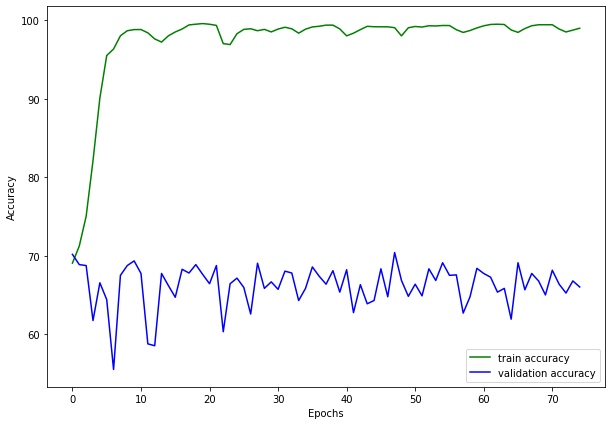

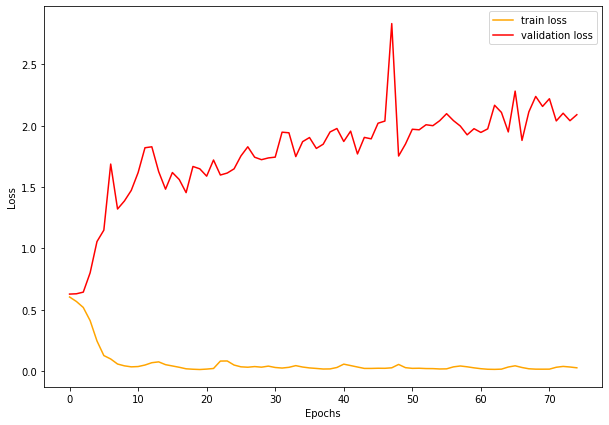

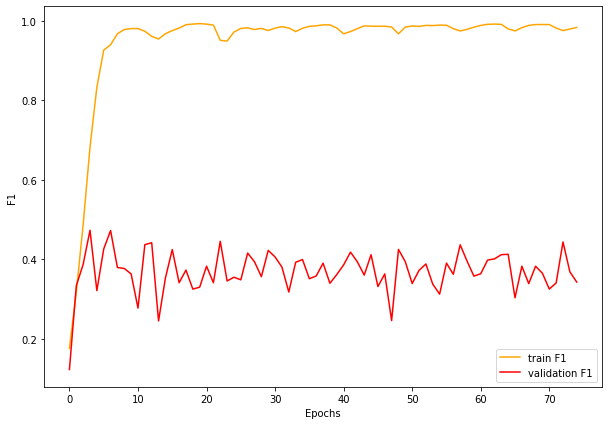

In [53]:
# accuracy plots
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
#plt.savefig('/content/drive/MyDrive/Owen/accuracy (2).png')
plt.show()
# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#plt.savefig('/content/drive/MyDrive/Owen/loss (2).png')
plt.show()
# F1 plots
plt.figure(figsize=(10, 7))
plt.plot(train_f1, color='orange', label='train F1')
plt.plot(val_f1, color='red', label='validation F1')
plt.xlabel('Epochs')
plt.ylabel('F1')
plt.legend()
#plt.savefig('/content/drive/MyDrive/Owen/F1 (2).png')
plt.show()

In [54]:
for i,val in enumerate(val_f1):
  if val == max(val_f1):
    print(i)

3


In [ ]:
results = pd.DataFrame({'Train Accuracy':train_accuracy,
                        'Validation Accuracy':val_accuracy,
                        'Train Loss':train_loss, 
                        'Validation Loss':val_loss,
                        'Train F1':train_f1,
                        'Validation F1':val_f1}, 
                         columns=['Train Accuracy','Validation Accuracy', 'Train Loss', 'Validation Loss',
                                  'Train F1', "Validation F1"])

In [ ]:
results.to_csv("/content/drive/MyDrive/Owen/final_results/second_cnn_international.csv")

In [56]:
blind_test_data = prediction_maps(xtest, ytest, tfms=0)
blindtestloader = DataLoader(blind_test_data, batch_size=200, shuffle=False)
model.load_state_dict(torch.load("/content/drive/MyDrive/Owen/international_stacked_segmented_output/epoch3"))
validate(model, blindtestloader)



  0%|          | 0/8 [00:00<?, ?it/s]

Validating




 12%|█▎        | 1/8 [00:01<00:10,  1.52s/it]

 25%|██▌       | 2/8 [00:02<00:08,  1.34s/it]

 38%|███▊      | 3/8 [00:03<00:06,  1.21s/it]

 50%|█████     | 4/8 [00:04<00:04,  1.11s/it]

 62%|██████▎   | 5/8 [00:05<00:03,  1.04s/it]

 75%|███████▌  | 6/8 [00:05<00:01,  1.02it/s]

 88%|████████▊ | 7/8 [00:06<00:00,  1.05it/s]

100%|██████████| 8/8 [00:07<00:00,  1.09it/s]

9it [00:08,  1.12it/s]                       

10it [00:09,  1.14it/s]

11it [00:10,  1.16it/s]

12it [00:11,  1.17it/s]

13it [00:11,  1.17it/s]

14it [00:12,  1.18it/s]

15it [00:13,  1.19it/s]

16it [00:14,  1.20it/s]

17it [00:15,  1.19it/s]

18it [00:16,  1.20it/s]

19it [00:16,  1.20it/s]

20it [00:17,  1.21it/s]

21it [00:18,  1.19it/s]

22it [00:18,  1.18it/s]

Val Loss: 2.0700, Val Acc: 61.50
Recall: 0.5809, Precision: 0.38, F1: 0.46
TP: 693 TN: 1895 FP: 1120 FN: 500


(2.069973759353161, 61.50190114068441, 0.46107784431137727)